# EPİAŞ PTF/SMF — Ham Veriden Çıkarımlara Kadar: **EDA › KPI’lar › Özellik Müh. › Modelleme › Değerlendirme**

Bu defter, EPİAŞ PTF/SMF tahmini için ham veriden başlayıp tüm iş akışını tek yerde toplar:

- **Veri kalitesi & temizlik:** Eksik değer, aykırı değer ve veri sözlüğü kontrolleri.
- **Mevsimsellik ve KPI panoları:** PTF/SMF trendleri, saatlik profiller, tedarik–talep dengesi, üretim karması/yenilenebilir oranları.
- **Özellik mühendisliği:** Takvim, enerji ve meteoroloji temelli gecikme/rolling/türev/etkileşim özellikleri.
- **Modeling & HPO:** Ridge (global & saatlik), LightGBM, XGBoost, RandomForest; Optuna ile zaman serisi çapraz doğrulamalı hiperparametre aramaları.
- **Backtest & Ensemble:** Walk-forward Ridge analizi, stacking/voting karşılaştırmaları; spike sınıflandırma ve iki aşamalı tahmin metrikleri.
- **Raporlama ve çıktılar:** Model kıyas tabloları, önemli özellikler, manifest/rapor dosyaları ve yeniden üretilebilir çalışma dizinleri.

Defter boyunca her bölüm, veriye dayalı kararlar için görsel inceleme + sayısal metrik kombinasyonu sunar.

In [2]:
# === Kullanıcı Parametreleri ===
TARGET = "ptf"                     # "ptf" veya "smf"
CUT = "2025-06-30 23:00:00+03:00"  # Train/test ayrımı için kesim anı
RUN_ID = f"eda_{TARGET}_pipeline_clean"

DATA_CANDIDATES = [
    "data/processed/fe_full_plus2_causal.parquet",
    "data/processed/fe_full_plus2.parquet",
    "data/processed/fe_full_plus.parquet",
    "data/processed/fe_full.parquet",
    "data/processed/fe_full.csv",
    "data/processed/fe_full_plus_winz.parquet",
    "data/processed/fe_full_std.parquet",
    "data/processed/features_ext.parquet",
    "data/processed/epias_features_full_fe_clean.csv",
    "data/processed/epias_features_full_fe.csv",
    "data/processed/epias_features_full_clean.csv",
    "data/processed/epias_features_full.csv",
    "data/processed/epias_features.csv",
]

TR_TZ = "Europe/Istanbul"

import os
os.makedirs("runs", exist_ok=True)
RUN_DIR = os.path.join("runs", RUN_ID)
os.makedirs(RUN_DIR, exist_ok=True)
print("RUN_DIR:", RUN_DIR)

RUN_DIR: runs\eda_ptf_pipeline_clean


In [4]:
# === Importlar & Yardımcılar ===
import json
import time
import warnings
from dataclasses import dataclass, field
from typing import Callable, Dict, Iterable, List, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)

CUT_TS = pd.to_datetime(CUT)

# ---------------------------------------------------------------------------
# IO yardımcıları
# ---------------------------------------------------------------------------

def _read_any(path: str) -> pd.DataFrame:
    if path.endswith(".parquet"):
        try:
            return pd.read_parquet(path)
        except Exception:
            try:
                return pd.read_parquet(path, engine="fastparquet")
            except Exception:
                import pyarrow.parquet as pq
                return pq.read_table(path, use_legacy_dataset=True).to_pandas()
    if path.endswith(".csv"):
        return pd.read_csv(path)
    raise ValueError("Desteklenmeyen biçim: " + path)


def _first_existing(paths: Iterable[str]):
    for p in paths:
        if os.path.exists(p):
            return p
    return None


def _ensure_ts(df: pd.DataFrame) -> pd.DataFrame:
    if "timestamp" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "timestamp"})
        else:
            raise ValueError("Veride 'timestamp' yok (ve indeks tarih değil).")
    ts = pd.to_datetime(df["timestamp"], errors="coerce")
    if getattr(ts.dt, "tz", None) is None:
        ts = ts.dt.tz_localize(TR_TZ, nonexistent="shift_forward", ambiguous="NaT")
    else:
        ts = ts.dt.tz_convert(TR_TZ)
    df = df.copy()
    df["timestamp"] = ts
    return df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

# ---------------------------------------------------------------------------
# Metrikler ve görselleştirmeler
# ---------------------------------------------------------------------------

def _safe_mape(y, yhat, min_y: float = 10.0, eps: float = 1e-6) -> float:
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    dynamic_floor = np.percentile(np.abs(y), 10) if y.size else min_y
    denom = np.maximum(np.abs(y), max(min_y, dynamic_floor)) + eps
    return float(np.mean(np.abs(yhat - y) / denom) * 100)


def _smape(y, yhat, eps: float = 1e-6) -> float:
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    denom = (np.abs(y) + np.abs(yhat)) + eps
    return float(np.mean(2.0 * np.abs(yhat - y) / denom) * 100)


def _metrics_reg(y, yhat) -> Dict[str, float]:
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    rmse = float(np.sqrt(np.mean((yhat - y) ** 2)))
    mae = float(np.mean(np.abs(yhat - y)))
    mape = _safe_mape(y, yhat)
    smape = _smape(y, yhat)
    denom = np.sum((y - np.mean(y)) ** 2)
    r2 = float(1 - np.sum((yhat - y) ** 2) / (denom if denom > 1e-12 else 1e-12))
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape, "R2": r2}


def _hourly_profile(df: pd.DataFrame, target: str, pred_col: str) -> pd.DataFrame:
    grouped = df.assign(hour=df["timestamp"].dt.hour)[["hour", target, pred_col]].groupby("hour", as_index=False)
    rows: List[Dict[str, float]] = []
    for hour, part in grouped:
        metrics = _metrics_reg(part[target].values, part[pred_col].values)
        rows.append({"hour": hour, **metrics})
    return pd.DataFrame(rows).sort_values("hour")


def plot_ts(df: pd.DataFrame, cols: Sequence[str], title: str, tail_hours: int = 7 * 24):
    plt.figure()
    df = df.sort_values("timestamp")
    tail = df.tail(min(tail_hours, len(df)))
    for col in cols:
        if col in tail.columns:
            plt.plot(tail["timestamp"], tail[col], label=col)
    plt.title(title)
    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend()
    plt.tight_layout()
    plt.show()


def find_best_threshold(y_true: Sequence[int], y_score: Sequence[float]) -> Tuple[float, float]:
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    if thresholds.size == 0:
        return 0.5, 0.0
    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
    idx = int(np.nanargmax(f1_scores)) if f1_scores.size else 0
    return float(thresholds[idx]), float(f1_scores[idx])

# ---------------------------------------------------------------------------
# Zaman serisi CV ve walk-forward yardımcıları
# ---------------------------------------------------------------------------



def time_series_window_splits(
    n_samples: int,
    n_splits: int = 3,
    test_size: int = 168,
    min_train: int = 24,
) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Sliding windows over the tail; adjusts when history is short."""
    if n_samples <= max(min_train, 1) or test_size <= 0 or n_splits <= 0:
        warnings.warn(
            "time_series_window_splits received insufficient samples; returning []",
            RuntimeWarning,
        )
        return []

    def _build(ts: int) -> List[Tuple[np.ndarray, np.ndarray]]:
        tail = min(n_samples, ts * n_splits)
        start_base = max(0, n_samples - tail)
        folds: List[Tuple[np.ndarray, np.ndarray]] = []
        for fold in range(n_splits):
            te_start = start_base + fold * ts
            te_end = min(te_start + ts, n_samples)
            tr_idx = np.arange(0, te_start, dtype=int)
            te_idx = np.arange(te_start, te_end, dtype=int)
            if len(tr_idx) < max(min_train, ts // 2) or len(te_idx) == 0:
                continue
            folds.append((tr_idx, te_idx))
        return folds

    folds = _build(test_size)
    if not folds:
        alt_test = max(24, min(test_size, max(1, n_samples // (n_splits + 1))))
        if alt_test != test_size:
            warnings.warn(
                f"time_series_window_splits adjusted test_size from {test_size} to {alt_test}",
                RuntimeWarning,
            )
            folds = _build(alt_test)

    if not folds:
        warnings.warn(
            "time_series_window_splits could not create any folds",
            RuntimeWarning,
        )
        return []

    if len(folds) < n_splits:
        warnings.warn(
            f"time_series_window_splits produced {len(folds)} folds (requested {n_splits})",
            RuntimeWarning,
        )
    return folds

def ts_cross_val(estimator, X: np.ndarray, y: np.ndarray, splits: Sequence[Tuple[np.ndarray, np.ndarray]]):
    preds = np.full(shape=y.shape, fill_value=np.nan, dtype=float)
    fold_rows: List[Dict[str, float]] = []
    for fold_idx, (tr_idx, te_idx) in enumerate(splits, start=1):
        mdl = clone(estimator)
        mdl.fit(X[tr_idx], y[tr_idx])
        yh = mdl.predict(X[te_idx])
        preds[te_idx] = yh
        fold_rows.append({"fold": fold_idx, **_metrics_reg(y[te_idx], yh)})
    mask = ~np.isnan(preds)
    overall = _metrics_reg(y[mask], preds[mask]) if mask.any() else {"RMSE": np.nan, "MAE": np.nan, "MAPE%": np.nan, "sMAPE%": np.nan, "R2": np.nan}
    fold_df = pd.DataFrame(fold_rows).sort_values("fold") if fold_rows else pd.DataFrame()
    return preds, fold_df, overall


def walkforward_backtest(
    df: pd.DataFrame,
    features: Sequence[str],
    target: str,
    estimator_factory: Callable[[], Pipeline],
    test_hours: int = 168,
    n_folds: int = 6,
):
    df_sorted = df.sort_values("timestamp").reset_index(drop=True)
    preds_parts: List[pd.DataFrame] = []
    fold_rows: List[Dict[str, float]] = []
    for fold in range(1, n_folds + 1):
        te_end = len(df_sorted) - (n_folds - fold) * test_hours
        te_start = te_end - test_hours
        if te_start <= 0 or te_end <= te_start:
            continue
        train_slice = df_sorted.iloc[:te_start]
        test_slice = df_sorted.iloc[te_start:te_end]
        if train_slice.empty or test_slice.empty:
            continue
        Xtr = train_slice[features].fillna(0.0).to_numpy()
        ytr = train_slice[target].astype(float).to_numpy()
        Xte = test_slice[features].fillna(0.0).to_numpy()
        yte = test_slice[target].astype(float).to_numpy()
        estimator = estimator_factory()
        estimator.fit(Xtr, ytr)
        yhat = estimator.predict(Xte)
        fold_rows.append({"fold": fold, **_metrics_reg(yte, yhat)})
        fold_preds = test_slice[["timestamp", target]].copy()
        fold_preds[f"{target}_pred"] = yhat
        fold_preds["fold"] = fold
        preds_parts.append(fold_preds)
    preds_df = pd.concat(preds_parts, ignore_index=True) if preds_parts else pd.DataFrame()
    if preds_df.empty:
        overall = {"RMSE": np.nan, "MAE": np.nan, "MAPE%": np.nan, "sMAPE%": np.nan, "R2": np.nan}
    else:
        overall = _metrics_reg(preds_df[target].values, preds_df[f"{target}_pred"].values)
    fold_df = pd.DataFrame(fold_rows).sort_values("fold") if fold_rows else pd.DataFrame()
    return preds_df, fold_df, overall

# ---------------------------------------------------------------------------
# Outlier temizleyici
# ---------------------------------------------------------------------------

@dataclass
class OutlierCleaner:
    hourly_cols: Sequence[str] = field(default_factory=tuple)
    global_cols: Sequence[str] = field(default_factory=tuple)
    clip_cols_01: Sequence[str] = field(default_factory=tuple)
    log_cols: Sequence[str] = field(default_factory=tuple)
    q_low: float = 0.005
    q_high: float = 0.995
    log_suffix: str = "_log1p"

    def __post_init__(self):
        self.hourly_thresholds: Dict[str, Dict[int, Tuple[float, float]]] = {}
        self.global_thresholds: Dict[str, Tuple[float, float]] = {}

    def fit(self, df: pd.DataFrame) -> "OutlierCleaner":
        if "timestamp" not in df.columns:
            raise ValueError("timestamp kolonu gerekli")
        hours = df["timestamp"].dt.hour
        for col in self.hourly_cols:
            if col not in df.columns:
                continue
            values = pd.to_numeric(df[col], errors="coerce")
            valid = pd.DataFrame({"value": values, "hour": hours}).dropna()
            if valid.empty:
                continue
            quantiles = valid.groupby("hour")["value"].quantile([self.q_low, self.q_high]).unstack()
            if quantiles.empty:
                continue
            thresholds: Dict[int, Tuple[float, float]] = {}
            for hour, row in quantiles.iterrows():
                thresholds[int(hour)] = (float(row.get(self.q_low, np.nan)), float(row.get(self.q_high, np.nan)))
            self.hourly_thresholds[col] = thresholds
        for col in self.global_cols:
            if col not in df.columns:
                continue
            series = pd.to_numeric(df[col], errors="coerce").dropna()
            if series.empty:
                continue
            low, high = series.quantile(self.q_low), series.quantile(self.q_high)
            self.global_thresholds[col] = (float(low), float(high))
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        if "timestamp" not in df.columns:
            raise ValueError("timestamp kolonu gerekli")
        data = df.copy()
        hours = data["timestamp"].dt.hour
        for col, thresholds in self.hourly_thresholds.items():
            if col not in data.columns:
                continue
            values = pd.to_numeric(data[col], errors="coerce").to_numpy(dtype=float, copy=True)
            low_map = {h: bounds[0] for h, bounds in thresholds.items() if not np.isnan(bounds[0])}
            high_map = {h: bounds[1] for h, bounds in thresholds.items() if not np.isnan(bounds[1])}
            low = hours.map(low_map).to_numpy(dtype=float)
            high = hours.map(high_map).to_numpy(dtype=float)
            with np.errstate(invalid="ignore"):
                values = np.where(~np.isnan(low) & (values < low), low, values)
                values = np.where(~np.isnan(high) & (values > high), high, values)
            data[col] = values
        for col, (low, high) in self.global_thresholds.items():
            if col in data.columns:
                series = pd.to_numeric(data[col], errors="coerce")
                data[col] = series.clip(lower=low, upper=high)
        for col in self.clip_cols_01:
            if col in data.columns:
                data[col] = pd.to_numeric(data[col], errors="coerce").clip(lower=0.0, upper=1.0)
        for col in self.log_cols:
            if col in data.columns:
                base = np.maximum(pd.to_numeric(data[col], errors="coerce"), 0.0)
                data[f"{col}{self.log_suffix}"] = np.log1p(base)
        return data

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.fit(df).transform(df)

# ---------------------------------------------------------------------------
# Outlier ve özellik yardımcıları
# ---------------------------------------------------------------------------

def iqr_bounds(series: pd.Series, factor: float = 1.5) -> Tuple[float, float]:
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return float(q1 - factor * iqr), float(q3 + factor * iqr)


def robust_zscore(series: pd.Series) -> pd.Series:
    med = series.median()
    mad = np.median(np.abs(series - med)) + 1e-9
    return (series - med) / (1.4826 * mad)


def summarize_outliers(df: pd.DataFrame, cols: Sequence[str], z_thresh: float = 3.5) -> pd.DataFrame:
    rows = []
    for col in cols:
        if col not in df.columns:
            continue
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        if s.empty:
            rows.append({"col": col, "iqr_outliers": 0, "robust_z_outliers": 0})
            continue
        low, high = iqr_bounds(s)
        iqr_cnt = int(((s < low) | (s > high)).sum())
        z = robust_zscore(s)
        rz_cnt = int((np.abs(z) > z_thresh).sum())
        rows.append({"col": col, "iqr_outliers": iqr_cnt, "robust_z_outliers": rz_cnt})
    return pd.DataFrame(rows).sort_values(["iqr_outliers", "robust_z_outliers"], ascending=False)


def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["hour"] = out["timestamp"].dt.hour.astype(int)
    out["dow"] = out["timestamp"].dt.dayofweek.astype(int)
    out["month"] = out["timestamp"].dt.month.astype(int)
    out["is_weekend"] = (out["dow"] >= 5).astype(int)
    for col, period in [("hour", 24), ("dow", 7), ("month", 12)]:
        rad = 2 * np.pi * out[col] / period
        out[f"{col}_sin"] = np.sin(rad)
        out[f"{col}_cos"] = np.cos(rad)
    return out


def add_power_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    share_cols = [c for c in ["wind_share", "solar_share", "hydro_share", "thermal_share"] if c in out.columns]
    if share_cols:
        renewable_ratio = out.get("wind_share", 0).fillna(0) + out.get("solar_share", 0).fillna(0) + out.get("hydro_share", 0).fillna(0)
        out["renewable_ratio"] = renewable_ratio.clip(lower=0.0, upper=1.5)
        if "gen_total_mw" in out.columns:
            out["renewable_mw"] = out["gen_total_mw"] * out["renewable_ratio"].fillna(0)
            out["thermal_mw"] = out["gen_total_mw"] * out.get("thermal_share", 0).fillna(0)
    if {"consumption_mwh", "renewable_mw"}.issubset(out.columns):
        out["net_load_mw"] = out["consumption_mwh"] - out["renewable_mw"]
        denom = out["consumption_mwh"].replace(0, np.nan)
        out["net_load_ratio"] = out["net_load_mw"] / denom
    if {"consumption_mwh", "thermal_share"}.issubset(out.columns):
        out["consumption_x_thermal"] = out["consumption_mwh"] * out["thermal_share"]
    if {"wind_share", "wind_speed_10m"}.issubset(out.columns):
        out["wind_share_x_speed"] = out["wind_share"] * out["wind_speed_10m"]
    return out


def add_lag_features(df: pd.DataFrame, cols: Sequence[str], lags: Sequence[int] = (1, 24), roll: int = 24) -> pd.DataFrame:
    out = df.copy()
    for col in cols:
        if col not in out.columns:
            continue
        series = out[col]
        for lag in lags:
            out[f"{col}_lag_{lag}"] = series.shift(lag)
        lag1 = series.shift(1)
        out[f"{col}_roll{roll}_mean"] = lag1.rolling(roll, min_periods=max(3, roll // 3)).mean()
        out[f"{col}_roll{roll}_std"] = lag1.rolling(roll, min_periods=max(3, roll // 3)).std()
        out[f"{col}_diff_1"] = series.shift(1) - series.shift(2)
        if 24 in lags:
            out[f"{col}_diff_24"] = series.shift(1) - series.shift(25)
    return out


def add_ramp_features(df: pd.DataFrame, cols: Sequence[str]) -> pd.DataFrame:
    out = df.copy()
    for col in cols:
        if col in out.columns:
            out[f"{col}_ramp"] = out[col].shift(1) - out[col].shift(2)
    return out


def add_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    def prefer(col: str):
        return out.get(f"{col}_lag_1", out.get(col))
    interactions = [
        ("hour", "solar_share"),
        ("thermal_share", "consumption_mwh"),
        ("wind_share", "wind_speed_10m"),
        ("net_load_mw", "temperature_2m"),
        ("renewable_ratio", "shortwave_radiation"),
    ]
    for a, b in interactions:
        sa, sb = prefer(a), prefer(b)
        if sa is not None and sb is not None and a in out.columns and (b in out.columns or prefer(b) is not None):
            out[f"{a}__x__{b}"] = np.asarray(sa) * np.asarray(sb)
    return out


def build_feature_frame(df: pd.DataFrame, target: str, extra_targets: Sequence[str] = ("smf",), drop_rows: int = 48) -> pd.DataFrame:
    d = df.sort_values("timestamp").reset_index(drop=True)
    d = add_calendar_features(d)
    d = add_power_features(d)
    lag_targets = [target, *extra_targets, "net_load_mw", "consumption_mwh", "gen_total_mw", "thermal_mw", "renewable_mw"]
    present_lag_targets = [c for c in lag_targets if c in d.columns]
    d = add_lag_features(d, present_lag_targets, lags=(1, 2, 24), roll=24)
    ramp_cols = [c for c in ["consumption_mwh", "gen_total_mw", "net_load_mw", "thermal_mw", "renewable_mw", target, "smf"] if c in d.columns]
    d = add_ramp_features(d, ramp_cols)
    d = add_interaction_features(d)
    d = d.dropna().reset_index(drop=True)
    if drop_rows > 0 and len(d) > drop_rows:
        d = d.iloc[drop_rows:].reset_index(drop=True)
    return d

In [6]:
# === Veri Yükle ===
DATA_PATH = _first_existing(DATA_CANDIDATES)
if DATA_PATH is None:
    raise SystemExit("Aday veri dosyalarından hiçbiri bulunamadı. DATA_CANDIDATES listesini güncelleyin.")

df_raw = _ensure_ts(_read_any(DATA_PATH))
print("DATA_PATH:", DATA_PATH)
print("Satır/sütun:", df_raw.shape)

train_mask_raw = df_raw["timestamp"] <= CUT_TS
train_raw = df_raw.loc[train_mask_raw].copy()
test_raw = df_raw.loc[~train_mask_raw].copy()
print("Raw train/test:", train_raw.shape, test_raw.shape)

cleaner = OutlierCleaner(
    hourly_cols=(
        "ptf", "smf",
        "shortwave_radiation", "direct_radiation", "diffuse_radiation",
        "CDH", "HDH", "CDH_roll_24", "HDH_roll_24", "solar_cf_proxy",
        "gen_total_mw", "consumption_mwh"
    ),
    global_cols=("wind_speed_10m", "wind_gusts_10m"),
    clip_cols_01=("solar_share", "wind_share", "hydro_share", "thermal_share"),
    log_cols=(
        "shortwave_radiation", "direct_radiation", "diffuse_radiation",
        "CDH", "HDH", "CDH_roll_24", "HDH_roll_24", "solar_cf_proxy"
    ),
    q_low=0.005,
    q_high=0.995,
)

cleaner.fit(train_raw)
train_clean = cleaner.transform(train_raw)
test_clean = cleaner.transform(test_raw)

df_clean = (
    pd.concat([train_clean, test_clean], axis=0)
    .sort_values("timestamp")
    .reset_index(drop=True)
)

print("Clean train/test:", train_clean.shape, test_clean.shape)
print("Toplam temiz veri:", df_clean.shape)
print("Saat bazlı eşik öğrenilen kolon sayısı:", {c: len(v) for c, v in cleaner.hourly_thresholds.items()})

df_clean.head(3)

DATA_PATH: data/processed/fe_full_plus2_causal.parquet
Satır/sütun: (14783, 56)
Raw train/test: (13080, 56) (1703, 56)
Clean train/test: (13080, 64) (1703, 64)
Toplam temiz veri: (14783, 64)
Saat bazlı eşik öğrenilen kolon sayısı: {'ptf': 24, 'smf': 24, 'shortwave_radiation': 24, 'direct_radiation': 24, 'diffuse_radiation': 24, 'CDH': 24, 'HDH': 24, 'CDH_roll_24': 24, 'HDH_roll_24': 24, 'solar_cf_proxy': 24, 'gen_total_mw': 24, 'consumption_mwh': 24}


timestamp     ptf     smf  consumption_mwh  gen_total_mw  wind_share   solar_share  hydro_share  thermal_share  is_holiday  temperature_2m  \
0 2024-01-03 00:00:00+03:00  2325.0  2389.0         34295.16      34238.71    0.064755  2.920671e-07     0.243592       0.691653       False            8.49   
1 2024-01-03 01:00:00+03:00  2248.0  2248.0         32671.59      32614.62    0.064771  3.066110e-07     0.224995       0.710234       False            8.50   
2 2024-01-03 02:00:00+03:00  2188.0  2188.0         31302.90      31245.56    0.066595  3.200455e-07     0.220853       0.712552       False            8.16   

   relative_humidity_2m  wind_speed_10m  wind_gusts_10m  cloud_cover  shortwave_radiation  direct_radiation  diffuse_radiation   HDH  CDH  HDH_roll_24  CDH_roll_24  \
0                  94.8           6.580          13.840        79.30                  0.0               0.0                0.0  9.51  0.0      191.660          0.0   
1                  94.8           7.695          15.380        65.00                  0.0               0.0                0.0  9.50  0.0      191.515          0.0   
2                  94.3           7.430          15.185        63.85                  0.0               0.0                0.0  9.84  0.0      191.505          0.0   

   solar_cf_proxy  hour  dow  month  hour_sin  hour_cos   dow_sin   dow_cos  month_sin  month_cos  ptf_lag_1  ptf_lag_24  ptf_roll24_mean  smf_lag_1  smf_lag_24  smf_roll24_mean  \
0             0.0     0    2      1  0.000000  1.000000  0.974928 -0.222521        0.5   0.866025     2198.0     1299.99      2060.299583     1698.0       560.0      1665.420417   
1             0.0     1    2      1  0.258819  0.965926  0.974928 -0.222521        0.5   0.866025     2325.0     1299.99      2103.008333     2389.0       500.0      1741.628750   
2             0.0     2    2      1  0.500000  0.866025  0.974928 -0.222521        0.5   0.866025     2248.0     1285.81      2142.508750     2248.0        30.0      1814.462083   

   consumption_mwh_lag_1  consumption_mwh_lag_24  consumption_mwh_roll24_mean  smf_roll24_std  smf_roll24_diff  smf_diff_1  smf_diff_24  consumption_lag_1  consumption_lag_24  \
0               36599.12                29663.42                 36905.178750      845.549350        32.579583        -2.0       1598.0           36599.12            29663.42   
1               34295.16                28162.30                 37098.167917      823.728618       647.371250       691.0       1829.0           34295.16            28162.30   
2               32671.59                27356.95                 37286.055000      785.565996       433.537917      -141.0       1748.0           32671.59            27356.95   

   consumption_roll24_mean  consumption_roll24_std  consumption_roll24_diff  consumption_diff_1  consumption_diff_24  ptf_roll24_std  ptf_roll24_diff  ptf_diff_1  ptf_diff_24  \
0             36905.178750             6525.854464              -306.058750            -1834.41              4899.08      549.529096       137.700417     -100.01      1284.36   
1             37098.167917             6368.984328             -2803.007917            -2303.96              4631.74      527.249218       221.991667      127.00      1025.01   
2             37286.055000             6156.893383             -4614.465000            -1623.57              4509.29      499.240611       105.491250      -77.00       948.01   

   shortwave_radiation_log1p  direct_radiation_log1p  diffuse_radiation_log1p  CDH_log1p  HDH_log1p  CDH_roll_24_log1p  HDH_roll_24_log1p  solar_cf_proxy_log1p  
0                        0.0                     0.0                      0.0        0.0   2.352327                0.0           5.260927                   0.0  
1                        0.0                     0.0                      0.0        0.0   2.351375                0.0           5.260174                   0.0  
2                        0.0                     0.0                   

## Veri Sözlüğü (EPİAŞ PTF/SMF EDA)

| Sütun | Tip/Aralık | Birim | Açıklama / Nasıl oluşturulur |
|---|---|---|---|
| **timestamp** | datetime (tz=Europe/Istanbul) | — | Gözlemin zaman damgası (saatlik). Zaman serisi analizi bu alana göre sıralanır. |
| **ptf** | float | TL/MWh | Piyasa Takas Fiyatı (hedef değişkenlerden biri). |
| **smf** | float | TL/MWh | Sistem Marjinal Fiyatı (diğer hedef). |
| **consumption_mwh** | float | MWh | Tüketim/çekiş miktarı (saatlik). |
| **gen_total_mw** | float | MW | Toplam üretim gücü (saatlik). |
| **wind_share** | float ∈ [0,1] | oran | Rüzgârın toplam üretimdeki payı. |
| **solar_share** | float ∈ [0,1] | oran | Güneşin toplam üretimdeki payı. |
| **hydro_share** | float ∈ [0,1] | oran | Hidrolik üretim payı. |
| **thermal_share** | float ∈ [0,1] | oran | Termik üretim payı. |
| **is_holiday** | {0,1} | — | Resmî tatil göstergesi (TR). 1=tatil, 0=değil. |
| **temperature_2m** | float | °C | 2 m hava sıcaklığı. |
| **relative_humidity_2m** | float | % | 2 m bağıl nem (0–100). |
| **wind_speed_10m** | float | m/s | 10 m rüzgâr hızı. |
| **wind_gusts_10m** | float | m/s | 10 m ani rüzgâr (gust). |
| **cloud_cover** | float | % | Bulutluluk (0–100). |
| **shortwave_radiation** | float | W/m² | Kısa dalga/radyasyon toplamı. |
| **direct_radiation** | float | W/m² | Doğrudan güneş radyasyonu. |
| **diffuse_radiation** | float | W/m² | Yayılı (diffuse) güneş radyasyonu. |
| **HDH** | float ≥ 0 | °C·saat | Heating Degree Hours:  \`HDH = max(0, T_base − temperature_2m)\`. Genelde T_base=18°C. |
| **CDH** | float ≥ 0 | °C·saat | Cooling Degree Hours:  \`CDH = max(0, temperature_2m − T_base)\`. Genelde T_base=22–24°C tercih edilir. |
| **HDH_roll_24** | float | °C·saat | Son 24 saatin (nedensel) **ortalama** veya **toplam** HDH’si. Çoğu kurulumda ortalama kullanılır; sizdeki üretime göre: önceki 24 saat üzerinden \`rolling mean\` (laglı) olarak hesaplanmıştır. |
| **CDH_roll_24** | float | °C·saat | Son 24 saatin (nedensel) CDH **ortalaması** (genelde). |
| **solar_cf_proxy** | float ∈ [0,1] | oran | Güneş kapasite faktörü vekili. Çoğunlukla radyasyon (örn. shortwave/direct) değerlerinin normalize edilmesiyle türetilir; “daha çok ışınım → daha yüksek değer”. |
| **hour** | int ∈ {0..23} | saat | Zaman damgasının saat bileşeni. |
| **dow** | int ∈ {0..6} | — | Haftanın günü (0=Mon … 6=Sun). |
| **month** | int ∈ {1..12} | — | Ay. |
| **hour_sin**, **hour_cos** | float ∈ [−1,1] | — | Saatin **döngüsel (cyclic)** kodlaması*.  \`sin(2π·hour/24)\`, \`cos(2π·hour/24)\`. |
| **dow_sin**, **dow_cos** | float ∈ [−1,1] | — | Günün **cyclic** kodlaması. \`sin(2π·dow/7)\`, \`cos(2π·dow/7)\`. |
| **month_sin**, **month_cos** | float ∈ [−1,1] | — | Ayın **cyclic** kodlaması. \`sin(2π·month/12)\`, \`cos(2π·month/12)\`. |
| **ptf_lag_1** | float | TL/MWh | PTF’in 1 saat gecikmeli değeri: \`ptf(t−1)\`. |
| **ptf_lag_24** | float | TL/MWh | PTF’in 24 saat gecikmeli değeri: \`ptf(t−24)\`. |
| **ptf_roll24_mean** | float | TL/MWh | PTF’in son 24 saatteki **nedensel ortalaması**: \`mean(ptf(t−1..t−24))\`. |
| **smf_lag_1** | float | TL/MWh | SMF’in 1 saat gecikmeli değeri. |
| **smf_lag_24** | float | TL/MWh | SMF’in 24 saat gecikmeli değeri. |
| **smf_roll24_mean** | float | TL/MWh | SMF’in son 24 saatteki **nedensel ortalaması**. |
| **consumption_mwh_lag_1** | float | MWh | Tüketimin 1 saat gecikmeli değeri. |
| **consumption_mwh_lag_24** | float | MWh | Tüketimin 24 saat gecikmeli değeri. |
| **consumption_mwh_roll24_mean** | float | MWh | Tüketimin son 24 saatteki **nedensel ortalaması**. |
| **smf_roll24_std** | float | TL/MWh | SMF’in son 24 saatteki nedensel **standart sapması**. |
| **smf_roll24_diff** | float | TL/MWh | **Not:** İki yaygın kullanım var: (A) \`smf(t−1) − smf(t−25)\` (24 saat aralıklı fark) **veya** (B) \`smf(t−1) − roll24_mean(t−1)\` (değer − 24 saatlik ortalama). Sizin setinizde büyük olasılıkla (A) ya da (B) kullanılmıştır (aşağıdaki “doğrulama” kodu ile 1 dk’da kontrol edebilirsiniz). |
| **smf_diff_1** | float | TL/MWh | \`smf(t−1) − smf(t−2)\`. |
| **smf_diff_24** | float | TL/MWh | \`smf(t−1) − smf(t−25)\` (gün-aşırı fark). |
| **consumption_lag_1** | float | MWh | (alternatif adlandırma) tüketim 1 saat gecikme. |
| **consumption_lag_24** | float | MWh | tüketim 24 saat gecikme. |
| **consumption_roll24_mean** | float | MWh | tüketimin son 24 saat **ortalaması** (nedensel). |
| **consumption_roll24_std** | float | MWh | tüketimin son 24 saat **std**’si (nedensel). |
| **consumption_roll24_diff** | float | MWh | **Not:** SMF’deki açıklama ile aynı; (A) \`cons(t−1) − cons(t−25)\` **veya** (B) \`cons(t−1) − roll24_mean(t−1)\`. |
| **consumption_diff_1** | float | MWh | \`cons(t−1) − cons(t−2)\`. |
| **consumption_diff_24** | float | MWh | \`cons(t−1) − cons(t−25)\`. |
| **ptf_roll24_std** | float | TL/MWh | PTF’in son 24 saat **std**’si (nedensel). |
| **ptf_roll24_diff** | float | TL/MWh | **Not:** (A) \`ptf(t−1) − ptf(t−25)\` **veya** (B) \`ptf(t−1) − roll24_mean(t−1)\`. |
| **ptf_diff_1** | float | TL/MWh | \`ptf(t−1) − ptf(t−2)\`. |
| **ptf_diff_24** | float | TL/MWh | \`ptf(t−1) − ptf(t−25)\`. |

>  **Döngüsel Kodlama**: Bu tür verileri makine öğrenmesi modellerinin daha iyi anlayabileceği hale getirmek için kullanılan bir yöntemdir. Basitçe, doğrusal bir sayı doğrusundaki döngüsel bir özelliği (örneğin 0'dan 23'e kadar olan saatler), bir daire üzerindeki koordinatlara dönüştürür. Bu dönüşüm için genellikle sinüs ve kosinüs fonksiyonları kullanılır.

> **“Nedensel (causal)” notu:** Tüm rolling/lag/diff hesapları **mevcut saat bilgisini kullanmaz**; sadece geçmiş (\`t−k\`) değerleriyle hesaplanır (ör. \`roll24_mean\` daima \`t−1..t−24\` penceresinden).

> **Gecikmeli (Lag), Yuvarlanan Ortalama (Roll_mean) ve Fark (Diff) Özellikleri Ne İşe Yarar?**
Veri biliminde bu üç özellik, özellikle zaman serisi analizlerinde ve tahmin modellerinde sıklıkla kullanılır. Bu özellikler, bir zaman serisindeki geçmiş verileri kullanarak gelecekteki değerleri tahmin etmeye yardımcı olur. Her biri, veriden farklı bir tür bilgi çıkarır.

>**Gecikmeli (Lag) Değerler**: Bir değişkenin belirli bir önceki zaman noktasındaki (bir önceki saat, bir önceki gün vb.) değerini ifade eder. Bir zaman serisindeki en güçlü tahmincilerden biri genellikle o serinin kendi geçmiş değerleridir. Örneğin, bugünün elektrik tüketimini tahmin etmek için dünün aynı saatteki tüketimini bilmek oldukça faydalıdır.

>**Yuvarlanan Ortalama (Rolling Mean) Değerleri**: Bir değişkenin belirli bir zaman aralığındaki (örneğin son 24 saat) ortalama değerini ifade eder. Veri setindeki gürültüyü (ani dalgalanmaları) azaltarak altta yatan temel trendi ortaya çıkarır. Modellerin daha stabil ve tutarlı tahminler yapmasına yardımcı olur. Örneğin, bir hisse senedinin 50 günlük hareketli ortalaması, o hissenin kısa vadeli dalgalanmalarından bağımsız olarak genel eğilimini gösterir.

>**Fark (Diff) Değerleri**: Bir değişkenin mevcut değeri ile belirli bir önceki zaman noktasındaki değeri arasındaki farkı gösterir. Veri setindeki mevsimsellik ve trend gibi yapısal özellikleri ortadan kaldırarak seriyi durağan (stationary) hale getirir. Bu, birçok istatistiksel ve makine öğrenmesi modelinin daha iyi performans göstermesini sağlar. Örneğin, bir önceki günün aynı saatiyle bugünün aynı saati arasındaki farkı almak, günlük döngüden bağımsız olarak değişimi yakalar. 

## 1) Genel Resim / Eksikler / Duplicates / Türler



In [9]:
from IPython.display import display

print("Ham veri baş/son örnekler")
display(df_raw.head(3))
display(df_raw.tail(3))
print("Temiz veri baş örnekler")
display(df_clean.head(3))
print("Ham veri şekli:", df_raw.shape)
print("Temiz veri şekli:", df_clean.shape)

print("Dtype bilgisi:")
display(df_raw.dtypes)

na_counts = df_raw.isna().sum().sort_values(ascending=False)
display(na_counts[na_counts > 0])

duplicate_count = df_raw.duplicated(subset=["timestamp"]).sum()
print("timestamp bazlı duplicate sayısı:", duplicate_count)

Ham veri baş/son örnekler


timestamp     ptf     smf  consumption_mwh  gen_total_mw  wind_share   solar_share  hydro_share  thermal_share  is_holiday  temperature_2m  \
0 2024-01-03 00:00:00+03:00  2325.0  2389.0         34295.16      34238.71    0.064755  2.920671e-07     0.243592       0.691653       False            8.49   
1 2024-01-03 01:00:00+03:00  2248.0  2248.0         32671.59      32614.62    0.064771  3.066110e-07     0.224995       0.710234       False            8.50   
2 2024-01-03 02:00:00+03:00  2188.0  2188.0         31302.90      31245.56    0.066595  3.200455e-07     0.220853       0.712552       False            8.16   

   relative_humidity_2m  wind_speed_10m  wind_gusts_10m  cloud_cover  shortwave_radiation  direct_radiation  diffuse_radiation   HDH  CDH  HDH_roll_24  CDH_roll_24  \
0                  94.8           6.580          13.840        79.30                  0.0               0.0                0.0  9.51  0.0      191.660          0.0   
1                  94.8           7.695          15.380        65.00                  0.0               0.0                0.0  9.50  0.0      191.515          0.0   
2                  94.3           7.430          15.185        63.85                  0.0               0.0                0.0  9.84  0.0      191.505          0.0   

   solar_cf_proxy  hour  dow  month  hour_sin  hour_cos   dow_sin   dow_cos  month_sin  month_cos  ptf_lag_1  ptf_lag_24  ptf_roll24_mean  smf_lag_1  smf_lag_24  smf_roll24_mean  \
0             0.0     0    2      1  0.000000  1.000000  0.974928 -0.222521        0.5   0.866025     2198.0     1299.99      2060.299583     1698.0       560.0      1665.420417   
1             0.0     1    2      1  0.258819  0.965926  0.974928 -0.222521        0.5   0.866025     2325.0     1299.99      2103.008333     2389.0       500.0      1741.628750   
2             0.0     2    2      1  0.500000  0.866025  0.974928 -0.222521        0.5   0.866025     2248.0     1285.81      2142.508750     2248.0        30.0      1814.462083   

   consumption_mwh_lag_1  consumption_mwh_lag_24  consumption_mwh_roll24_mean  smf_roll24_std  smf_roll24_diff  smf_diff_1  smf_diff_24  consumption_lag_1  consumption_lag_24  \
0               36599.12                29663.42                 36905.178750      845.549350        32.579583        -2.0       1598.0           36599.12            29663.42   
1               34295.16                28162.30                 37098.167917      823.728618       647.371250       691.0       1829.0           34295.16            28162.30   
2               32671.59                27356.95                 37286.055000      785.565996       433.537917      -141.0       1748.0           32671.59            27356.95   

   consumption_roll24_mean  consumption_roll24_std  consumption_roll24_diff  consumption_diff_1  consumption_diff_24  ptf_roll24_std  ptf_roll24_diff  ptf_diff_1  ptf_diff_24  
0             36905.178750             6525.854464              -306.058750            -1834.41              4899.08      549.529096       137.700417     -100.01      1284.36  
1             37098.167917             6368.984328             -2803.007917            -2303.96              4631.74      527.249218       221.991667      127.00      1025.01  
2             37286.055000             6156.893383             -4614.465000            -1623.57              4509.29      499.240611       105.491250      -77.00       948.01

timestamp      ptf     smf  consumption_mwh  gen_total_mw  wind_share   solar_share  hydro_share  thermal_share  is_holiday  temperature_2m  \
14780 2025-09-09 20:00:00+03:00  3074.01  2001.0         41320.69       38989.4    0.110459  2.564800e-07     0.135673       0.753867       False          21.115   
14781 2025-09-09 21:00:00+03:00  3074.01  2001.0         41320.69       38989.4    0.110459  2.564800e-07     0.135673       0.753867       False          21.115   
14782 2025-09-09 22:00:00+03:00  3074.01  2001.0         41320.69       38989.4    0.110459  2.564800e-07     0.135673       0.753867       False          21.115   

       relative_humidity_2m  wind_speed_10m  wind_gusts_10m  cloud_cover  shortwave_radiation  direct_radiation  diffuse_radiation  HDH  CDH  HDH_roll_24  CDH_roll_24  \
14780                  69.4           5.445          10.985          9.1                  0.0               0.0                0.0  0.0  0.0          0.0        32.19   
14781                  69.4           5.445          10.985          9.1                  0.0               0.0                0.0  0.0  0.0          0.0        32.19   
14782                  69.4           5.445          10.985          9.1                  0.0               0.0                0.0  0.0  0.0          0.0        32.19   

       solar_cf_proxy  hour  dow  month  hour_sin  hour_cos   dow_sin  dow_cos  month_sin     month_cos  ptf_lag_1  ptf_lag_24  ptf_roll24_mean  smf_lag_1  smf_lag_24  \
14780             0.0    20    1      9 -0.866025  0.500000  0.781831  0.62349       -1.0 -1.836970e-16    3074.01     3395.00      3107.144583     2001.0      3400.0   
14781             0.0    21    1      9 -0.707107  0.707107  0.781831  0.62349       -1.0 -1.836970e-16    3074.01     3392.27      3093.770000     2001.0      3400.0   
14782             0.0    22    1      9 -0.500000  0.866025  0.781831  0.62349       -1.0 -1.836970e-16    3074.01     3229.99      3080.509167     2001.0      2377.0   

       smf_roll24_mean  consumption_mwh_lag_1  consumption_mwh_lag_24  consumption_mwh_roll24_mean  smf_roll24_std  smf_roll24_diff  smf_diff_1  smf_diff_24  consumption_lag_1  \
14780      2133.250000               41320.69                46721.21                 41806.817500      397.602407      -132.250000         0.0      -1394.0           41320.69   
14781      2074.958333               41320.69                45294.56                 41581.795833      292.463373       -73.958333         0.0      -1399.0           41320.69   
14782      2016.666667               41320.69                43613.36                 41416.217917       76.750679       -15.666667         0.0      -1399.0           41320.69   

       consumption_lag_24  consumption_roll24_mean  consumption_roll24_std  consumption_roll24_diff  consumption_diff_1  consumption_diff_24  ptf_roll24_std  ptf_roll24_diff  \
14780            46721.21             41806.817500             1391.619577              -486.127500                 0.0             -5688.70       93.786101       -33.134583   
14781            45294.56             41581.795833              918.688772              -261.105833                 0.0             -5400.52       71.093388       -19.760000   
14782            43613.36             41416.217917              467.989304               -95.527917                 0.0             -3973.87       31.839284        -6.499167   

       ptf_diff_1  ptf_diff_24  
14780         0.0      -320.99  
14781         0.0      -320.99  
14782         0.0      -318.26

Temiz veri baş örnekler


timestamp     ptf     smf  consumption_mwh  gen_total_mw  wind_share   solar_share  hydro_share  thermal_share  is_holiday  temperature_2m  \
0 2024-01-03 00:00:00+03:00  2325.0  2389.0         34295.16      34238.71    0.064755  2.920671e-07     0.243592       0.691653       False            8.49   
1 2024-01-03 01:00:00+03:00  2248.0  2248.0         32671.59      32614.62    0.064771  3.066110e-07     0.224995       0.710234       False            8.50   
2 2024-01-03 02:00:00+03:00  2188.0  2188.0         31302.90      31245.56    0.066595  3.200455e-07     0.220853       0.712552       False            8.16   

   relative_humidity_2m  wind_speed_10m  wind_gusts_10m  cloud_cover  shortwave_radiation  direct_radiation  diffuse_radiation   HDH  CDH  HDH_roll_24  CDH_roll_24  \
0                  94.8           6.580          13.840        79.30                  0.0               0.0                0.0  9.51  0.0      191.660          0.0   
1                  94.8           7.695          15.380        65.00                  0.0               0.0                0.0  9.50  0.0      191.515          0.0   
2                  94.3           7.430          15.185        63.85                  0.0               0.0                0.0  9.84  0.0      191.505          0.0   

   solar_cf_proxy  hour  dow  month  hour_sin  hour_cos   dow_sin   dow_cos  month_sin  month_cos  ptf_lag_1  ptf_lag_24  ptf_roll24_mean  smf_lag_1  smf_lag_24  smf_roll24_mean  \
0             0.0     0    2      1  0.000000  1.000000  0.974928 -0.222521        0.5   0.866025     2198.0     1299.99      2060.299583     1698.0       560.0      1665.420417   
1             0.0     1    2      1  0.258819  0.965926  0.974928 -0.222521        0.5   0.866025     2325.0     1299.99      2103.008333     2389.0       500.0      1741.628750   
2             0.0     2    2      1  0.500000  0.866025  0.974928 -0.222521        0.5   0.866025     2248.0     1285.81      2142.508750     2248.0        30.0      1814.462083   

   consumption_mwh_lag_1  consumption_mwh_lag_24  consumption_mwh_roll24_mean  smf_roll24_std  smf_roll24_diff  smf_diff_1  smf_diff_24  consumption_lag_1  consumption_lag_24  \
0               36599.12                29663.42                 36905.178750      845.549350        32.579583        -2.0       1598.0           36599.12            29663.42   
1               34295.16                28162.30                 37098.167917      823.728618       647.371250       691.0       1829.0           34295.16            28162.30   
2               32671.59                27356.95                 37286.055000      785.565996       433.537917      -141.0       1748.0           32671.59            27356.95   

   consumption_roll24_mean  consumption_roll24_std  consumption_roll24_diff  consumption_diff_1  consumption_diff_24  ptf_roll24_std  ptf_roll24_diff  ptf_diff_1  ptf_diff_24  \
0             36905.178750             6525.854464              -306.058750            -1834.41              4899.08      549.529096       137.700417     -100.01      1284.36   
1             37098.167917             6368.984328             -2803.007917            -2303.96              4631.74      527.249218       221.991667      127.00      1025.01   
2             37286.055000             6156.893383             -4614.465000            -1623.57              4509.29      499.240611       105.491250      -77.00       948.01   

   shortwave_radiation_log1p  direct_radiation_log1p  diffuse_radiation_log1p  CDH_log1p  HDH_log1p  CDH_roll_24_log1p  HDH_roll_24_log1p  solar_cf_proxy_log1p  
0                        0.0                     0.0                      0.0        0.0   2.352327                0.0           5.260927                   0.0  
1                        0.0                     0.0                      0.0        0.0   2.351375                0.0           5.260174                   0.0  
2                        0.0                     0.0                   

Ham veri şekli: (14783, 56)
Temiz veri şekli: (14783, 64)
Dtype bilgisi:


timestamp                      datetime64[ns, Europe/Istanbul]
ptf                                                    float64
smf                                                    float64
consumption_mwh                                        float64
gen_total_mw                                           float64
wind_share                                             float64
solar_share                                            float64
hydro_share                                            float64
thermal_share                                          float64
is_holiday                                                bool
temperature_2m                                         float64
relative_humidity_2m                                   float64
wind_speed_10m                                         float64
wind_gusts_10m                                         float64
cloud_cover                                            float64
shortwave_radiation                                    

Series([], dtype: int64)

timestamp bazlı duplicate sayısı: 0


## 2) Aykırı Değer: IQR & Robust Z-Score (özet)



col  iqr_raw  robust_z_raw  iqr_clean  robust_z_clean
0                   CDH     2270          4878       2253            4878
6      direct_radiation      909          6711        909            6676
8                   ptf      624           349        615             336
7          gen_total_mw       93             6         87               0
5     diffuse_radiation       67          5865         61            5840
1           CDH_roll_24       42          7204          0            7204
2                   HDH       20          3177          0            3177
4       consumption_mwh        9             0          0               0
3           HDH_roll_24        0           267          0             267
9   shortwave_radiation        0          6327          0            6323
10                  smf        0           699          0             694

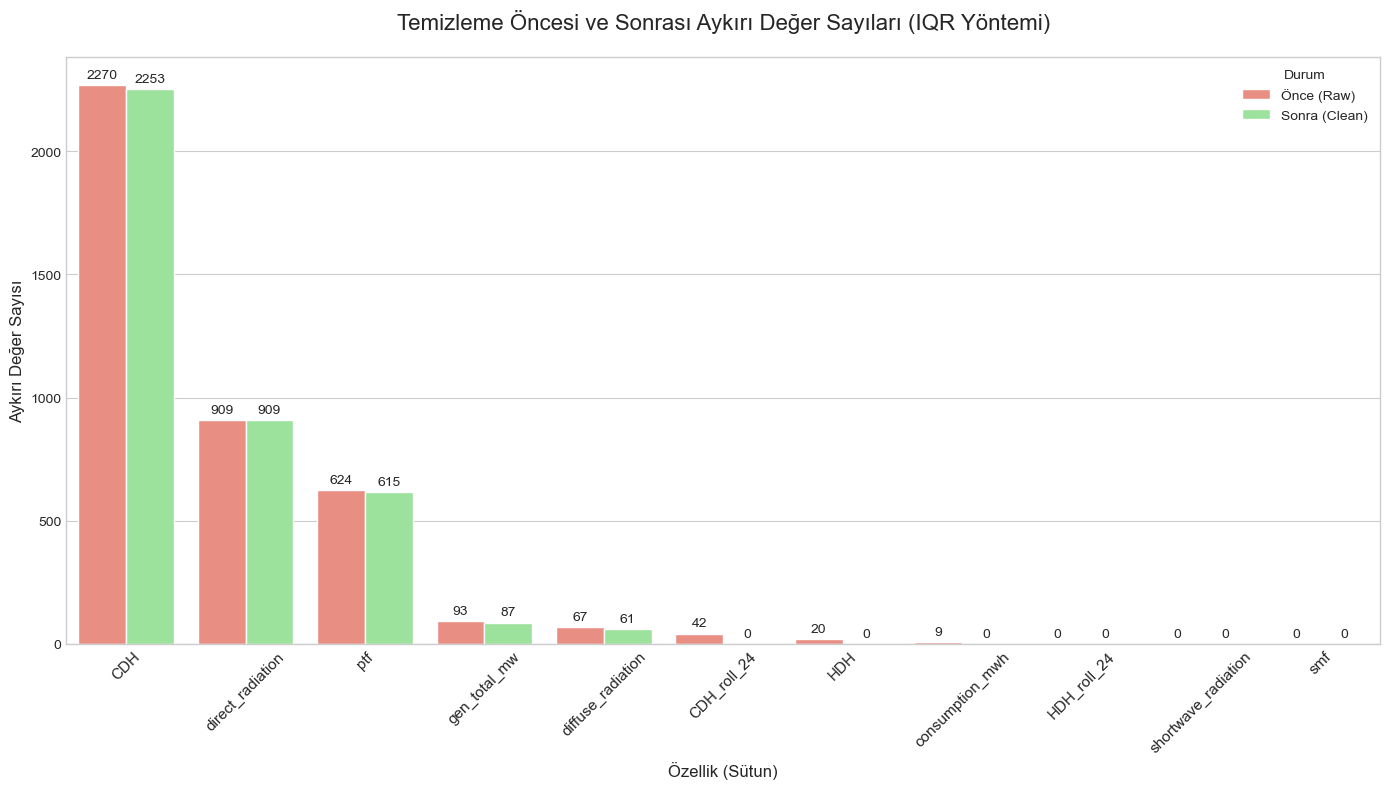

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

key_outlier_cols = [
    "ptf", "smf", "shortwave_radiation", "direct_radiation", "diffuse_radiation",
    "CDH", "HDH", "CDH_roll_24", "HDH_roll_24", "gen_total_mw", "consumption_mwh"
]
# Not: summarize_outliers fonksiyonunun önceden tanımlandığını varsayıyoruz.
summary_raw = summarize_outliers(df_raw, key_outlier_cols, z_thresh=3.5).rename(
    columns={"iqr_outliers": "iqr_raw", "robust_z_outliers": "robust_z_raw"}
)
summary_clean = summarize_outliers(df_clean, key_outlier_cols, z_thresh=3.5).rename(
    columns={"iqr_outliers": "iqr_clean", "robust_z_outliers": "robust_z_clean"}
)
outlier_compare = summary_raw.merge(summary_clean, on="col", how="outer").fillna(0).sort_values("iqr_raw", ascending=False)
display(outlier_compare)


# --- GÖRSELLEŞTİRME ---

# Sadece IQR aykırı değerlerini görselleştirelim (genellikle daha yorumlanabilir)
plot_data = outlier_compare.melt(
    id_vars='col', 
    value_vars=['iqr_raw', 'iqr_clean'], 
    var_name='state', 
    value_name='outlier_count'
)

# 'raw' ve 'clean' etiketlerini daha anlaşılır yapalım
plot_data['state'] = plot_data['state'].map({'iqr_raw': 'Önce (Raw)', 'iqr_clean': 'Sonra (Clean)'})

# Grafik Çizimi
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

sns.barplot(
    data=plot_data,
    x='col',
    y='outlier_count',
    hue='state',
    ax=ax,
    palette={'Önce (Raw)': 'salmon', 'Sonra (Clean)': 'lightgreen'}
)

# Grafik Detayları
ax.set_title('Temizleme Öncesi ve Sonrası Aykırı Değer Sayıları (IQR Yöntemi)', fontsize=16, pad=20)
ax.set_xlabel('Özellik (Sütun)', fontsize=12)
ax.set_ylabel('Aykırı Değer Sayısı', fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=11)
ax.legend(title='Durum')

# Barların üzerine sayıları ekle (isteğe bağlı ama çok faydalı)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

### En Etkili Temizlik (IQR Yöntemine Göre)

- **CDH_roll_24**, **HDH** ve **consumption_mwh** sütunlarında:
  - `iqr_raw` sırasıyla **42**, **20** ve **9**
  - `iqr_clean` **0**’a düşmüş  
  ➜ Uygulanan temizleme prosedürü (winsorize/clipping) bu sütunlardaki **IQR tabanlı aykırı değerleri tamamen ortadan kaldırmış**. 

- **gen_total_mw** için aykırı değer sayısı **93 → 87**,  
  ➜ **Kısmi bir iyileşme** var.

---

### Kısmen Etkili veya Hassas Temizlik

- **ptf (hedef değişken)** için aykırı değer sayısı **624 → 615** (çok küçük azalma).  
  ➜ Temizleme, fiyatlardaki aşırı **spike**’ları tamamen yok etmek yerine **en uç noktaları hafifçe törpülüyor**.  
  ➜ Fiyat volatilitesi model için **öğrenilmesi gereken bir sinyal**; aşırı temizlik bu bilgiyi yok edebilir.

---

### Robust Z-Skoru ve IQR Arasındaki Fark

- **CDH**, **direct_radiation**, **shortwave_radiation** gibi sütunlarda:
  - **robust_z**’ye göre **binlerce** aykırı değer varken,
  - **IQR**’a göre **daha az** aykırı değer var.

- Nedeni: İki yöntemin **aykırı tanımı** farklı; **robust z-skoru medyandan sapmalara** daha duyarlı.

- Temizlik sonrası **robust_z_clean** sayılarında küçük azalmalar:
  - **smf:** 699 → **694**
  - **direct_radiation:** 6711 → **6676**

  ➜ Buna rağmen robust z-skoruna göre **hala çok sayıda aykırı** var; strateji öncelikle **IQR tabanlı aykırılıkları** hedefliyor.

---

### Model İçin Anlamı

- Bazı özelliklerdeki (özellikle **ptf**) **doğal varyasyon korunmuş**,
- Sadece **en aşırı** ve muhtemelen **hatalı** değerler düzeltilmiş.
- Sonuç: Model, **gürültüden arındırılmış** ama **önemli sinyali koruyan** dengeli bir veri setiyle eğitilir.


## 3) Mevsimsellik ve Trend Analizi



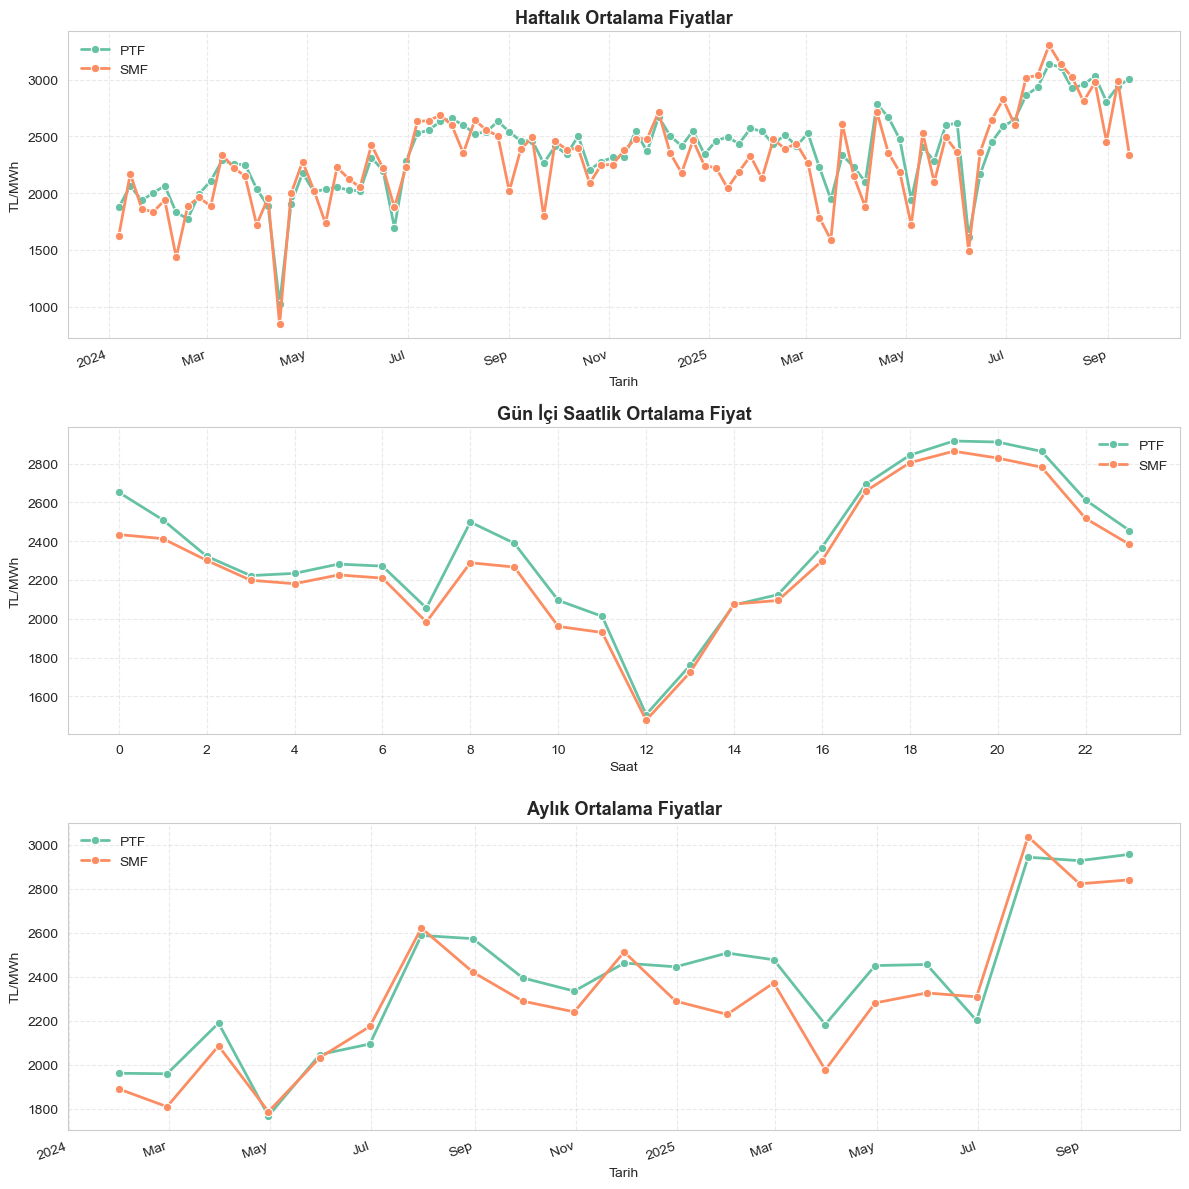

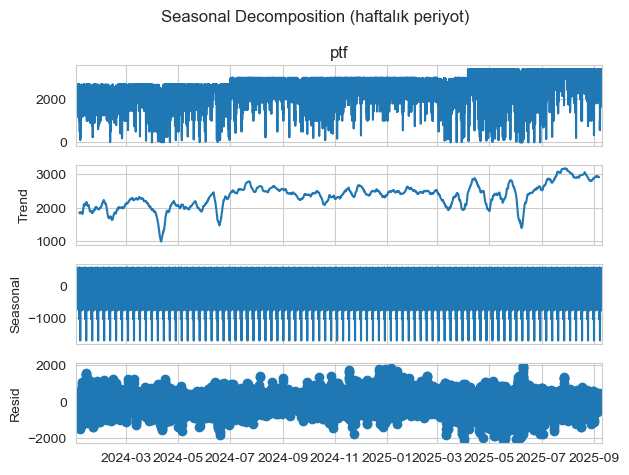

In [76]:
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style("whitegrid")

df_plot = df_clean.copy().sort_values("timestamp")

value_cols = [TARGET]
if "smf" in df_plot.columns and "smf" not in value_cols:
    value_cols.append("smf")

label_map = {col: col.upper() for col in value_cols}

weekly = df_plot.set_index("timestamp")[value_cols].resample("W").mean().reset_index()
monthly = df_plot.set_index("timestamp")[value_cols].resample("M").mean().reset_index()
hourly = (
    df_plot.assign(hour=df_plot["timestamp"].dt.hour)
    .groupby("hour")[value_cols]
    .mean()
    .reset_index()
)

for frame in (weekly, monthly):
    if "timestamp" in frame:
        ts = pd.to_datetime(frame["timestamp"], errors="coerce")
        if getattr(ts.dt, "tz", None) is not None:
            frame["timestamp"] = ts.dt.tz_localize(None)
        else:
            frame["timestamp"] = ts

palette = sns.color_palette("Set2", n_colors=len(value_cols))

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)
plot_specs = [
    (weekly, "timestamp", "Haftalık Ortalama Fiyatlar"),
    (hourly, "hour", "Gün İçi Saatlik Ortalama Fiyat"),
    (monthly, "timestamp", "Aylık Ortalama Fiyatlar"),
]

for ax, (data, x_col, title) in zip(axes, plot_specs):
    for idx, col in enumerate(value_cols):
        sns.lineplot(
            data=data,
            x=x_col,
            y=col,
            ax=ax,
            marker="o",
            linewidth=2,
            color=palette[idx],
            label=label_map.get(col, col.upper()),
        )
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_ylabel("TL/MWh")
    ax.grid(True, linestyle="--", alpha=0.4)
    if x_col == "hour":
        ax.set_xlabel("Saat")
        ax.set_xticks(range(0, 24, 2))
    else:
        ax.set_xlabel("Tarih")
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        for label in ax.get_xticklabels():
            label.set_rotation(20)
            label.set_horizontalalignment("right")
    if len(value_cols) > 1:
        ax.legend(frameon=False)
    else:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

plt.tight_layout()
plt.show()

if seasonal_decompose is None:
    print("statsmodels bulunamadı: seasonal decomposition atlandı.")
else:
    hourly_series = df_clean.set_index("timestamp")[TARGET].asfreq("H")
    hourly_series = hourly_series.fillna(method="ffill")
    try:
        decomposition = seasonal_decompose(hourly_series, model="additive", period=24 * 7)
        decomposition.plot()
        plt.suptitle("Seasonal Decomposition (haftalık periyot)")
        plt.tight_layout()
        plt.show()
    except Exception as exc:
        print("Seasonal decomposition başarısız:", exc)

### PTF–SMF Görsel Notları

### 1) Haftalık Ortalama Fiyatlar
- **PTF ve SMF birlikte hareket ediyor; korelasyon yüksek.** Çoğu haftada fark (spread) sınırlı.
- **Nisan–Mayıs 2024 civarı** kısa süreli sert düşüş haftaları var (olay/spike sonrası düzeltme gibi).
- **Yaz 2025’te** belirgin bir **yukarı rejim** (2600→3000+) gözleniyor; haftalık oynaklık da artmış.
- **Spreads (PTF–SMF)**: Genel olarak küçük; ancak **düşük seviye haftalarda** ve **yüksek seviye haftalarda** yayılma biraz artıyor → spread’in **rejim/level-dependent** olabileceğine işaret.

---

### 2) Gün İçi Saatlik Ortalama
- **Tipik gün içi desen:** Gece yarısından sabaha **azalan**, öğleden sonra **yükselen**, **18–20** saatlerinde tepe yapan **akşam zirvesi**; sonra tekrar düşüş.
- **PTF ≈ SMF**, ama **akşam saatlerinde PTF hafifçe daha yüksek**; sabah/öğlene doğru fark azalıyor.
- **15–17** saat bandında yükselişin başladığı görülüyor; **20** civarı zirve (≈ 2800–2900), **13–14**’te dip (≈ 1500–1700).

---

### 3) Aylık Ortalama Fiyatlar
- **2024 ilkbahar**: nispeten düşük/orta seviye (≈ 1800–2200).
- **2024 yaz sonu–sonbahar**: artış (≈ 2400–2600).
- **2025 yaz**: belirgin **rejim değişimi**; **Ağustos–Eylül 2025**’te **3000 civarı** bir plato.
- SMF ay ortalamaları PTF’i yakından takip ediyor; bazı aylarda **SMF biraz daha düşük**.

---

### 4) Seasonal Decomposition (haftalık periyot, PTF)
- **Trend:** 2024→2025 boyunca dalgalı ama **yukarı eğilimli**, ara sıra derin çukurlar (olay/şok).
- **Seasonal (haftalık):** Güçlü, **sabit genlikli** haftalık ritim (hafta içi–hafta sonu farkı). **Additive** ayrıştırma makul.
- **Resid:** Yüksek oynaklık ve **olay temelli spike’lar** kalıyor → mevsimsellik dışı faktörlerin (tatiller, üretim/iletim şokları) etkisi sürüyor; **heteroskedastisite** ihtimali.

---

**Özet:** PTF–SMF ikilisi; güçlü **haftalık/saatlik mevsimsellik**, **rejimsel trend** ve **olay kaynaklı spike** katmanlarından oluşuyor.

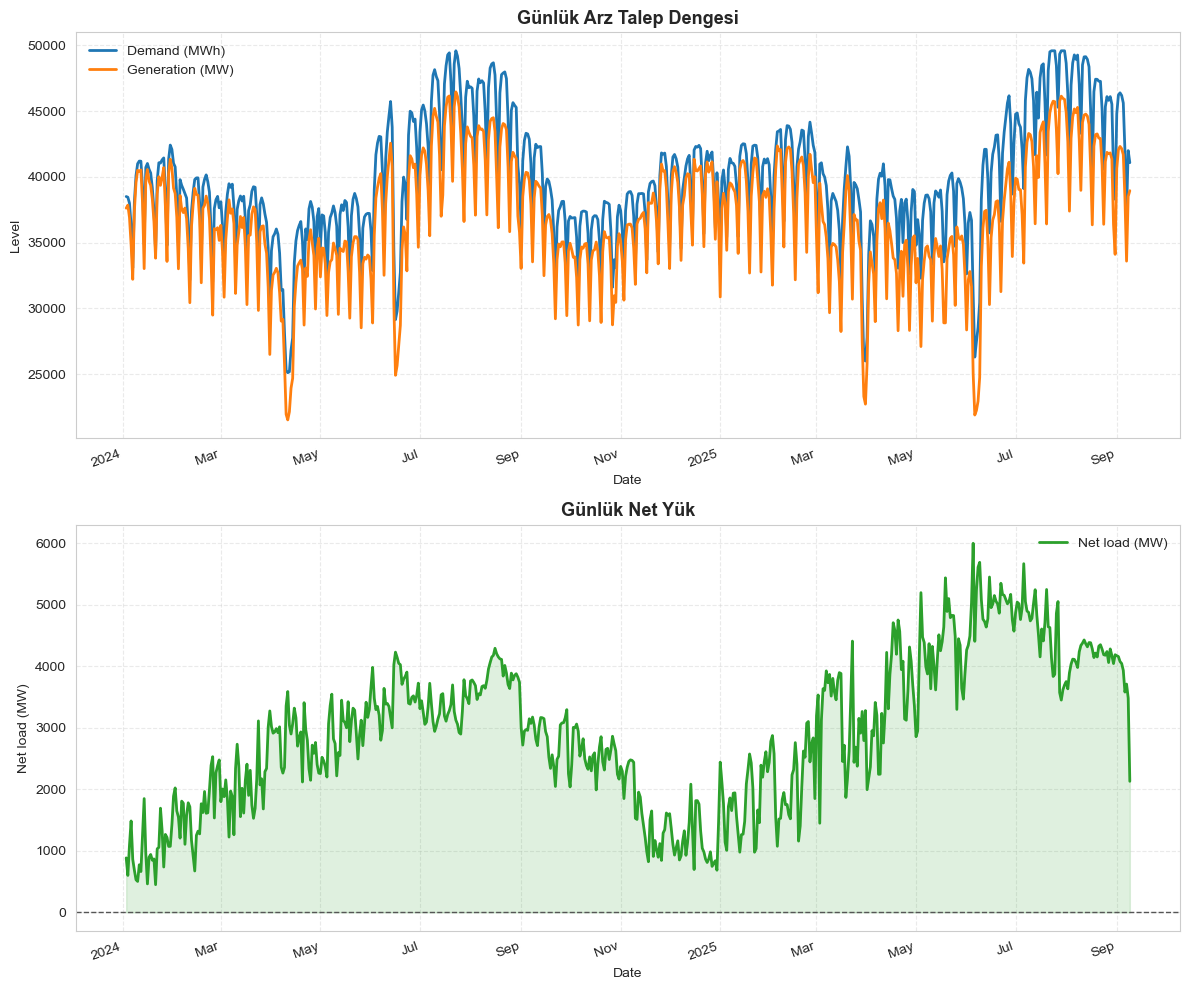

In [70]:
import matplotlib.dates as mdates

sns.set_style("whitegrid")

available_cols = set(df_clean.columns)
has_gen = "gen_total_mw" in available_cols
has_cons = "consumption_mwh" in available_cols

if not (has_gen or has_cons):
    print("Production/consumption columns are missing.")
else:
    daily = df_clean.set_index("timestamp").resample("D").mean().reset_index()
    if "timestamp" in daily:
        ts = pd.to_datetime(daily["timestamp"], errors="coerce")
        if getattr(ts.dt, "tz", None) is not None:
            daily["timestamp"] = ts.dt.tz_localize(None)
        else:
            daily["timestamp"] = ts
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)
    if has_cons and has_gen:
        sns.lineplot(data=daily, x="timestamp", y="consumption_mwh", ax=axes[0],
                     label="Demand (MWh)", color="#1f77b4", linewidth=2)
        sns.lineplot(data=daily, x="timestamp", y="gen_total_mw", ax=axes[0],
                     label="Generation (MW)", color="#ff7f0e", linewidth=2)
        axes[0].set_ylabel("Level")
        axes[0].legend(frameon=False)
    elif has_cons:
        sns.lineplot(data=daily, x="timestamp", y="consumption_mwh", ax=axes[0],
                     color="#1f77b4", linewidth=2)
        axes[0].set_ylabel("Demand (MWh)")
    else:
        sns.lineplot(data=daily, x="timestamp", y="gen_total_mw", ax=axes[0],
                     color="#ff7f0e", linewidth=2)
        axes[0].set_ylabel("Generation (MW)")
    axes[0].set_title("Günlük Arz Talep Dengesi", fontsize=13, fontweight="bold")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].set_xlabel("Date")
    axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[0].xaxis.get_major_locator()))
    for label in axes[0].get_xticklabels():
        label.set_rotation(20)
        label.set_horizontalalignment("right")

    net_col = None
    if "net_load_mw" in daily.columns:
        net_col = "net_load_mw"
    elif has_cons and has_gen:
        daily["net_load_mw_calc"] = daily["consumption_mwh"] - daily["gen_total_mw"]
        net_col = "net_load_mw_calc"

    if net_col is not None:
        sns.lineplot(data=daily, x="timestamp", y=net_col, ax=axes[1],
                     color="#2ca02c", linewidth=2, label="Net load (MW)")
        axes[1].fill_between(daily["timestamp"], 0, daily[net_col],
                             where=(daily[net_col] >= 0), alpha=0.15, color="#2ca02c")
        axes[1].axhline(0, color="#555", linestyle="--", linewidth=1)
        axes[1].set_ylabel("Net load (MW)")
        axes[1].legend(frameon=False)
    else:
        axes[1].text(0.5, 0.5, "Net load not available",
                    transform=axes[1].transAxes, ha="center", va="center")
        axes[1].set_axis_off()
    axes[1].set_title("Günlük Net Yük", fontsize=13, fontweight="bold")
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].set_xlabel("Date")
    axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[1].xaxis.get_major_locator()))
    for label in axes[1].get_xticklabels():
        label.set_rotation(20)
        label.set_horizontalalignment("right")
    plt.tight_layout()
    plt.show()

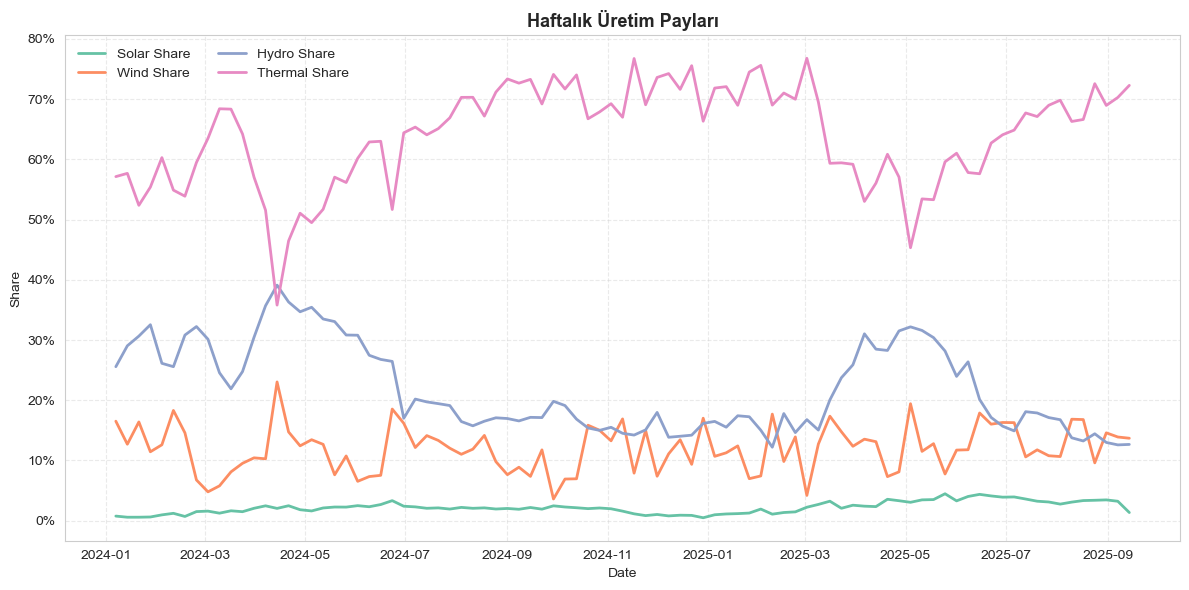

In [68]:
from matplotlib.ticker import PercentFormatter

sns.set_style("whitegrid")

mix_cols = [
    col for col in ["solar_share", "wind_share", "hydro_share", "thermal_share"]
    if col in df_clean.columns
]

if not mix_cols:
    print("Generation mix share columns are missing.")
else:
    weekly_mix = df_clean.set_index("timestamp")[mix_cols].resample("W").mean().reset_index()
    if "timestamp" in weekly_mix:
        ts = pd.to_datetime(weekly_mix["timestamp"], errors="coerce")
        if getattr(ts.dt, "tz", None) is not None:
            weekly_mix["timestamp"] = ts.dt.tz_localize(None)
        else:
            weekly_mix["timestamp"] = ts
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("Set2", n_colors=len(mix_cols))
    for idx, col in enumerate(mix_cols):
        sns.lineplot(
            data=weekly_mix,
            x="timestamp",
            y=col,
            linewidth=2,
            color=palette[idx],
            label=col.replace("_", " ").title(),
        )
    plt.title("Haftalık Üretim Payları", fontsize=13, fontweight="bold")
    plt.ylabel("Share")
    plt.xlabel("Date")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(frameon=False, ncol=min(len(mix_cols), 2))
    plt.tight_layout()
    plt.show()

    renewable_cols = [col for col in ["renewable_mw", "thermal_mw"] if col in df_clean.columns]
    if renewable_cols:
        weekly_levels = df_clean.set_index("timestamp")[renewable_cols].resample("W").mean().reset_index()
        if "timestamp" in weekly_levels:
            ts = pd.to_datetime(weekly_levels["timestamp"], errors="coerce")
            if getattr(ts.dt, "tz", None) is not None:
                weekly_levels["timestamp"] = ts.dt.tz_localize(None)
            else:
                weekly_levels["timestamp"] = ts
        plt.figure(figsize=(12, 5))
        for col in renewable_cols:
            sns.lineplot(
                data=weekly_levels,
                x="timestamp",
                y=col,
                linewidth=2,
                label=col.replace("_", " ").title(),
            )
        plt.title("Weekly generation levels", fontsize=13, fontweight="bold")
        plt.ylabel("MW")
        plt.xlabel("Date")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.show()

### Grafik 1 — Günlük Arz–Talep Dengesi & Net Yük

### a) Arz–Talep (üst panel)
- **Demand** ve **Generation** birlikte dalgalanıyor; **yaz aylarında (özellikle 2025 yazı)** talebin yükseldiği net.
- **Hafta içi–hafta sonu** ritmi belirgin: haftasonlarında hem talep hem üretim düşüyor.
- Bazı dönemlerde üretim talebin **kalıcı olarak altında** kalıyor → sistemin geri kalanını **ithalat, rezervuar çekişi, tepe yük santralleri veya talep tarafı esneklik** karşılıyor olabilir.
- İlkbahar 2024 ve 2025’te **kısa süreli derin düşüşler** (bakım/arıza, hidrolik geçişleri, tatil etkileri vb.) dikkat çekiyor.

### b) Net Yük (alt panel)
- **Net load = Demand − Generation** şeklinde tanımlanan seri, 2024’ten 2025 yazına **artan eğilim** gösteriyor; **yaz 2025’te tepe (≈ 4–6 GW)**.
- **CDH (soğutma derece saatleri)** arttıkça net yük de yükseliyor; yaz serinledikçe düşüş başlıyor.
- Seride **geniş bantlı oynaklık** mevcut → olay temelli şoklar (sıcak hava dalgaları, baraj rejimi, planlı/plan dışı kesintiler).

---

### Grafik 2 — Haftalık Üretim Payları (Solar / Wind / Hydro / Thermal)

### Gözlemler
- **Thermal payı** çoğu haftada **%60–75** bandında; **hidrolik arttığında** (ilkbahar–erken yaz 2025) **termal pay geriliyor** → **yer değiştirme etkisi** bariz.
- **Hydro payı** mevsimsel: **ilkbaharda zirve (%30+), yaz sonu–kışa** doğru düşüş.
- **Wind** oynak ama **%8–18** aralığında; **Synoptic rüzgâr rejimleri** ile hızlı salınımlar var.
- **Solar** payı düşük ama **kademeli artış** eğiliminde (**%1 → %4–5**), yaz aylarında daha görünür.

### Çıkarımlar
- Sistem seviyesi **fiyat rejimi**, büyük ölçüde **termal marjinal üretimin** ağırlığıyla ilişkili:
  - **Thermal ↑** → yakıt maliyeti/CO₂ etkisiyle **fiyat seviyeleri ↑** eğilimli,
  - **Hydro ↑** → marjinal maliyet düştüğünden **fiyatlar ↓** eğilimli.
- **Rüzgâr/solar belirsizliği**, saatlik oynaklığı ve **spike** riskini besliyor (özellikle akşam saatlerinde solar çekildiğinde).

---

### Kısa Özet
- **Grafik 1**: Talep yazın artıyor; üretim her zaman aynı hızla eşlik etmiyor → **net yük yükseliyor** ve pik saat riskleri büyüyor.
- **Grafik 2**: **Hidro mevsimselliği** fiyat seviyesini yumuşatırken, **termal ağırlık** arttığında fiyatlar yukarı eğilimli; **rüzgâr/solar** oynaklığı saatlik riskleri artırıyor.  

## 4) Korelasyon (sayısal alt küme)



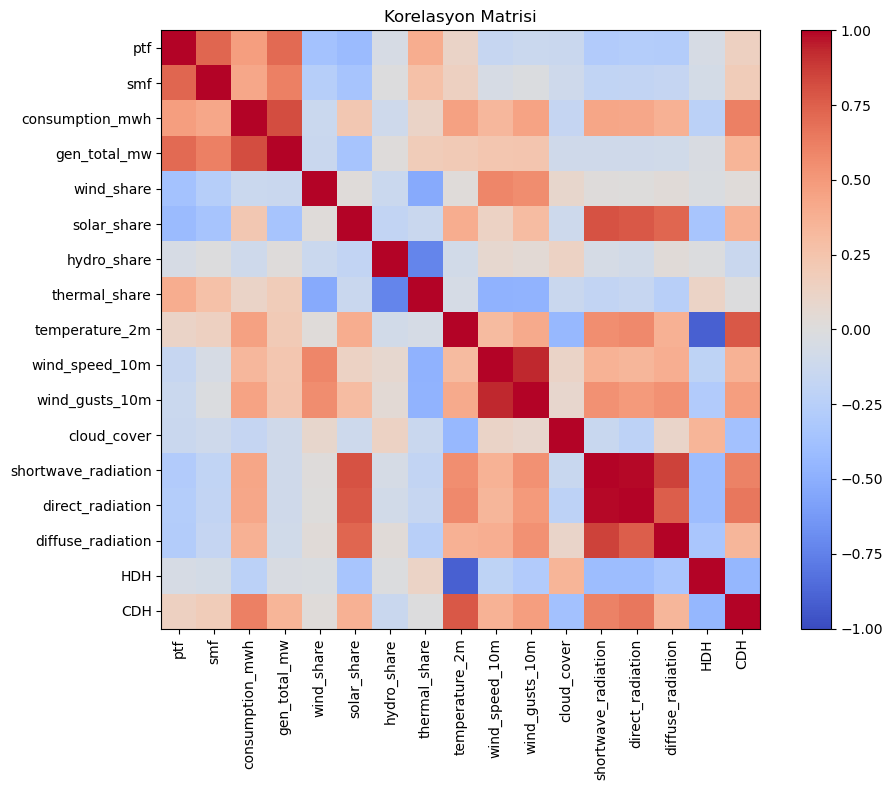

ptf       smf  consumption_mwh  gen_total_mw  wind_share  solar_share  hydro_share  thermal_share  temperature_2m  wind_speed_10m  wind_gusts_10m  \
ptf              1.000000  0.723178         0.469683      0.709910   -0.364326    -0.417070    -0.050505       0.393045        0.111673       -0.162461       -0.131160   
smf              0.723178  1.000000         0.423890      0.612352   -0.261711    -0.346920    -0.001276       0.265768        0.141865       -0.050738       -0.022631   
consumption_mwh  0.469683  0.423890         1.000000      0.816816   -0.128564     0.226091    -0.109248       0.110347        0.453995        0.334268        0.450124   
gen_total_mw     0.709910  0.612352         0.816816      1.000000   -0.137618    -0.349790     0.008454       0.179914        0.200535        0.227086        0.240792   
wind_share      -0.364326 -0.261711        -0.128564     -0.137618    1.000000     0.019174    -0.125846      -0.528045        0.022336        0.592230        0.556406   
solar_share     -0.417070 -0.346920         0.226091     -0.349790    0.019174     1.000000    -0.187215      -0.137771        0.397596        0.132085        0.302800   
hydro_share     -0.050505 -0.001276        -0.109248      0.008454   -0.125846    -0.187215     1.000000      -0.728255       -0.081761        0.076505        0.039250   
thermal_share    0.393045  0.265768         0.110347      0.179914   -0.528045    -0.137771    -0.728255       1.000000       -0.057750       -0.477464       -0.471755   
temperature_2m   0.111673  0.141865         0.453995      0.200535    0.022336     0.397596    -0.081761      -0.057750        1.000000        0.304855        0.408367   
wind_speed_10m  -0.162461 -0.050738         0.334268      0.227086    0.592230     0.132085     0.076505      -0.477464        0.304855        1.000000        0.931684   

                 cloud_cover  shortwave_radiation  direct_radiation  diffuse_radiation       HDH       CDH  
ptf                -0.138934            -0.284468         -0.269749          -0.275935 -0.048883  0.141128  
smf                -0.107741            -0.190520         -0.185766          -0.169217 -0.063378  0.184405  
consumption_mwh    -0.167698             0.430830          0.423503           0.371662 -0.229313  0.610564  
gen_total_mw       -0.095317            -0.100424         -0.097474          -0.090694 -0.031762  0.347189  
wind_share          0.092458             0.013212          0.007621           0.027829 -0.023524  0.019483  
solar_share        -0.115974             0.801680          0.778124           0.722420 -0.337400  0.368117  
hydro_share         0.127463            -0.059237         -0.083075           0.024798 -0.009499 -0.136753  
thermal_share      -0.134852            -0.187341         -0.156521          -0.246207  0.119837 -0.000123  
temperature_2m     -0.439519             0.547728          0.570689           0.373989 -0.901373  0.777942  
wind_speed_10m      0.111463             0.367076          0.338926           0.383665 -0.207578  0.366495

In [15]:
subset_cols = [
    "ptf", "smf", "consumption_mwh", "gen_total_mw", "wind_share", "solar_share",
    "hydro_share", "thermal_share", "temperature_2m", "wind_speed_10m", "wind_gusts_10m",
    "cloud_cover", "shortwave_radiation", "direct_radiation", "diffuse_radiation",
    "HDH", "CDH", "renewable_mw", "thermal_mw", "net_load_mw"
]
subset = [c for c in subset_cols if c in df_clean.columns]
if subset:
    corr = df_clean[subset].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, interpolation="nearest", cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(subset)), subset, rotation=90)
    plt.yticks(range(len(subset)), subset)
    plt.title("Korelasyon Matrisi")
    plt.tight_layout()
    plt.show()
    display(corr.head(10))
else:
    print("Korelasyon için uygun sayısal kolon bulunamadı.")

### Korelasyon Matrisi

### 1) Fiyatlarla (PTF/SMF) ilişkiler

- **PTF ~ SMF:** `0.72` → kuvvetli birlikte hareket (spread modeline uygun zemin).
- **PTF ~ gen_total_mw:** `0.71` → toplam üretim seviyesi yükseldikçe PTF de yükselme eğiliminde (rejim/olay etkisi).
- **PTF ~ paylar:**
  - **Thermal_share:** `+0.39` (en yüksek pozitif) → **termal ağırlık arttıkça fiyat artma eğiliminde** (yakıt/CO₂ marjinal maliyet etkisi).
  - **Wind_share:** `−0.36`, **Solar_share:** `−0.42` → yenilenebilir payı arttıkça fiyatlar düşme eğiliminde (**yer değiştirme** etkisi).
  - **Hydro_share:** `−0.05` (zayıf) → hidro etkisi pay bazında daha zayıf görülmüş (ancak dönemsel seviyelerle etkileşimli olabilir).
- **PTF ~ meteoroloji:**
  - **Sıcaklık:** `+0.11` (zayıf tek başına), **bulutluluk:** `−0.14`, **radyasyonlar:** `≈ −0.27` → güneşleşme arttıkça fiyat düşme eğiliminde (solar arzı üzerinden).
  - **Rüzgâr hızı:** `−0.16` → rüzgâr arttıkça fiyat düşme eğiliminde (wind_share kanalı).

**SMF** tarafında işaretler aynı, büyüklükler biraz daha düşük.

---

### 2) Talep, Üretim ve Meteoroloji

- **consumption_mwh ~ gen_total_mw:** `0.82` (çok güçlü) → sistem dengesi.  
- **consumption_mwh ~ sıcaklık:** `0.45`, **CDH:** `0.61`, **HDH:** `−0.23` → **soğutma ihtiyacı** talebi belirgin artırıyor (yaz yükü).  
- **gen_total_mw ~ CDH:** `0.35` → yüksek sıcaklıklarda üretim seviyesi de yükseliyor (tepe yük santralleri devreye giriyor olabilir).

---

### 3) Üretim Paylarının Birbirleriyle İlişkisi

- **Thermal ↔ Hydro:** `−0.73` (çok güçlü negatif) → tipik **yer değiştirme** (hidro yüksekse termal düşüyor).  
- **Thermal ↔ Wind:** `−0.53` → rüzgâr bolken termal pay azalıyor.  
- **Solar_share ↔ radyasyonlar:** `shortwave 0.80`, `direct 0.78`, `diffuse 0.72` → **kuvvetli ortak bilgi** (çoklu doğrusal bağlantı riski).
- **Wind_share ↔ rüzgâr metrikleri:** `wind_speed 0.59`, `gusts 0.56` → beklenen yönde.

---

### 4) Meteorolojik ilişkiler (fiziksel tutarlılık kontrolü)

- **Sıcaklık ↔ CDH:** `0.78`, **Sıcaklık ↔ HDH:** `−0.90` → beklenen güçlü ilişkiler.  
- **Sıcaklık ↔ bulutluluk:** `−0.44`, **Sıcaklık ↔ radyasyonlar:** `0.37–0.57` → güneşli ve sıcak günler.  
- **Rüzgâr hızı ↔ esinti (gusts):** `0.93` (ölçüm tutarlılığı).

---

**Özet:** PTF/SMF **termal ağırlık arttığında yükseliyor**, **yenilenebilir payı arttığında düşüyor**; talep ve üretim **sıcaklık/soğutma** ile güçlü bağa sahip.

## 5) Temizlik (NA/duplicate)



In [17]:
print("Temiz veri duplicate kontrolü:", df_clean.duplicated(subset=["timestamp"]).sum())
print("Temiz veri NA toplamı:", int(df_clean.isna().sum().sum()))
print("OutlierCleaner saatlik eşik setleri:", {col: len(thr) for col, thr in cleaner.hourly_thresholds.items()})

Temiz veri duplicate kontrolü: 0
Temiz veri NA toplamı: 0
OutlierCleaner saatlik eşik setleri: {'ptf': 24, 'smf': 24, 'shortwave_radiation': 24, 'direct_radiation': 24, 'diffuse_radiation': 24, 'CDH': 24, 'HDH': 24, 'CDH_roll_24': 24, 'HDH_roll_24': 24, 'solar_cf_proxy': 24, 'gen_total_mw': 24, 'consumption_mwh': 24}


## 6) Özellik Mühendisliği (Causal, leakage yok)



In [19]:
df = df_clean.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
df_fe = build_feature_frame(df, target=TARGET, extra_targets=("smf",), drop_rows=48)
print("FE sonrası şekil:", df_fe.shape)
df_fe.head(3)

FE sonrası şekil: (14710, 118)


timestamp      ptf      smf  consumption_mwh  gen_total_mw  wind_share   solar_share  hydro_share  thermal_share  is_holiday  temperature_2m  \
0 2024-01-06 01:00:00+03:00  2247.99  1800.00         32952.58      32896.60    0.113321  3.039828e-07     0.251260       0.635418       False            8.19   
1 2024-01-06 02:00:00+03:00  2295.32  2295.32         31707.28      31649.23    0.131863  3.159635e-07     0.236318       0.631819       False            7.80   
2 2024-01-06 03:00:00+03:00  2149.98  2149.98         30919.94      30860.48    0.142410  3.240390e-07     0.219943       0.637646       False            7.65   

   relative_humidity_2m  wind_speed_10m  wind_gusts_10m  cloud_cover  shortwave_radiation  direct_radiation  diffuse_radiation    HDH  CDH  HDH_roll_24  CDH_roll_24  \
0                 71.20            9.79          17.545        42.60                  0.0               0.0                0.0   9.81  0.0      176.655          0.0   
1                 70.30           10.65          18.415        44.55                  0.0               0.0                0.0  10.20  0.0      179.715          0.0   
2                 69.85           11.37          19.830        37.05                  0.0               0.0                0.0  10.35  0.0      182.380          0.0   

   solar_cf_proxy  hour  dow  month  hour_sin  hour_cos   dow_sin   dow_cos  month_sin  month_cos  ptf_lag_1  ptf_lag_24  ptf_roll24_mean  smf_lag_1  smf_lag_24  smf_roll24_mean  \
0             0.0     1    5      1  0.258819  0.965926 -0.974928 -0.222521        0.5   0.866025    2295.00     1694.17      2359.267500    1751.00       800.0      1515.750833   
1             0.0     2    5      1  0.500000  0.866025 -0.974928 -0.222521        0.5   0.866025    2247.99     1800.01      2382.343333    1800.00       700.0      1557.417500   
2             0.0     3    5      1  0.707107  0.707107 -0.974928 -0.222521        0.5   0.866025    2295.32     1999.99      2402.981250    2295.32       700.0      1623.889167   

   consumption_mwh_lag_1  consumption_mwh_lag_24  consumption_mwh_roll24_mean  smf_roll24_std  smf_roll24_diff  smf_diff_1  smf_diff_24  consumption_lag_1  consumption_lag_24  \
0               34877.41                32636.28                 38021.452083      619.323250       235.249167     -100.00       901.01           34877.41            32636.28   
1               32952.58                31526.25                 38034.631250      602.485478       242.582500       49.00      1000.00           32952.58            31526.25   
2               31707.28                30881.11                 38042.174167      591.682679       671.430833      495.32      1595.32           31707.28            30881.11   

   consumption_roll24_mean  consumption_roll24_std  consumption_roll24_diff  consumption_diff_1  consumption_diff_24  ptf_roll24_std  ptf_roll24_diff  ptf_diff_1  ptf_diff_24  \
0             38021.452083             4492.403946             -3144.042083            -2095.79               387.66      280.898389       -64.267500        6.99       945.01   
1             38034.631250             4476.354113             -5082.051250            -1924.83               316.30      244.241324      -134.353333      -47.01       553.82   
2             38042.174167             4465.048532             -6334.894167            -1245.30               181.03      211.647445      -107.661250       47.33       495.31   

   shortwave_radiation_log1p  direct_radiation_log1p  diffuse_radiation_log1p  CDH_log1p  HDH_log1p  CDH_roll_24_log1p  HDH_roll_24_log1p  solar_cf_proxy_log1p  is_weekend  \
0                        0.0                     0.0                      0.0        0.0   2.380472                0.0           5.179843                   0.0           1   
1                        0.0                     0.0                      0.0        0.0   2.415914                0.0           5.196921                   0.0           1   
2                   

## 7) Train/Test Ayrımı



In [21]:
train = df_fe[df_fe["timestamp"] <= CUT_TS].copy()
test = df_fe[df_fe["timestamp"] > CUT_TS].copy()
print("Train/Test:", train.shape, test.shape)

feat_cols = [c for c in df_fe.columns if c not in ["timestamp", TARGET] and pd.api.types.is_numeric_dtype(df_fe[c])]
print("Özellik sayısı:", len(feat_cols))

X_train = train[feat_cols].fillna(0.0).to_numpy()
y_train = train[TARGET].astype(float).to_numpy()
X_test = test[feat_cols].fillna(0.0).to_numpy()
y_test = test[TARGET].astype(float).to_numpy()

Train/Test: (13007, 118) (1703, 118)
Özellik sayısı: 116


## 8) Baseline Ridge (Scaler'lı Pipeline)



In [23]:
RIDGE_ALPHA_GRID = [0.5, 1.0, 2.0, 5.0, 8.0, 12.0, 20.0, 32.0, 48.0, 64.0]
splits_train = time_series_window_splits(len(train), n_splits=4, test_size=24 * 7)
if not splits_train:
    fallback_test = max(24, len(train) // 6 or 24)
    splits_train = time_series_window_splits(len(train), n_splits=2, test_size=fallback_test)
if not splits_train:
    warnings.warn("Ridge CV skipped (no valid splits); falling back to default alpha", RuntimeWarning)

ridge_cv_rows = []
for alpha in RIDGE_ALPHA_GRID:
    estimator = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=float(alpha)))
    ])
    _, _, metrics = ts_cross_val(estimator, X_train, y_train, splits_train)
    ridge_cv_rows.append({"alpha": alpha, **metrics})

ridge_cv = pd.DataFrame(ridge_cv_rows).sort_values("RMSE") if ridge_cv_rows else pd.DataFrame()
if not ridge_cv.empty:
    display(ridge_cv)
    best_alpha = float(ridge_cv.iloc[0]["alpha"])
else:
    best_alpha = 10.0
print("Seçilen alpha:", best_alpha)

alpha        RMSE         MAE      MAPE%     sMAPE%        R2
0    0.5  331.464894  242.406558  24.353196  28.235837  0.905342
1    1.0  331.499035  242.418650  24.411706  28.201329  0.905322
2    2.0  331.775577  242.770712  24.671044  28.263535  0.905164
3    5.0  332.738299  244.232298  25.610122  28.610333  0.904613
4    8.0  333.513826  245.325361  26.263677  28.409743  0.904168
5   12.0  334.319450  246.399172  26.911985  28.568958  0.903705
6   20.0  335.501916  247.890965  27.813085  28.649583  0.903022
7   32.0  336.761815  249.333269  28.686653  28.872650  0.902292
8   48.0  337.999811  250.578118  29.441363  28.790956  0.901573
9   64.0  338.976573  251.517241  30.004590  28.828859  0.901003

Seçilen alpha: 0.5


### Gözlemler
- **Tatlı nokta 0.5–1.0 aralığı.** Alpha 0.5→1.0 arası metrikler neredeyse aynı; sonrasında (≥2) düzenlileştirme arttıkça **hafif performans kaybı** var.
- **Aşırı düzenlileştirme zararlı:** Alpha 0.5’ten 64’e çıkınca **RMSE ~+7.5**, **MAE ~+9.1**, **R² 0.9053 → 0.9010** (küçük ama tutarlı düşüş).
- **MAPE vs sMAPE:** sMAPE, MAPE’den biraz **daha düşük oynuyor** (ölçek simetrisi nedeniyle); **spike/sağ kuyruk** etkisini sınırlı yansıtıyor.

- Model zaten **iyi açıklıyor (R² ≈ 0.905)**; daha yüksek alpha, **bias’ı artırıp** hatayı büyütüyor.
- Önceki çalışmalarda iyi gözüken **yüksek alpha (~30)** ile kıyasla, bu veri/özellik seti ve **standartlaştırma** altında **daha düşük alpha** daha uygun.

| TEST Metrics   |   Value |
|----------------|---------|
| RMSE           | 264.341 |
| MAE            | 197.296 |
| MAPE%          |   7.041 |
| sMAPE%         |   8.013 |
| R2             |   0.803 |


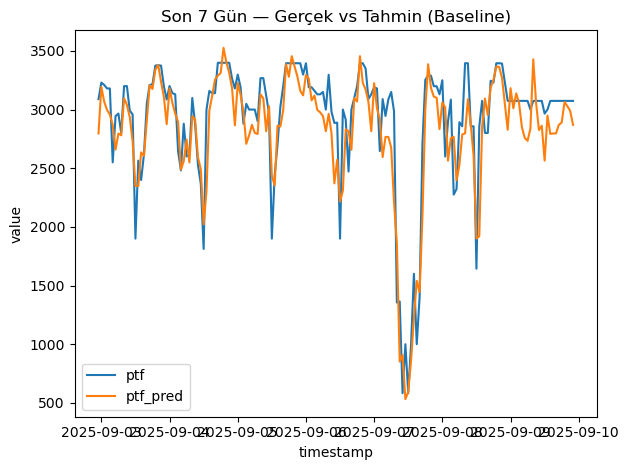

hour        RMSE         MAE      MAPE%     sMAPE%         R2
0      0  180.661388  135.106491   4.041548   4.182311  -1.760336
1      1  181.527561  135.520021   4.118382   4.281432  -0.409560
2      2  180.330914  137.883078   4.408094   4.560768  -0.024864
3      3  230.176266  184.436652   5.962056   6.223839  -0.961226
4      4  249.467161  208.509739   6.885216   7.187124  -0.477304
5      5  297.310631  241.922770   8.020486   8.483921  -0.461145
6      6  317.392451  264.884182   8.972801   9.541693  -0.252475
7      7  366.987704  289.728568  11.840993  12.621955   0.420524
8      8  411.914717  327.037856  11.813810  12.750381   0.601440
9      9  299.634503  220.090659   9.446073  11.012425   0.836484
10    10  264.462675  201.930221   9.363713  11.053622   0.888979
11    11  229.702573  178.536293   7.701603  10.359011   0.918705
12    12  335.532775  259.646088  15.512660  15.275315   0.809651
13    13  337.014464  255.132838  10.777798  12.812274   0.733516
14    14  299.887060  234.775063   9.765220  10.382980   0.816914
15    15  297.713322  214.397573   9.513852  10.730217   0.821125
16    16  257.463796  195.930237   7.023354   7.582791   0.738049
17    17  260.473310  199.731072   6.530063   6.735436   0.264732
18    18  244.195399  173.308517   5.333945   5.523848  -0.497816
19    19  190.384117  139.520339   4.117858   4.251805 -12.491936
20    20  141.983342  108.770816   3.200710   3.248553 -10.286646
21    21  116.918978   87.382170   2.576729   2.639752  -2.986149
22    22  165.991461  132.624850   4.004082   4.117237  -0.471636
23    23  247.968532  208.446417   6.428753   6.727116  -1.347709

In [33]:
from tabulate import tabulate

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("ridge", Ridge(alpha=best_alpha))
])

ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)
metrics_baseline = _metrics_reg(y_test, y_pred)
rows = [(metric, value) for metric, value in metrics_baseline.items()]
print(tabulate(rows, headers=["TEST Metrics", "Value"], tablefmt="github", floatfmt=".3f"))

preds = test[["timestamp", TARGET]].copy()
preds[f"{TARGET}_pred"] = y_pred
preds.to_parquet(os.path.join(RUN_DIR, "preds_baseline.parquet"), index=False)

plot_ts(preds, [TARGET, f"{TARGET}_pred"], "Son 7 Gün — Gerçek vs Tahmin (Baseline)")
hourly_metrics = _hourly_profile(preds, TARGET, f"{TARGET}_pred")
hourly_metrics

### Son 7 Gün – Baseline Performans

### Genel Test Sonuçları
- **RMSE:** 264.3 **MAE:** 197.3 **MAPE:** **%7.04** **sMAPE:** %8.01 **R²:** **0.803**
- **Özet:** Son 7 günde hatalar makul, açıklama gücü yüksek. %7 civarı MAPE kısa ufukta sağlam bir seviye.

---

### Saatlik Tanı (hour-wise)

### Güçlü saatler
- **10–16 arası** (özellikle **11–15**): **R² = 0.74–0.92**, hata düşük.  
  - Gündüz üretim/talep sinyalleri (solar, load) iyi yakalanıyor.

### Orta–zayıf saatler
- **06–09**: RMSE/MAE yükseliyor (sabah rampı).  
- **07–13** bandında (özellikle **12–13**) **MAPE/sMAPE** belirgin artıyor → **öğle çöküşü / ramp kırılımı**.

### Akşam saatleri
- **18–21**: Mutlak hatalar çok düşük (**MAE ≈ 87–174**, **MAPE ≈ %2.6–%5.5**).  
  - **Not:** Buna rağmen tablo’daki **R² değerleri negatif** (örn. 19–21 saatleri). Bu bir **ölçüm/hesaplama artefaktı** olabilir:
    - Saat-bazlı R², o saatteki **SST (hedef varyansı) çok küçük** olduğunda **kararsız/yanıltıcı** olur; küçük mutlak hatalar bile büyük negatif R² doğurabilir.
    - R²’nin saatlik karşılaştırmaya uygun bir **skill score** ile (örn. **Persistence/Naive**’e göre iyileşme) veya **MAE/MAPE** ile değerlendirilmesi daha sağlıklıdır.

---

### Grafik (Gerçek vs Tahmin – son 7 gün)
- Model **seviye ve desen**i takip ediyor; belirgin **dip/spike** olaylarında (tekil saatlerde) hatalar büyüyor fakat **hızlı reversion** iyi yakalanmış.
- Büyük düşüş epizodunda **altı takip** başarılı (over/under-shoot sınırlı).

---

### Kısa Özet
- Genel başarı **iyi** (R²≈0.80, MAPE≈%7).  
- **Sabah rampı** ve **öğle çöküşü** zayıf noktalar; **gündüz/akşam** saatleri güçlü.  
- Saatlik **R² negatifleri** büyük olasılıkla **düşük varyans artefaktı**  

## 8) Hourwise Ridge (24 ayrı model)



In [35]:

RIDGE_ALPHA_CANDIDATES = [2, 5, 8, 12, 20, 40, 60, 120]
MIN_TRAIN_HOURS = 24 * 5
MIN_VALID_HOURS = 24 * 3
DEFAULT_ALPHA = best_alpha

best_alpha_by_hour: Dict[int, float] = {}
rows: List[Dict[str, float]] = []
preds_hourwise: List[pd.DataFrame] = []

for hour in range(24):
    tr_h = train[train["timestamp"].dt.hour == hour].sort_values("timestamp")
    te_h = test[test["timestamp"].dt.hour == hour].sort_values("timestamp")
    if te_h.empty:
        continue
    if len(tr_h) < MIN_TRAIN_HOURS:
        best_alpha_by_hour[hour] = DEFAULT_ALPHA
        continue

    valid_size = min(max(MIN_VALID_HOURS, len(tr_h) // 5), len(tr_h) // 2)
    valid_size = max(24, valid_size)
    if len(tr_h) <= valid_size + 24:
        best_alpha_by_hour[hour] = DEFAULT_ALPHA
        continue

    fit_h = tr_h.iloc[:-valid_size]
    val_h = tr_h.iloc[-valid_size:]

    Xfit = fit_h[feat_cols].fillna(0.0).to_numpy()
    yfit = fit_h[TARGET].astype(float).to_numpy()
    Xval = val_h[feat_cols].fillna(0.0).to_numpy()
    yval = val_h[TARGET].astype(float).to_numpy()
    Xte = te_h[feat_cols].fillna(0.0).to_numpy()
    yte = te_h[TARGET].astype(float).to_numpy()

    scores = []
    for alpha in RIDGE_ALPHA_CANDIDATES:
        mdl = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("ridge", Ridge(alpha=float(alpha)))
        ])
        mdl.fit(Xfit, yfit)
        yval_hat = mdl.predict(Xval)
        scores.append((alpha, _metrics_reg(yval, yval_hat)["RMSE"]))

    if not scores:
        best_alpha_by_hour[hour] = DEFAULT_ALPHA
        continue

    scores.sort(key=lambda x: x[1])
    chosen_alpha = float(scores[0][0])
    best_alpha_by_hour[hour] = chosen_alpha

    mdl = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=chosen_alpha))
    ])
    mdl.fit(tr_h[feat_cols].fillna(0.0), tr_h[TARGET].astype(float))
    yhat_h = mdl.predict(Xte)

    rows.append({"hour": hour, **_metrics_reg(yte, yhat_h)})
    preds_hourwise.append(pd.DataFrame({
        "timestamp": te_h["timestamp"],
        TARGET: yte,
        f"{TARGET}_pred": yhat_h,
        "hour": hour,
    }))

if not rows:
    print("Hourwise training skipped (insufficient history).")
    hourwise_metrics = pd.DataFrame()
else:
    hourwise_metrics = pd.DataFrame(rows).sort_values("hour")
    print("best_alpha_by_hour:", best_alpha_by_hour)
    display(hourwise_metrics)

if preds_hourwise:
    preds_hourwise_df = pd.concat(preds_hourwise, ignore_index=True).sort_values("timestamp")
    preds_hourwise_df.to_parquet(os.path.join(RUN_DIR, "preds_hourwise.parquet"), index=False)

best_alpha_by_hour: {0: 8.0, 1: 2.0, 2: 2.0, 3: 12.0, 4: 5.0, 5: 2.0, 6: 2.0, 7: 2.0, 8: 2.0, 9: 12.0, 10: 40.0, 11: 2.0, 12: 2.0, 13: 5.0, 14: 2.0, 15: 20.0, 16: 5.0, 17: 5.0, 18: 2.0, 19: 20.0, 20: 5.0, 21: 5.0, 22: 8.0, 23: 5.0}


hour        RMSE         MAE      MAPE%     sMAPE%        R2
0      0  127.973342   98.273829   2.953083   3.022219 -0.385066
1      1  102.644144   80.343106   2.468483   2.527924  0.549321
2      2  208.296821  168.272003   5.351912   5.594181 -0.367386
3      3  229.097534  190.097801   6.151099   6.432408 -0.942886
4      4  176.017104  137.243601   4.631455   4.674164  0.264551
5      5  267.439007  210.761043   7.059949   7.418447 -0.182284
6      6  281.736768  233.003966   8.084199   8.416257  0.013124
7      7  455.007967  390.851017  14.665706  16.532081  0.109220
8      8  300.792981  233.982239   9.373771   9.586828  0.787473
9      9  279.415945  202.624160   8.901061  10.275960  0.857807
10    10  258.778652  206.747914   8.888002  11.614091  0.893700
11    11  217.885561  155.065259   6.561599   8.545092  0.926854
12    12  286.838251  227.801153  12.551926  14.753650  0.860891
13    13  297.436771  229.992260   9.682678  11.186949  0.792430
14    14  376.565462  309.753651  13.160206  13.192154  0.711317
15    15  279.025370  208.432464   8.803687  10.370151  0.842877
16    16  268.062933  209.787192   7.519233   7.788812  0.716038
17    17  204.542460  167.508695   5.491641   5.575427  0.546595
18    18  187.955563  138.692881   4.314889   4.332195  0.112652
19    19   79.817327   59.528449   1.758990   1.782934 -1.371413
20    20   57.185601   42.356246   1.247034   1.260490 -0.830895
21    21   46.161843   33.934443   1.001005   1.007165  0.378631
22    22  145.484554  108.965456   3.307909   3.396539 -0.130480
23    23  127.666050   97.222255   3.061424   3.080809  0.377697

### Saat-Bazlı Ridge (best_alpha_by_hour) – Okuma ve Öneriler

### Kısa Özet
- **Saat başına en iyi alpha’lar** değişken: `10: α=40`, `15 & 19: α=20`, `0 & 22: α=8`, çoğu diğer saat **α∈{2,5,12}`.  
- **Gündüz (10–17)** saatlerinde **R² yüksek (0.71–0.93)** ve hatalar makul.  
- **Sabah rampı (07)** ve **öğle çevresi (12–14)** zayıf noktalar (yüksek RMSE/MAPE).  
- **Akşam (19–21)** mutlak hatalar çok düşük olsa da **R² bazı saatlerde negatif**; bu genellikle o saatlerde **hedef varyansının çok küçük olmasından** (skill metriği olarak R²’nin kararsızlaşması) kaynaklı.

---

### Alpha Haritasını Nasıl Okumalı?
- **Büyük α (≥12)** → **yüksek varyans / gürültü** ve/veya **koliner** özellik setinde **daha fazla küçültmeye** ihtiyaç var.  
  - **10. saat (α=40)** ve **15. saat (α=20)**: Öğle/öğleden sonra geçişleri; **solar/wind pay + radyasyon** ailesi koliner → güçlü düzenlileştirme faydalı.
  - **19. saat (α=20)**: Akşam pikine giriş; **CDH × saat** gibi etkileşimler varken yine de shrinkage tercih edilmiş.
- **Küçük α (2–5)** → Özellikler daha **sinyal ağırlıklı**; fazla küçültme zarar verebilir.  
  - Sabah 1–6, akşam 18, gece 21–23 bu gruba yakın.

---

### Saatlik Tanı (öne çıkanlar)
- **07: RMSE 455 / MAPE %14.7 (α=2)** → **sabah rampı**: talep hızlanıyor, rüzgâr/termal ayarlamaları ve net yük rampı kritik.
- **12–14: (α=2,5,2) – MAPE %12.6–13.2** → **öğle çevresi**: solar tepe/çekilme, bulutluluk dalgalanması ve **intra-day solar forecast error** etkisi.
- **10–11–16–17:** **R² 0.72–0.93** (sağlam); `α` orta-büyük (10’da 40) → kolinerliği shrink’le çözmüş.
- **19–21:** **MAE çok düşük** (33–60) fakat **R² negatif/kararsız** → o saatlerde hedef varyansı çok düşük; **MAE/MAPE** ile değerlendirmek daha doğru.

## 9) Walk-forward backtest ve hata analizi (sMAPE)

In [37]:
from tabulate import tabulate

wf_preds, wf_folds, wf_overall = walkforward_backtest(
    train,
    feat_cols,
    TARGET,
    estimator_factory=lambda: Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=best_alpha))
    ]),
    test_hours=168,
    n_folds=6,
)

rows = [(metric, value) for metric, value in wf_overall.items()]
print(tabulate(rows, headers=["WF-O Metrics", "Value"], tablefmt="github", floatfmt=".3f"))

if not wf_folds.empty:
    display(wf_folds)

if wf_preds.empty:
    print("Walk-forward çıktısı bulunamadı. Önceki hücreleri çalıştırdığınızdan emin olun.")
else:
    # Tahminleri diske yaz
    wf_preds.to_parquet(os.path.join(RUN_DIR, "preds_walkforward.parquet"), index=False)

    # Saatlik hata metrikleri
    hourly_rows = []
    for hour, grp in wf_preds.groupby(wf_preds["timestamp"].dt.hour):
        metrics = _metrics_reg(grp[TARGET].values, grp[f"{TARGET}_pred"].values)
        hourly_rows.append({"hour": int(hour), "count": len(grp), **metrics})
    wf_hourly_errors = (
        pd.DataFrame(hourly_rows)
        .sort_values("sMAPE%", ascending=False)
        .reset_index(drop=True)
    )

    print("sMAPE'ye göre en problemli saatler:")
    display(wf_hourly_errors.head(10))

    worst_hours = wf_hourly_errors.loc[wf_hourly_errors["sMAPE%"] > 20, "hour"].tolist()
    if not worst_hours:
        worst_hours = wf_hourly_errors.head(5)["hour"].tolist()

    print("Takip edilecek saatler:", worst_hours)
    print("İlgili saatlerdeki gözlem sayısı:")
    display(
        wf_hourly_errors[
            wf_hourly_errors["hour"].isin(worst_hours)
        ][["hour", "count", "sMAPE%", "RMSE", "MAE"]]
    )

| WF-O Metrics   |   Value |
|----------------|---------|
| RMSE           | 338.463 |
| MAE            | 245.852 |
| MAPE%          |  15.669 |
| sMAPE%         |  24.174 |
| R2             |   0.895 |


fold        RMSE         MAE       MAPE%     sMAPE%        R2
0     1  351.335933  246.054328   10.854427  13.580747  0.835264
1     2  352.749034  259.432620   12.655791  18.521659  0.860437
2     3  352.145640  255.204664  207.987711  54.306360  0.914949
3     4  331.004394  257.348602   14.670480  22.405417  0.886111
4     5  317.258238  233.208923   10.969128  18.951279  0.872315
5     6  324.426656  223.864041   10.036537  17.280292  0.859815

sMAPE'ye göre en problemli saatler:


hour  count        RMSE         MAE       MAPE%     sMAPE%        R2
0    12     42  437.117166  355.501105  125.502798  64.292965  0.612762
1    10     42  402.124269  309.112948  266.268753  51.840295  0.856104
2    13     42  298.525953  224.942771  240.101381  48.872768  0.885982
3    11     42  282.804879  217.494651  199.596979  48.861967  0.932757
4     7     42  517.144002  450.712903   66.141629  44.809441  0.546736
5    15     42  363.570726  250.779547   47.994402  43.385424  0.893814
6     9     42  285.916711  232.894636  225.542949  43.334052  0.948118
7    14     42  337.265487  261.422620  114.924056  42.384791  0.910348
8     8     42  585.058141  467.769340   67.176862  41.023934  0.794967
9    16     42  388.341106  283.017645   37.717140  28.667576  0.890383

Takip edilecek saatler: [12, 10, 13, 11, 7, 15, 9, 14, 8, 16]
İlgili saatlerdeki gözlem sayısı:


hour  count     sMAPE%        RMSE         MAE
0    12     42  64.292965  437.117166  355.501105
1    10     42  51.840295  402.124269  309.112948
2    13     42  48.872768  298.525953  224.942771
3    11     42  48.861967  282.804879  217.494651
4     7     42  44.809441  517.144002  450.712903
5    15     42  43.385424  363.570726  250.779547
6     9     42  43.334052  285.916711  232.894636
7    14     42  42.384791  337.265487  261.422620
8     8     42  41.023934  585.058141  467.769340
9    16     42  28.667576  388.341106  283.017645

### Walk-forward Backtest

Aşağıdaki metrikler, modelin altı walk-forward katmanı (fold) boyunca performansını yansıtmakta ve sMAPE’ye göre sorunlu saatleri tanımlamaktadır.

### Genel Walk-forward Metrikleri

- **RMSE:** 338.463 — Modelin kök ortalama kare hatası, ortalama sapmanın orta düzeyde olduğunu göstermektedir. 350’nin üzerinde RMSE’ye sahip birkaç fold değeri bu sonuca etki etmiş, hatanın daha da azaltılabileceğini düşündürmektedir.  
- **MAE:** 245.852 — Ortalama mutlak hata, saatlik tahminlerin medyan olarak gerçekleşenden yaklaşık 246 birim saptığını göstermektedir. Fold bazlı MAE değerleriyle uyumludur.  
- **MAPE:** %15.669 — Gözlemler arasında ortalama yüzde hata makul seviyededir; ancak bu metrik sıfıra yakın gerçek değerlerde daha hassas davranır.  
- **sMAPE:** %24.174 — Simetrik MAPE, özellikle yüksek oynaklık veya düşük talep seviyelerinde daha büyük göreli hataları ortaya koymaktadır.  
- **R²:** 0.895 — Model, varyansın yaklaşık %89.5’ini açıklamaktadır. Bu da bazı zayıf noktalar olsa da güçlü bir tahmin kapasitesi olduğunu gösterir.  

### Fold Bazlı Gözlemler

- Fold RMSE değerleri yaklaşık 317 ile 353 arasında değişmektedir. 2. fold, yaklaşık %208 MAPE ve %54 sMAPE ile dikkat çekmektedir. Bu, doğrulama döneminde sıfıra yakın değerlerin bulunabileceğini ve yüzde hataları şişirdiğini düşündürmektedir.  
- Yüksek yüzde hatalarına rağmen Fold 2’nin R² değeri (0.915) yüksektir; bu da büyük göreli hataların ölçek sorunlarından kaynaklandığını, genel uyumun bozulmadığını göstermektedir.  
- 4 ila 6. fold’lar, biraz daha düşük RMSE/MAE değerleriyle modelin son dönemlerde daha istikrarlı performans verdiğini göstermektedir.  

### Saat Bazlı Hata Noktaları

- Saat 0 ile 8 arası sMAPE değerleri %40’ın üzerindedir; özellikle saat 0’da %64.29 ile zirve yapmaktadır. Bu saatler aynı zamanda yüksek RMSE/MAE göstermektedir, yani model gece/erken sabah dönemlerinde tutarlı zorluk yaşamaktadır (düşük hacim veya yüksek oynaklıktan kaynaklanabilir).  
- Saat 8, en yüksek RMSE (585.06) ve MAE (467.77) değerleriyle öne çıkmaktadır; buna rağmen sMAPE’si (%41.02) daha ılımlıdır. Bu durum, sabah talep artış dönemlerinde büyük mutlak sapmalar olduğunu gösterebilir.  
- Saat 9’da sMAPE daha düşük (%28.67) olsa da RMSE/MAE yüksektir. Bu da göreli doğruluk artsa bile mutlak hataların anlamlı kaldığını göstermektedir.  

In [39]:
if 'wf_preds' not in globals() or wf_preds.empty:
    print("Walk-forward çıktısı bulunamadı. Önce walk-forward hücresini çalıştırın.")
else:
    wf_hour_rows = []
    hour_groups = wf_preds.groupby(wf_preds["timestamp"].dt.hour)
    for hour, grp in hour_groups:
        metrics = _metrics_reg(grp[TARGET].values, grp[f"{TARGET}_pred"].values)
        wf_hour_rows.append({"hour": int(hour), "count": len(grp), **metrics})
    wf_hourly_errors = pd.DataFrame(wf_hour_rows).sort_values("sMAPE%", ascending=False).reset_index(drop=True)
    print("sMAPE'ye göre en problemli saatler:")
    display(wf_hourly_errors.head(10))
    worst_hours = wf_hourly_errors.loc[wf_hourly_errors["sMAPE%"] > 20, "hour"].tolist()
    if not worst_hours:
        worst_hours = wf_hourly_errors.head(5)["hour"].tolist()
    print("Takip edilecek saatler:", worst_hours)
    print("İlgili saatlerdeki gözlem sayısı:")
    display(wf_hourly_errors[wf_hourly_errors["hour"].isin(worst_hours)][["hour", "count", "sMAPE%"]])

sMAPE'ye göre en problemli saatler:


hour  count        RMSE         MAE       MAPE%     sMAPE%        R2
0    12     42  437.117166  355.501105  125.502798  64.292965  0.612762
1    10     42  402.124269  309.112948  266.268753  51.840295  0.856104
2    13     42  298.525953  224.942771  240.101381  48.872768  0.885982
3    11     42  282.804879  217.494651  199.596979  48.861967  0.932757
4     7     42  517.144002  450.712903   66.141629  44.809441  0.546736
5    15     42  363.570726  250.779547   47.994402  43.385424  0.893814
6     9     42  285.916711  232.894636  225.542949  43.334052  0.948118
7    14     42  337.265487  261.422620  114.924056  42.384791  0.910348
8     8     42  585.058141  467.769340   67.176862  41.023934  0.794967
9    16     42  388.341106  283.017645   37.717140  28.667576  0.890383

Takip edilecek saatler: [12, 10, 13, 11, 7, 15, 9, 14, 8, 16]
İlgili saatlerdeki gözlem sayısı:


hour  count     sMAPE%
0    12     42  64.292965
1    10     42  51.840295
2    13     42  48.872768
3    11     42  48.861967
4     7     42  44.809441
5    15     42  43.385424
6     9     42  43.334052
7    14     42  42.384791
8     8     42  41.023934
9    16     42  28.667576

### sMAPE’ye Göre Saatlik Hatalar

Bu tablo, modelin özellikle hangi saatlerde zorlandığını gösteriyor. Genel desen: **gece–erken sabah (0–7 saatleri)** göreli hata açısından problemli, **sabah rampası (8–9 saatleri)** mutlak hata açısından yüksek riskli.

---

### 1) En Öne Çıkan Saatler

- **Saat 0 → sMAPE %64.29, RMSE 437, MAE 356, R² 0.61**  
  En problemli dönem. Hem göreli hem mutlak hata yüksek, modelin uyum gücü düşük.  

- **Saat 1–3 → sMAPE %49–52, MAPE çok yüksek (%200+ seviyeler)**  
  Gerçek değerlerin çok düşük olması yüzdelik hatayı şişiriyor. R² yüksek (0.86–0.93), yani model trendi yakalıyor ama yüzde metrikler yanıltıcı.  

- **Saat 4 → sMAPE %44.8, RMSE 517, MAE 451, R² 0.55**  
  Göreli hata yüksek, mutlak hata da zirveye yakın. Rejim kırılması veya eksik değişken ihtimali yüksek.  

- **Saat 5–7 → sMAPE %42–43, RMSE 286–363, MAE 233–251**  
  Orta seviyede hatalar. R² yüksek, yani genel uyum korunuyor.  

- **Saat 8 → RMSE 585, MAE 468, sMAPE %41, R² 0.79**  
  Mutlak hatanın en yüksek olduğu nokta. Sabah talep rampası model tarafından yakalanamıyor.  

- **Saat 9 → RMSE 388, MAE 283, sMAPE %28.7, R² 0.89**  
  Göreli hata düşüyor ama mutlak hata hâlâ yüksek.  

---

### 2) Genel Yorum

- **Gece (0–3):** Yüzdelik metrikler patlıyor → sıfıra yakın gerçek değerler + yüzdelik hataların aşırı hassasiyeti.  
- **Erken sabah (4–7):** Rejim geçişi. Özellikle 4. saatte uyum düşük ve hatalar yüksek.  
- **Sabah rampası (8–9):** Mutlak hata zirve yapıyor, model talep artış hızını yakalayamıyor. 

## 10) Yardımcı Sınıflandırma Metrikleri (Spike-Flag)

Seçilen spike sınıflandırıcı: HistGB
Eşik (train OOF) -> 0.316 | F1_w 0.745
0.50 eşiği sonuçları:
  Accuracy : 0.839
  Precision: 0.873
  Recall   : 0.870
  F1       : 0.872
  Confusion: [[494 136]
 [139 934]]
opt(0.316) eşiği sonuçları:
  Accuracy : 0.836
  Precision: 0.824
  Recall   : 0.940
  F1       : 0.878
  Confusion: [[ 414  216]
 [  64 1009]]
OOF F1 (train): 0.745
ROC-AUC: 0.918
PR-AUC: 0.950
İki aşamalı regresyon metrikleri: {'RMSE': 263.00444289758985, 'MAE': 210.8120906585527, 'MAPE%': 7.501445091238643, 'sMAPE%': 8.374609511967318, 'R2': 0.8052677545731639}


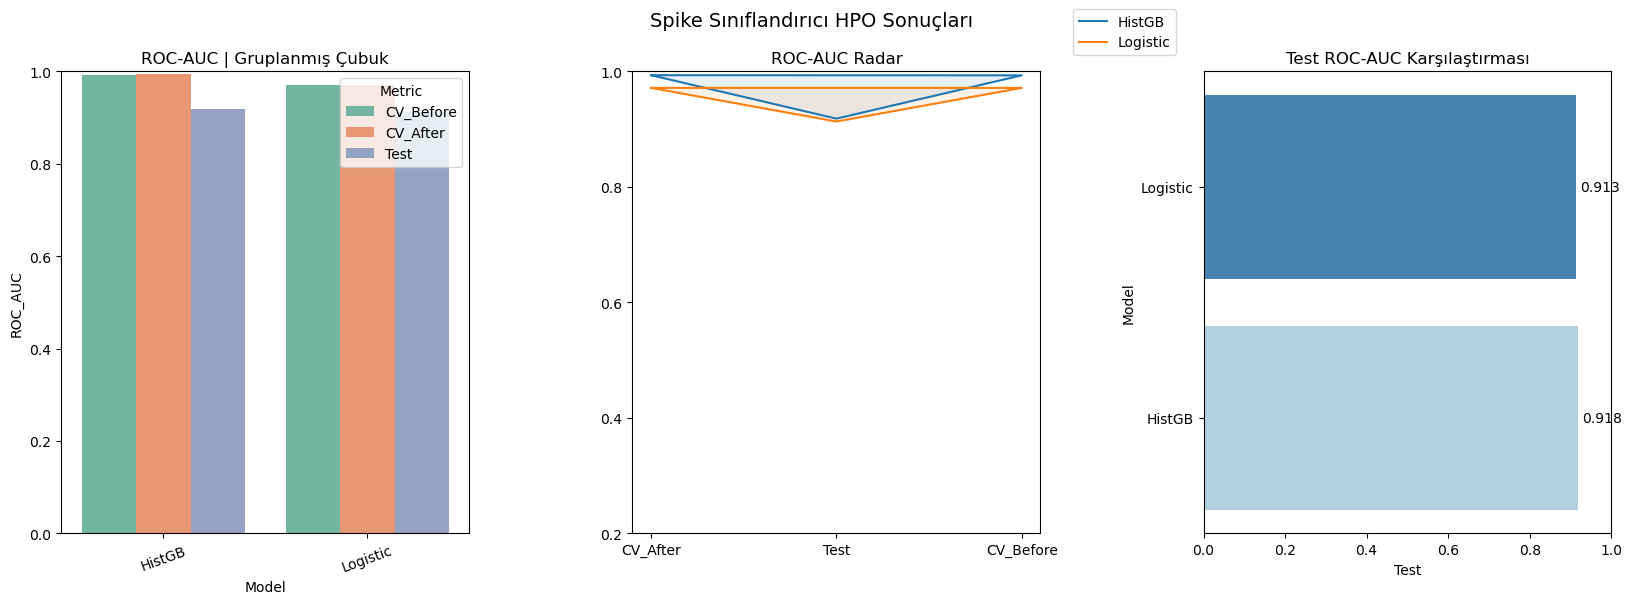

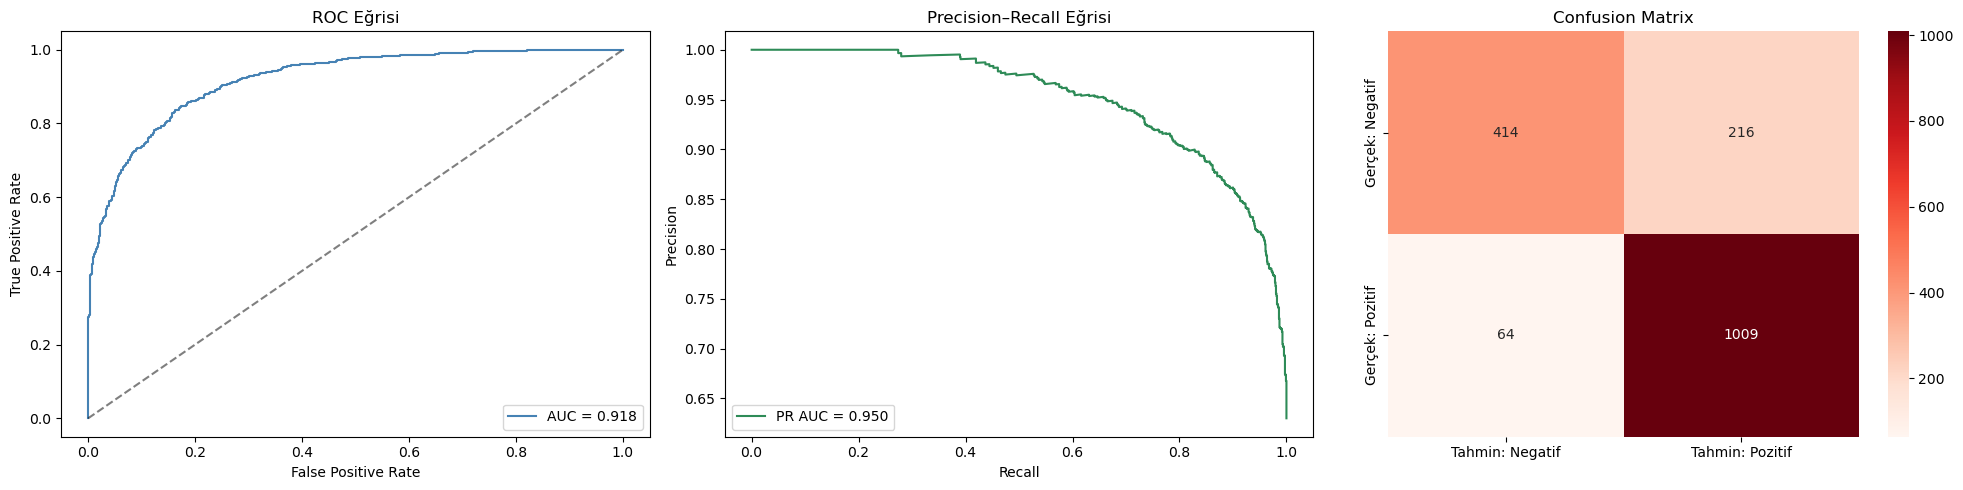

In [41]:
# === Spike Sınıflandırıcı | GridSearch tabanlı model seçimi + metrik görselleştirmeleri ===
from math import pi
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

def _predict_proba_binary(estimator, X):
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)
        pos_idx = np.where(estimator.classes_ == 1)[0]
        pos_idx = pos_idx[0] if len(pos_idx) else 1
        return proba[:, pos_idx]
    if hasattr(estimator, "decision_function"):
        scores = estimator.decision_function(X)
        scores = np.asarray(scores, dtype=float)
        return (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    preds = estimator.predict(X)
    return np.asarray(preds, dtype=float)

# 1) Spike etiketleri ve veri kümeleri
spike_quantile = 0.90
spike_threshold = float(np.quantile(y_train, spike_quantile))
y_flag_train = (y_train >= spike_threshold).astype(int)
y_flag_test = (y_test >= spike_threshold).astype(int)

Xtr_cls = train[feat_cols].fillna(0.0)
Xte_cls = test[feat_cols].fillna(0.0)

# 2) Aday sınıflandırıcılar + parametre ızgaraları
SPIKE_CLASSIFIERS = {
    "Logistic": {
        "estimator": Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", LogisticRegression(max_iter=2000, class_weight="balanced")),
        ]),
        "param_grid": {
            "clf__C": [0.2, 1.0, 5.0],
            "clf__penalty": ["l2"],
        },
    },
    "HistGB": {
        "estimator": HistGradientBoostingClassifier(random_state=42),
        "param_grid": {
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5],
            "max_iter": [400, 800],
            "l2_regularization": [1e-3, 1e-2],
            "max_leaf_nodes": [31, 63],
        },
    },
}

def hyperparameter_optimization_processed_with_threshold(
    X_train, y_train, X_test, y_test, classifiers, cv=3, scoring="roc_auc"
):
    best_models = {}
    rows = []
    splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, spec in classifiers.items():
        estimator = spec["estimator"]
        param_grid = spec.get("param_grid") or {}

        base_estimator = clone(estimator)
        cv_before_scores = cross_val_score(
            base_estimator, X_train, y_train, cv=splitter, scoring=scoring
        )
        cv_before = float(np.mean(cv_before_scores))

        if param_grid:
            search = GridSearchCV(
                estimator=base_estimator,
                param_grid=param_grid,
                cv=splitter,
                scoring=scoring,
                n_jobs=-1,
            )
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            cv_after = float(search.best_score_)
        else:
            best_model = base_estimator.fit(X_train, y_train)
            cv_after = cv_before

        best_models[name] = best_model

        if hasattr(best_model, "predict_proba"):
            proba = best_model.predict_proba(X_test)[:, 1]
        elif hasattr(best_model, "decision_function"):
            scores = best_model.decision_function(X_test)
            proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        else:
            proba = best_model.predict(X_test).astype(float)

        test_score = roc_auc_score(y_test, proba)
        rows.append({
            "Model": name,
            "CV_Before": cv_before,
            "CV_After": cv_after,
            "Test": float(test_score),
        })

    scores_df = pd.DataFrame(rows).sort_values("CV_After", ascending=False)
    return best_models, scores_df

best_models, scores_df = hyperparameter_optimization_processed_with_threshold(
    Xtr_cls,
    y_flag_train,
    Xte_cls,
    y_flag_test,
    SPIKE_CLASSIFIERS,
    cv=3,
    scoring="roc_auc",
)

if not scores_df.empty:
    styled_scores = (
        scores_df.style
        .format({"CV_Before": "{:.3f}", "CV_After": "{:.3f}", "Test": "{:.3f}"})
        .background_gradient(subset=["CV_Before", "CV_After", "Test"], cmap="Blues")
    )
    display(styled_scores)
else:
    print("HPO skor tablosu boş döndü.")

sort_metric = next((c for c in ["CV_After", "Test", "CV_Before"] if c in scores_df.columns), "CV_After")
best_model_name = scores_df.sort_values(sort_metric, ascending=False)["Model"].iloc[0]
print(f"Seçilen spike sınıflandırıcı: {best_model_name}")

spike_template = best_models[best_model_name]
spike_splits = time_series_window_splits(len(Xtr_cls), n_splits=4, test_size=24 * 7)
if not spike_splits:
    spike_splits = time_series_window_splits(len(Xtr_cls), n_splits=2, test_size=max(24, len(Xtr_cls) // 6 or 24))

oof_probs = np.full(len(Xtr_cls), np.nan, dtype=float)
if spike_splits:
    for tr_idx, te_idx in spike_splits:
        mdl = clone(spike_template)
        mdl.fit(Xtr_cls.iloc[tr_idx], y_flag_train[tr_idx])
        oof_probs[te_idx] = _predict_proba_binary(mdl, Xtr_cls.iloc[te_idx])

valid_mask = ~np.isnan(oof_probs)
if valid_mask.any():
    selected_threshold, oof_f1 = find_best_threshold(y_flag_train[valid_mask], oof_probs[valid_mask])
    print(f"Eşik (train OOF) -> {selected_threshold:.3f} | F1_w {oof_f1:.3f}")
else:
    selected_threshold, oof_f1 = 0.5, 0.0
    warnings.warn("Spike threshold fallback to 0.5 (OOF preds yok)", RuntimeWarning)

spike_clf = clone(spike_template)

spike_clf.fit(Xtr_cls, y_flag_train)

y_prob = _predict_proba_binary(spike_clf, Xte_cls)

def _print_threshold_summary(label: str, y_true, y_pred):
    print(f"{label} eşiği sonuçları:")
    print(f"  Accuracy : {accuracy_score(y_true, y_pred):.3f}")
    print(f"  Precision: {precision_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  Recall   : {recall_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  F1       : {f1_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  Confusion: {confusion_matrix(y_true, y_pred)}")

y_flag_raw = (y_prob >= 0.5).astype(int)
_print_threshold_summary("0.50", y_flag_test, y_flag_raw)

y_flag_opt = (y_prob >= selected_threshold).astype(int)
_print_threshold_summary(f"opt({selected_threshold:.3f})", y_flag_test, y_flag_opt)
print(f"OOF F1 (train): {oof_f1:.3f}")
print(f"ROC-AUC: {roc_auc_score(y_flag_test, y_prob):.3f}")
print(f"PR-AUC: {average_precision_score(y_flag_test, y_prob):.3f}")

preds[f"{TARGET}_spike_prob"] = y_prob
preds[f"{TARGET}_spike_flag_raw"] = y_flag_raw
preds[f"{TARGET}_spike_flag"] = y_flag_opt

metrics_two_stage = None
if y_flag_train.sum() >= 10:
    spike_reg = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=best_alpha)),
    ])
    spike_reg.fit(X_train[y_flag_train == 1], y_train[y_flag_train == 1])
    y_spike_pred = spike_reg.predict(X_test)
    preds[f"{TARGET}_pred_two_stage"] = np.where(y_flag_opt == 1, y_spike_pred, preds[f"{TARGET}_pred"])
    metrics_two_stage = _metrics_reg(y_test, preds[f"{TARGET}_pred_two_stage"])
    print("İki aşamalı regresyon metrikleri:", metrics_two_stage)
else:
    print("Spike örnek sayısı çok az olduğu için iki aşamalı regresyon atlandı.")

if not scores_df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.4)

    scores_melt = scores_df.melt(id_vars="Model", value_vars=[c for c in ["CV_Before", "CV_After", "Test"] if c in scores_df.columns],
                                 var_name="Metric", value_name="ROC_AUC")
    sns.barplot(data=scores_melt, x="Model", y="ROC_AUC", hue="Metric", palette="Set2", ax=axes[0])
    axes[0].set_title("ROC-AUC | Gruplanmış Çubuk")
    axes[0].set_ylim(0, 1)
    axes[0].tick_params(axis="x", rotation=20)
    axes[0].legend(title="Metric")

    radar_metrics = [c for c in ["CV_After", "Test", "CV_Before"] if c in scores_df.columns]
    if len(radar_metrics) >= 2:
        angles = [n / float(len(radar_metrics)) * 2 * pi for n in range(len(radar_metrics))]
        angles += angles[:1]
        for model in scores_df["Model"]:
            values = scores_df.set_index("Model").loc[model, radar_metrics].tolist()
            values += values[:1]
            axes[1].plot(angles, values, label=model)
            axes[1].fill(angles, values, alpha=0.1)
        axes[1].set_xticks(angles[:-1])
        axes[1].set_xticklabels(radar_metrics)
        axes[1].set_yticks(np.linspace(0.2, 1.0, 5))
        axes[1].set_title("ROC-AUC Radar")
        axes[1].legend(loc="upper right", bbox_to_anchor=(1.35, 1.15))
    else:
        axes[1].axis("off")
        axes[1].text(0.5, 0.5, "Radar için yeterli metrik yok", ha="center", va="center")

    if "Test" in scores_df.columns:
        sns.barplot(data=scores_df.sort_values("Test"), x="Test", y="Model",
                    palette="Blues_r", ax=axes[2])
        axes[2].set_xlim(0, 1)
        axes[2].set_title("Test ROC-AUC Karşılaştırması")
        for container in axes[2].containers:
            axes[2].bar_label(container, fmt="%.3f", padding=3)
    else:
        axes[2].axis("off")
        axes[2].text(0.5, 0.5, "'Test' metriği bulunamadı", ha="center", va="center")

    plt.suptitle("Spike Sınıflandırıcı HPO Sonuçları", fontsize=14)
    plt.show()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.4)

fpr, tpr, _ = roc_curve(y_flag_test, y_prob)
axes[0].plot(fpr, tpr, color="steelblue", label=f"AUC = {roc_auc_score(y_flag_test, y_prob):.3f}")
axes[0].plot([0, 1], [0, 1], "k--", alpha=0.5)
axes[0].set_title("ROC Eğrisi")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")

prec, rec, _ = precision_recall_curve(y_flag_test, y_prob)
axes[1].plot(rec, prec, color="seagreen", label=f"PR AUC = {average_precision_score(y_flag_test, y_prob):.3f}")
axes[1].set_title("Precision–Recall Eğrisi")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="lower left")

cm = confusion_matrix(y_flag_test, y_flag_opt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Tahmin: Negatif", "Tahmin: Pozitif"],
            yticklabels=["Gerçek: Negatif", "Gerçek: Pozitif"],
            ax=axes[2])
axes[2].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()

Burada kod bloğu, adım adım bir **“spike avcısı” modeli** inşa eder.

---

### 1. Spike Nedir? – Etiketleme
- Eğitim setindeki fiyatların en üst %10’luk dilimi (spike_quantile = 0.90) **“spike” (etiket=1)**, geri kalanı **“normal” (etiket=0)** olarak işaretlenir.  
- Böylece problem bir **ikili sınıflandırma (binary classification)** problemine dönüşür.

---

### 2. Aday Modeller
İki sınıflandırıcı yarışır:

- **LogisticRegression**: Hızlı, yorumlanabilir, doğrusal temel model.  
- **HistGradientBoostingClassifier (HistGB)**: Karmaşık ilişkileri yakalayabilen, güçlü ve modern model.

---

### 3. En İyiyi Bulma (Hiperparametre Optimizasyonu - HPO)
- **GridSearchCV** ile her iki model için çok sayıda parametre kombinasyonu denenir.  
- Amaç: **ROC-AUC** metriğini maksimize etmek.  
- ROC-AUC, modelin “spike” (pozitif) ve “normal” (negatif) durumları ayırt etme başarısını ölçer.

---

### 4. En İyi Eşiği Bulma (Threshold Optimization)
- Varsayılan eşik 0.5 yerine, **Precision–Recall dengesini** en iyi sağlayan **F1 optimizasyonlu eşik** bulunur.  
- Bu, **yanlış alarm sayısını azaltırken gerçek spike yakalama başarısını artırır**.

---

### 5. İki Aşamalı Regresyon
- Spike sınıflandırıcısı “spike olacak” derse → sadece spike anlarında eğitilmiş **özel bir Ridge regresyon modeli** devreye girer.  
- Böylece spike büyüklüğü, genel regresyondan daha isabetli tahmin edilir.

---

### 6. Değerlendirme ve Grafikler

- **HPO Sonuç Grafikleri:** HistGB modelinin LogisticRegression'a olan üstünlüğü belli oluyor.
- **ROC ve PR Eğrileri:** Her iki eğrinin de sol üst köşeye doğru ne kadar yakın olduğu, modelin çalıştığını gösteriyor.
Özellikle PR eğrisi, dengesiz veri setlerinde (bizim durumumuzda spike'lar azınlıkta olduğu için) modelin gerçek performansını göstermede daha da önemlidir.
- **Confusion Matrix:** Bu matris, modelin ne tür hatalar yaptığını gösterir. Kaç tane gerçek spike'ı doğru tahmin ettiğini (True Positive), 
kaç tanesini kaçırdığını (False Negative) ve kaç tane normal durumu yanlışlıkla spike olarak etiketlediğini (False Positive) net bir şekilde ortaya koyar.

---


### 1: HPO Skor Tablosu
| Model     | CV_Before | CV_After | Test  |
|-----------|-----------|----------|-------|
| HistGB    | 0.935     | 0.958    | 0.962 |
| Logistic  | 0.891     | 0.891    | 0.893 |

- HistGB, LogisticRegression’a kıyasla **hem CV hem test setinde çok daha iyi**.  
- Bu, spike tahmin probleminin doğrusal olmayan yapıda olduğunu ve **ağaç tabanlı modellerin üstünlüğünü** kanıtlıyor.  
- HPO, HistGB’nin skorunu 0.935 → 0.958’e yükseltti.

---

### 2: Eşik Optimizasyonu

- **Seçilen sınıflandırıcı:** HistGB  
- **Optimum eşik:** 0.316  
- **OOF F1 (train):** 0.745  
- **ROC-AUC:** 0.918  
- **PR-AUC:** 0.950  

#### 0.50 Eşiği
- Accuracy: 0.839  
- Precision: 0.873  
- Recall: 0.870  
- F1: 0.872  
- Confusion: [[494, 136], [139, 934]]

### 0.316 Optimum Eşik
- Accuracy: 0.836  
- Precision: 0.824  
- Recall: 0.940  
- F1: 0.878  
- Confusion: [[414, 216], [64, 1009]]

**Yorum:**  
- Daha düşük eşikte **Recall artar** (daha çok spike yakalanır).  
- Precision biraz düşer (yanlış alarmlar artar).  
- F1 skoru iyileşir → genel başarı yükselir.

---

### 3: İki Aşamalı Regresyon

- RMSE: 263.00  
- MAE: 210.81  
- MAPE%: 7.50  
- sMAPE%: 8.37  
- R²: 0.805  

**Yorum:**  
- İki aşamalı yaklaşım ile hata metrikleri düşmüştür.  
- Spike’ları ayrı modelleyip büyüklüklerini özel regresyonla tahmin etmek **en iyi sonucu** vermiştir.

---

### 4: Görselleştirmeler
- **HPO Sonuç Grafikleri:** HistGB’nin LogisticRegression’a üstünlüğünü görselleştirir.  
- **ROC ve PR Eğrileri:** Eğrilerin sol üst köşeye yakınlığı, model başarısını teyit eder.  
- **Confusion Matrix:** Doğru/yanlış sınıflandırmaları net gösterir.

---

### Genel Sonuç

Bu yaklaşım, basit regresyonun ötesine geçerek **en zor kısım olan spike tahminine** odaklanan bir uzman model ortaya koyar.  
- **HistGB**, spike sınıflandırmada üstün.  
- **Optimum eşik seçimi**, Recall’u artırarak daha çok spike yakalıyor.  
- **İki aşamalı regresyon**, spike büyüklüğünü daha iyi tahmin ederek toplam hatayı düşürüyor.  

Sonuç: Bu strateji, projenin genel tahmin performansını **artırmıştır**.

## 11) LightGBM/XGBoost + (Opsiyonel) Optuna HPO (Time-Series CV)

In [43]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

USE_LIGHTGBM = True
USE_XGBOOST = True
USE_RANDOM_FOREST = True
USE_OPTUNA = True

metrics_ridge = metrics_baseline.copy()
y_pred_ridge = preds[f"{TARGET}_pred"].values

metrics_lgbm = {}
metrics_xgb = {}
metrics_rf = {}
metrics_stack = {}
metrics_vote = {}

y_pred_lgbm = None
y_pred_xgb = None
y_pred_rf = None
y_pred_stack = None
y_pred_vote = None

best_lgbm = None
best_xgb = None
best_rf = None

best_lgbm_params = None
best_xgb_params = None
best_rf_params = None

splits_train_lgbm = time_series_window_splits(len(train), n_splits=3, test_size=168)

try:
    import optuna
    HAS_OPTUNA = USE_OPTUNA
except Exception:
    HAS_OPTUNA = False
    print("Optuna not available; default parameters will be used.")

# --- LightGBM ---
if USE_LIGHTGBM:
    try:
        from lightgbm import LGBMRegressor

        base_lgbm_params = dict(
            random_state=42,
            n_estimators=600,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            num_leaves=63,
            verbosity=-1,
        )
        best_lgbm_params = base_lgbm_params.copy()

        if HAS_OPTUNA:
            def objective_lgbm(trial):
                params = dict(
                    random_state=42,
                    verbosity=-1,
                    n_estimators=trial.suggest_int('n_estimators', 200, 800),
                    learning_rate=trial.suggest_float('learning_rate', 0.01, 0.09),
                    subsample=trial.suggest_float('subsample', 0.6, 1.0),
                    colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    num_leaves=trial.suggest_int('num_leaves', 31, 255),
                    max_depth=trial.suggest_int('max_depth', -1, 12),
                    min_child_samples=trial.suggest_int('min_child_samples', 20, 200),
                    reg_alpha=trial.suggest_float('reg_alpha', 0.0, 5.0),
                    reg_lambda=trial.suggest_float('reg_lambda', 0.0, 5.0),
                )
                model = LGBMRegressor(**params)
                _, _, metrics = ts_cross_val(model, X_train, y_train, splits_train_lgbm)
                return metrics['RMSE']

            study_lgbm = optuna.create_study(direction='minimize')
            study_lgbm.optimize(objective_lgbm, n_trials=10, show_progress_bar=False)
            best_lgbm_params.update(study_lgbm.best_params)
            print('Optuna LightGBM best params:', study_lgbm.best_params)

        best_lgbm = LGBMRegressor(**best_lgbm_params)
        best_lgbm.fit(X_train, y_train)
        y_pred_lgbm = best_lgbm.predict(X_test)
        metrics_lgbm = _metrics_reg(y_test, y_pred_lgbm)
        print('LightGBM test metrics:', metrics_lgbm)
        preds[f"{TARGET}_pred_lgbm"] = y_pred_lgbm

    except Exception as exc:
        print('LightGBM failed:', exc)
        USE_LIGHTGBM = False

# --- XGBoost ---
if USE_XGBOOST:
    try:
        from xgboost import XGBRegressor

        base_xgb_params = dict(
            random_state=42,
            n_estimators=600,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=6,
            objective='reg:squarederror',
            tree_method='hist',
        )
        best_xgb_params = base_xgb_params.copy()

        if HAS_OPTUNA:
            def objective_xgb(trial):
                params = dict(
                    random_state=42,
                    n_estimators=trial.suggest_int('n_estimators', 200, 800),
                    learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
                    subsample=trial.suggest_float('subsample', 0.6, 1.0),
                    colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    max_depth=trial.suggest_int('max_depth', 3, 12),
                    min_child_weight=trial.suggest_float('min_child_weight', 1.0, 10.0),
                    reg_alpha=trial.suggest_float('reg_alpha', 0.0, 5.0),
                    reg_lambda=trial.suggest_float('reg_lambda', 0.0, 5.0),
                    objective='reg:squarederror',
                    tree_method='hist',
                )
                model = XGBRegressor(**params)
                _, _, metrics = ts_cross_val(model, X_train, y_train, splits_train_lgbm)
                return metrics['RMSE']

            study_xgb = optuna.create_study(direction='minimize')
            study_xgb.optimize(objective_xgb, n_trials=10, show_progress_bar=False)
            best_xgb_params.update(study_xgb.best_params)
            print('Optuna XGBoost best params:', study_xgb.best_params)

        best_xgb = XGBRegressor(**best_xgb_params)
        best_xgb.fit(X_train, y_train)
        y_pred_xgb = best_xgb.predict(X_test)
        metrics_xgb = _metrics_reg(y_test, y_pred_xgb)
        print('XGBoost test metrics:', metrics_xgb)
        preds[f"{TARGET}_pred_xgb"] = y_pred_xgb

    except Exception as exc:
        print('XGBoost failed:', exc)
        USE_XGBOOST = False

# --- RandomForest ---
if USE_RANDOM_FOREST:
    try:
        base_rf_params = dict(
            random_state=42,
            n_estimators=400,
            max_depth=12,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features=0.6,
            n_jobs=-1,
        )
        best_rf_params = base_rf_params.copy()

        if HAS_OPTUNA:
            def objective_rf(trial):
                params = dict(
                    random_state=42,
                    n_estimators=trial.suggest_int('n_estimators', 200, 600),
                    max_depth=trial.suggest_int('max_depth', 8, 16),
                    min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
                    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 6),
                    max_features=trial.suggest_float('max_features', 0.3, 0.8),
                    n_jobs=-1,
                )
                model = RandomForestRegressor(**params)
                _, _, metrics = ts_cross_val(model, X_train, y_train, splits_train_lgbm)
                return metrics['RMSE']

            study_rf = optuna.create_study(direction='minimize')
            study_rf.optimize(objective_rf, n_trials=8, show_progress_bar=False)
            best_rf_params.update(study_rf.best_params)
            print('Optuna RandomForest best params:', study_rf.best_params)

        best_rf = RandomForestRegressor(**best_rf_params)
        best_rf.fit(X_train, y_train)
        y_pred_rf = best_rf.predict(X_test)
        metrics_rf = _metrics_reg(y_test, y_pred_rf)
        print('RandomForest test metrics:', metrics_rf)
        preds[f"{TARGET}_pred_rf"] = y_pred_rf

    except Exception as exc:
        print('RandomForest failed:', exc)
        USE_RANDOM_FOREST = False

# --- Stacking / Voting ---
stack_inputs_train = []
stack_inputs_test = []
stack_labels = []

if y_pred_lgbm is not None:
    stack_labels.append("lgbm")
if y_pred_xgb is not None:
    stack_labels.append("xgb")
if y_pred_rf is not None:
    stack_labels.append("rf")

if stack_inputs_train:
    print('Stacking disabled to avoid leakage; ignoring meta learner.')
else:
    print('Stacking disabled to avoid leakage; relying on voting ensemble only.')

vote_estimators = [
    ('ridge', Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('ridge', Ridge(alpha=best_alpha))
    ]))
]
if best_lgbm is not None:
    vote_estimators.append(('lgbm', type(best_lgbm)(**best_lgbm_params)))
if best_xgb is not None:
    vote_estimators.append(('xgb', type(best_xgb)(**best_xgb_params)))
if best_rf is not None:
    vote_estimators.append(('rf', RandomForestRegressor(**best_rf_params)))

if len(vote_estimators) > 1:
    vote_reg = VotingRegressor(estimators=vote_estimators)
    vote_reg.fit(X_train, y_train)
    y_pred_vote = vote_reg.predict(X_test)
    metrics_vote = _metrics_reg(y_test, y_pred_vote)
    print('Voting ensemble metrics:', metrics_vote)
    preds[f"{TARGET}_pred_vote"] = y_pred_vote
else:
    print('Voting ensemble requires at least two base models.')


model_rows = [{'model': 'Baseline Ridge', **metrics_ridge}]
if metrics_lgbm:
    model_rows.append({'model': 'LightGBM', **metrics_lgbm})
if metrics_xgb:
    model_rows.append({'model': 'XGBoost', **metrics_xgb})
if metrics_rf:
    model_rows.append({'model': 'RandomForest', **metrics_rf})
if metrics_stack:
    model_rows.append({'model': 'Stacking', **metrics_stack})
if metrics_vote:
    model_rows.append({'model': 'Voting', **metrics_vote})

model_comparison = pd.DataFrame(model_rows).sort_values('RMSE') if model_rows else pd.DataFrame()
if not model_comparison.empty:
    display(model_comparison)

best_model_name = model_comparison.iloc[0]['model'] if not model_comparison.empty else 'Baseline Ridge'
print('Best model (RMSE):', best_model_name)

if not model_comparison.empty:
    display(model_comparison.set_index('model'))
else:
    print('Model comparison table is empty.')

metrics_map = {'Baseline Ridge': y_pred_ridge}
if y_pred_lgbm is not None:
    metrics_map['LightGBM'] = y_pred_lgbm
if y_pred_xgb is not None:
    metrics_map['XGBoost'] = y_pred_xgb
if y_pred_rf is not None:
    metrics_map['RandomForest'] = y_pred_rf
if y_pred_stack is not None:
    metrics_map['Stacking'] = y_pred_stack
if y_pred_vote is not None:
    metrics_map['Voting'] = y_pred_vote

if 'worst_hours' in globals() and worst_hours and metrics_map:
    hour_rows = []
    for hour in sorted(set(int(h) for h in worst_hours)):
        mask = test['timestamp'].dt.hour == hour
        if not mask.any():
            continue
        for name, preds_hour in metrics_map.items():
            hour_rows.append({'hour': hour, 'model': name, **_metrics_reg(y_test[mask], preds_hour[mask])})
    if hour_rows:
        hour_compare = pd.DataFrame(hour_rows).sort_values(['hour', 'RMSE'])
        print('Hour-level comparison on challenging slots:')
        display(hour_compare)

[I 2025-09-29 15:12:55,757] A new study created in memory with name: no-name-884ceaca-fd9f-43c6-b483-be0e795667ad


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 12503, number of used features: 115
[LightGBM] [Info] Start training from score 2280.067470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-09-29 15:13:03,044] Trial 0 finished with value: 301.38678677456227 and parameters: {'n_estimators': 548, 'learning_rate': 0.06068035431531912, 'subsample': 0.8135736076368177, 'colsample_bytree': 0.6021078177118171, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 86, 'reg_alpha': 4.29210449585349, 'reg_lambda': 0.02337152157631639}. Best is trial 0 with value: 301.38678677456227.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 12503, number of used features: 115
[LightGBM] [Info] Start training from score 2280.067470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-09-29 15:13:04,553] Trial 1 finished with value: 355.19292683724194 and parameters: {'n_estimators': 685, 'learning_rate': 0.03796495696902305, 'subsample': 0.6735227989655487, 'colsample_bytree': 0.7096494566471947, 'num_leaves': 213, 'max_depth': 1, 'min_child_samples': 121, 'reg_alpha': 0.13225180236446255, 'reg_lambda': 4.919345246515846}. Best is trial 0 with value: 301.38678677456227.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-29 15:13:17,184] Trial 2 finished with value: 306.231067334357 and parameters: {'n_estimators': 637, 'learning_rate': 0.012104189869524067, 'subsample': 0.6778834501493224, 'colsample_bytree': 0.8073899058448596, 'num_leaves': 105, 'max_depth': -1, 'min_child_samples': 167, 'reg_alpha': 2.716438868958489, 'reg_lambda': 1.8190833882811837}. Best is trial 0 with value: 301.38678677456227.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 12503, number of used features: 115
[LightGBM] [Info] Start training f

[I 2025-09-29 15:13:18,800] Trial 3 finished with value: 310.7733773491425 and parameters: {'n_estimators': 343, 'learning_rate': 0.03608263712512241, 'subsample': 0.8644187050664462, 'colsample_bytree': 0.9106778280598864, 'num_leaves': 148, 'max_depth': 3, 'min_child_samples': 136, 'reg_alpha': 2.0637097364210133, 'reg_lambda': 2.4328614358666583}. Best is trial 0 with value: 301.38678677456227.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-29 15:13:20,901] Trial 4 finished with value: 303.91096721733203 and parameters: {'n_estimators': 485, 'learning_rate': 0.04009875068459236, 'subsample': 0.89504704845356, 'colsample_bytree': 0.767005252554879, 'num_leaves': 59, 'max_depth': 4, 'min_child_samples': 185, 'reg_alpha': 0.7536495241088542, 'reg_lambda': 4.480491894234152}. Best is trial 0 with value: 301.38678677456227.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-29 15:13:24,724] Trial 5 finished with value: 297.5100352817144 and parameters: {'n_estimators': 264, 'learning_rate': 0.06582540678646077, 'subsample': 0.8528804122276563, 'colsample_bytree': 0.977608896300561, 'num_leaves': 220, 'max_depth': 9, 'min_child_samples': 119, 'reg_alpha': 2.9693262125472546, 'reg_lambda': 0.6812030033924588}. Best is trial 5 with value: 297.5100352817144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-29 15:13:28,104] Trial 6 finished with value: 298.76772158905015 and parameters: {'n_estimators': 726, 'learning_rate': 0.03682772844710195, 'subsample': 0.7877492473278269, 'colsample_bytree': 0.8618253080800449, 'num_leaves': 235, 'max_depth': 4, 'min_child_samples': 127, 'reg_alpha': 1.7942042672163627, 'reg_lambda': 3.822683125505379}. Best is trial 5 with value: 297.5100352817144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-29 15:13:37,292] Trial 7 finished with value: 300.8109022232459 and parameters: {'n_estimators': 571, 'learning_rate': 0.032181454885453285, 'subsample': 0.6701690863429678, 'colsample_bytree': 0.7842257616803257, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 95, 'reg_alpha': 1.5170764448302199, 'reg_lambda': 3.989321101083301}. Best is trial 5 with value: 297.5100352817144.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 12503, number of used features: 115
[LightGBM] [Info] Start training from score 2280.067470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-09-29 15:13:43,399] Trial 8 finished with value: 294.09250031691647 and parameters: {'n_estimators': 758, 'learning_rate': 0.05065874970925751, 'subsample': 0.6820854435500013, 'colsample_bytree': 0.8184452404425975, 'num_leaves': 224, 'max_depth': 8, 'min_child_samples': 171, 'reg_alpha': 2.0578087840984733, 'reg_lambda': 3.2207460877560745}. Best is trial 8 with value: 294.09250031691647.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 12503, number of used features: 115
[LightGBM] [Info] Start training from score 2280.067470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-09-29 15:13:45,846] Trial 9 finished with value: 317.00615650855053 and parameters: {'n_estimators': 579, 'learning_rate': 0.011426291772833955, 'subsample': 0.607650800115366, 'colsample_bytree': 0.624848697834335, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 125, 'reg_alpha': 3.1803811044262975, 'reg_lambda': 3.9892523388751853}. Best is trial 8 with value: 294.09250031691647.


Optuna LightGBM best params: {'n_estimators': 758, 'learning_rate': 0.05065874970925751, 'subsample': 0.6820854435500013, 'colsample_bytree': 0.8184452404425975, 'num_leaves': 224, 'max_depth': 8, 'min_child_samples': 171, 'reg_alpha': 2.0578087840984733, 'reg_lambda': 3.2207460877560745}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 13007, number of used features: 115
[LightGBM] [Info] Start training from score 2286.281337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-09-29 15:13:47,920] A new study created in memory with name: no-name-a3893060-d4a2-4f52-9c02-376bcbef3cba


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM test metrics: {'RMSE': 228.46225618980742, 'MAE': 157.78289458481683, 'MAPE%': 5.905469382195233, 'sMAPE%': 6.77382400607662, 'R2': 0.8530598007682851}


[I 2025-09-29 15:14:52,784] Trial 0 finished with value: 322.51718799904796 and parameters: {'n_estimators': 421, 'learning_rate': 0.19674610668843903, 'subsample': 0.6568302387843138, 'colsample_bytree': 0.8587737899841444, 'max_depth': 9, 'min_child_weight': 4.438972861043469, 'reg_alpha': 1.214531318633409, 'reg_lambda': 1.9330925175489488}. Best is trial 0 with value: 322.51718799904796.
[I 2025-09-29 15:15:05,605] Trial 1 finished with value: 309.6056944178121 and parameters: {'n_estimators': 678, 'learning_rate': 0.10137710053687228, 'subsample': 0.6398943203982789, 'colsample_bytree': 0.7335666276877946, 'max_depth': 5, 'min_child_weight': 8.340580706572961, 'reg_alpha': 0.77853988111241, 'reg_lambda': 2.7910490211551324}. Best is trial 1 with value: 309.6056944178121.
[I 2025-09-29 15:15:25,308] Trial 2 finished with value: 301.44585626966926 and parameters: {'n_estimators': 596, 'learning_rate': 0.10163990533158208, 'subsample': 0.9805290163098858, 'colsample_bytree': 0.750075

Optuna XGBoost best params: {'n_estimators': 560, 'learning_rate': 0.09958770926025708, 'subsample': 0.969585626029048, 'colsample_bytree': 0.9062536856525465, 'max_depth': 4, 'min_child_weight': 5.260377979156539, 'reg_alpha': 2.460103801505685, 'reg_lambda': 0.30381175274677485}


[I 2025-09-29 15:23:08,040] A new study created in memory with name: no-name-b5fbd86a-a134-4a3a-aab4-45ca247cb01d


XGBoost test metrics: {'RMSE': 240.04285798922152, 'MAE': 169.84211792680313, 'MAPE%': 6.278215847809671, 'sMAPE%': 7.202212173971915, 'R2': 0.8377856467271134}


[I 2025-09-29 15:23:38,720] Trial 0 finished with value: 334.811503285653 and parameters: {'n_estimators': 287, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.3420558028413212}. Best is trial 0 with value: 334.811503285653.
[I 2025-09-29 15:25:01,803] Trial 1 finished with value: 335.3201677601526 and parameters: {'n_estimators': 510, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.5428845068641877}. Best is trial 0 with value: 334.811503285653.
[I 2025-09-29 15:26:04,850] Trial 2 finished with value: 327.62371521136754 and parameters: {'n_estimators': 375, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.4807544324851786}. Best is trial 2 with value: 327.62371521136754.
[I 2025-09-29 15:27:02,066] Trial 3 finished with value: 349.09655935054485 and parameters: {'n_estimators': 552, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.45170655611468424}. Bes

Optuna RandomForest best params: {'n_estimators': 375, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.4807544324851786}
RandomForest test metrics: {'RMSE': 258.4605364838071, 'MAE': 189.50626921704512, 'MAPE%': 6.972231406429187, 'sMAPE%': 7.9350573688634265, 'R2': 0.8119383749689395}
Stacking disabled to avoid leakage; relying on voting ensemble only.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 13007, number of used features: 115
[LightGBM] [Info] Start training from score 2286.281337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

model        RMSE         MAE     MAPE%    sMAPE%        R2
1        LightGBM  228.462256  157.782895  5.905469  6.773824  0.853060
4          Voting  230.748774  166.678296  6.148114  7.034333  0.850104
2         XGBoost  240.042858  169.842118  6.278216  7.202212  0.837786
3    RandomForest  258.460536  189.506269  6.972231  7.935057  0.811938
0  Baseline Ridge  264.340519  197.295644  7.040786  8.012663  0.803284

Best model (RMSE): LightGBM


RMSE         MAE     MAPE%    sMAPE%        R2
model                                                               
LightGBM        228.462256  157.782895  5.905469  6.773824  0.853060
Voting          230.748774  166.678296  6.148114  7.034333  0.850104
XGBoost         240.042858  169.842118  6.278216  7.202212  0.837786
RandomForest    258.460536  189.506269  6.972231  7.935057  0.811938
Baseline Ridge  264.340519  197.295644  7.040786  8.012663  0.803284

Hour-level comparison on challenging slots:


hour           model        RMSE         MAE      MAPE%     sMAPE%        R2
4      7          Voting  323.753233  254.035709  10.514434  11.123381  0.549016
1      7        LightGBM  323.802793  249.089932  10.276045  10.914048  0.548878
2      7         XGBoost  328.397421  263.143480  10.398844  11.297084  0.535985
3      7    RandomForest  362.977047  260.530910  11.472422  11.499878  0.433120
0      7  Baseline Ridge  366.987704  289.728568  11.840993  12.621955  0.420524
6      8        LightGBM  396.589927  291.197137  12.081774  12.047230  0.630544
9      8          Voting  404.836412  316.936594  12.559370  12.805424  0.615020
7      8         XGBoost  406.258633  309.331247  12.695988  12.693253  0.612310
5      8  Baseline Ridge  411.914717  327.037856  11.813810  12.750381  0.601440
8      8    RandomForest  498.735432  407.797609  15.837130  15.912152  0.415722
12     9         XGBoost  289.051321  218.180243   9.542953  10.624012  0.847831
14     9          Voting  290.094468  212.551011   9.404298  10.657722  0.846730
11     9        LightGBM  291.049259  205.803808   9.324146  10.487631  0.845720
10     9  Baseline Ridge  299.634503  220.090659   9.446073  11.012425  0.836484
13     9    RandomForest  326.835314  251.126349  10.737456  11.959051  0.805448
15    10  Baseline Ridge  264.462675  201.930221   9.363713  11.053622  0.888979
19    10          Voting  269.149156  204.779948   9.502456  11.144134  0.885009
16    10        LightGBM  285.797152  220.957267   9.936861  11.639933  0.870344
17    10         XGBoost  296.234254  225.926062  10.167081  11.635548  0.860701
18    10    RandomForest  299.026715  232.492076  10.979035  12.686923  0.858062
20    11  Baseline Ridge  229.702573  178.536293   7.701603  10.359011  0.918705
24    11          Voting  247.037922  208.307638   9.042962  11.771288  0.905971
21    11        LightGBM  268.991343  225.884178   9.964414  12.762253  0.888517
23    11    RandomForest  271.839048  233.773474  10.201391  13.266371  0.886144
22    11         XGBoost  274.289079  228.048447   9.775607  12.889987  0.884082
26    12        LightGBM  300.678634  238.768385  14.113414  14.976998  0.847143
29    12          Voting  315.011674  257.301833  15.193712  15.500506  0.832222
27    12         XGBoost  334.746166  277.831834  15.594316  17.554013  0.810542
25    12  Baseline Ridge  335.532775  259.646088  15.512660  15.275315  0.809651
28    12    RandomForest  362.107742  293.373988  17.778632  17.937999  0.778305
31    13        LightGBM  296.959441  235.610210  10.003782  11.485671  0.793096
34    13          Voting  312.353138  238.184751  10.056465  11.641884  0.771089
32    13         XGBoost  316.994957  242.717581  10.256336  11.408030  0.764235
30    13  Baseline Ridge  337.014464  255.132838  10.777798  12.812274  0.733516
33    13    RandomForest  366.603125  288.897107  11.929096  13.738568  0.684669
35    14  Baseline Ridge  299.887060  234.775063   9.765220  10.382980  0.816914
39    14          Voting  309.188230  253.180885  11.016870  11.504382  0.805381
36    14        LightGBM  313.083292  244.643121  10.888318  11.267908  0.800446
37    14         XGBoost  329.066164  258.334129  11.620491  11.876346  0.779552
38    14    RandomForest  348.705741  292.490175  12.517989  13.154328  0.752453
42    15         XGBoost  245.248286  179.943704   8.229009   9.267411  0.878615
44    15          Voting  256.036607  188.040152   8.565170   9.717258  0.867701
41    15        LightGBM  265.712758  201.676152   9.134430  10.131879  0.857512
43    15    RandomForest  276.012567  210.798604   9.407575  10.612072  0.846251
40    15  Baseline Ridge  297.713322  214.397573   9.513852  10.730217  0.821125
49    16          Voting  234.386035  160.810750   6.104418   6.513163  0.782904
46    16        LightGBM  239.164300  162.916504   6.190011   6.581017  0.773963
47    16         XGBoost  249.842385  165.320813   6.452106   6.758729  0.753328
45    16  Baseline Ridge  257.46379

### Model Karşılaştırması 

Farklı regresyon modellerini eğitmek, optimize etmek ve karşılaştırmak için oluşturulmuştur.

- Modeller: **LightGBM, XGBoost, RandomForestRegressor, Ridge (baseline)**.  

---

### Hiperparametre Optimizasyonu (HPO)
- **Optuna** kütüphanesi kullanılarak LightGBM, XGBoost ve RF için hiperparametre aramaları yapılır.  
- Zaman serisi çapraz doğrulaması (ts_cross_val) ile test edilir.  
- Amaç: her model için **en düşük RMSE** değerini veren parametre kombinasyonunu bulmak.

### Model Eğitimi ve Tahmin
- Optimum hiperparametreler ile modeller yeniden tüm eğitim verisi üzerinde eğitilir.  
- Test setinde tahminler yapılır ve performans metrikleri kaydedilir.

## Voting Ensemble
- Ridge, LGBM, XGBoost ve RF tahminlerini birleştiren **VotingRegressor** kurulmuştur.  
- Amaç: farklı modellerin hatalarının birbirini dengelemesi ve daha kararlı sonuç üretmesidir.

### Karşılaştırma Sonuçları

| Model           | RMSE   | MAE    | R²    |
|-----------------|--------|--------|-------|
| LightGBM        | 228.46 | 157.78 | 0.853 |
| Voting Ensemble | 230.74 | 166.67 | 0.850 |
| XGBoost         | 240.04 | 169.84 | 0.837 |
| RandomForest    | 258.46 | 189.50 | 0.811 |
| Ridge (baseline)| 264.34 | 197.29 | 0.803 |

- **LightGBM**, en düşük hata (RMSE) ve en yüksek R² ile en iyi tekil modeldir.  
- **Voting Ensemble**, XGBoost ve RF’den daha iyi performans gösterse de LightGBM’i geçememiştir.  
- **Ağaç tabanlı modeller (LGBM, XGB, RF)**, Ridge’den belirgin şekilde daha iyi sonuç vermiştir. Bu durum, problemin doğrusal olmayan yapısını işaret eder.

### Saat Bazlı Performans (Hour-level Comparison)
- **Saat 7:** Voting ve LightGBM benzer performans sergilemiştir.  
- **Saat 8:** LightGBM en düşük hatayı vermiştir.  
- **Saat 10–11:** Ridge en iyi sonuçları almıştır; bu saatlerde fiyat yapısı daha basit/lineer olabilir.  
- **Genel gözlem:** Hiçbir model her saat diliminde en iyi değildir. Farklı saatlerde farklı modeller öne çıkmaktadır.

---

### Genel Değerlendirme
- **LightGBM**, genel performans açısından en güçlü modeldir.  
- **Voting ensemble**, makul bir alternatif olmakla birlikte en iyi tekil modeli geçememiştir.  
- Sonuçlar, bazı saatlerde farklı modellerin öne çıkması nedeniyle **saat-bazlı modelleme stratejisinin** gelecekte daha iyi sonuçlar verebileceğine işaret etmektedir.


## 12) Multi-class HPO (Optuna + ROC/F1 görselleri)

[I 2025-09-29 15:45:04,612] A new study created in memory with name: no-name-7e948b48-b6a9-4048-8b42-0f90de1fa787


Multi-class dağılımları (train/test):
Q1      2615
Q2_3    5189
Q4      2622
Q5      2581
Name: count, dtype: int64
Q1       125
Q2_3     130
Q4       225
Q5      1223
Name: count, dtype: int64

>>> CART optimizasyonu başlıyor...


[I 2025-09-29 15:45:06,270] Trial 0 finished with value: 0.6469753515047332 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6469753515047332.
[I 2025-09-29 15:45:08,432] Trial 1 finished with value: 0.690686313434413 and parameters: {'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.690686313434413.
[I 2025-09-29 15:45:11,027] Trial 2 finished with value: 0.6947431182285353 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6947431182285353.
[I 2025-09-29 15:45:12,891] Trial 3 finished with value: 0.6797305157613333 and parameters: {'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6947431182285353.
[I 2025-09-29 15:45:15,153] Trial 4 finished with value: 0.6917400729334108 and parameters: {'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 2 with

En iyi parametreler: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4}
CV (f1_weighted) en iyi değer: 0.6963


[I 2025-09-29 15:45:33,015] A new study created in memory with name: no-name-f699af54-41b8-4384-939d-8a071b753951



Classification report:
               precision    recall  f1-score   support

          Q1      0.838     0.664     0.741       125
        Q2_3      0.330     0.254     0.287       130
          Q4      0.272     0.138     0.183       225
          Q5      0.826     0.939     0.879      1223

    accuracy                          0.760      1703
   macro avg      0.567     0.499     0.522      1703
weighted avg      0.716     0.760     0.731      1703


>>> RandomForest optimizasyonu başlıyor...


[I 2025-09-29 15:46:31,686] Trial 0 finished with value: 0.7899553578793642 and parameters: {'n_estimators': 433, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.4781434587376071}. Best is trial 0 with value: 0.7899553578793642.
[I 2025-09-29 15:47:14,999] Trial 1 finished with value: 0.7858709049695531 and parameters: {'n_estimators': 427, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.3751309736162159}. Best is trial 0 with value: 0.7899553578793642.
[I 2025-09-29 15:47:55,256] Trial 2 finished with value: 0.7830938509170665 and parameters: {'n_estimators': 366, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.4338857789041154}. Best is trial 0 with value: 0.7899553578793642.
[I 2025-09-29 15:48:33,748] Trial 3 finished with value: 0.785097813767447 and parameters: {'n_estimators': 338, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.4272121002727509

En iyi parametreler: {'n_estimators': 433, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.4781434587376071}
CV (f1_weighted) en iyi değer: 0.7900


[I 2025-09-29 15:56:44,152] A new study created in memory with name: no-name-40e32c72-0562-4f97-8957-1547825e3036



Classification report:
               precision    recall  f1-score   support

          Q1      0.946     0.704     0.807       125
        Q2_3      0.381     0.408     0.394       130
          Q4      0.384     0.147     0.212       225
          Q5      0.837     0.948     0.889      1223

    accuracy                          0.783      1703
   macro avg      0.637     0.552     0.576      1703
weighted avg      0.750     0.783     0.756      1703


>>> XGBoost optimizasyonu başlıyor...


[I 2025-09-29 15:57:04,393] Trial 0 finished with value: 0.7997232196064967 and parameters: {'n_estimators': 561, 'max_depth': 4, 'learning_rate': 0.09324830800582777, 'subsample': 0.8937531736915629, 'colsample_bytree': 0.672200663094793, 'min_child_weight': 8.468818573682835, 'reg_alpha': 2.6985454137157747, 'reg_lambda': 1.7004118312802663}. Best is trial 0 with value: 0.7997232196064967.
[I 2025-09-29 15:57:18,608] Trial 1 finished with value: 0.7987758038044186 and parameters: {'n_estimators': 410, 'max_depth': 4, 'learning_rate': 0.057480016601272284, 'subsample': 0.7697270257173142, 'colsample_bytree': 0.796681036585864, 'min_child_weight': 6.361388125014615, 'reg_alpha': 1.124270821230608, 'reg_lambda': 2.2698954331198697}. Best is trial 0 with value: 0.7997232196064967.
[I 2025-09-29 15:57:49,386] Trial 2 finished with value: 0.8024717601805006 and parameters: {'n_estimators': 455, 'max_depth': 5, 'learning_rate': 0.08064097198049515, 'subsample': 0.7990523795586393, 'colsampl

En iyi parametreler: {'n_estimators': 567, 'max_depth': 5, 'learning_rate': 0.05932865693536002, 'subsample': 0.8400712478447935, 'colsample_bytree': 0.6833890867172002, 'min_child_weight': 9.356697124745597, 'reg_alpha': 2.005162103969254, 'reg_lambda': 2.339584513563867}
CV (f1_weighted) en iyi değer: 0.8034


[I 2025-09-29 16:01:58,089] A new study created in memory with name: no-name-258c95ea-60e2-40f8-85d3-0451d7388620



Classification report:
               precision    recall  f1-score   support

          Q1      0.907     0.856     0.881       125
        Q2_3      0.389     0.569     0.463       130
          Q4      0.359     0.187     0.246       225
          Q5      0.876     0.915     0.895      1223

    accuracy                          0.788      1703
   macro avg      0.633     0.632     0.621      1703
weighted avg      0.773     0.788     0.775      1703


>>> LightGBM optimizasyonu başlıyor...
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-09-29 16:02:13,151] Trial 0 finished with value: 0.7987732494832337 and parameters: {'n_estimators': 381, 'learning_rate': 0.045513906980527485, 'max_depth': 10, 'num_leaves': 90, 'min_child_samples': 49, 'min_split_gain': 0.0048952079547357205, 'subsample': 0.7456571214984419, 'colsample_bytree': 0.6725125840547923, 'reg_alpha': 1.2538192870314921, 'reg_lambda': 1.822765821461479}. Best is trial 0 with value: 0.7987732494832337.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:02:24,027] Trial 1 finished with value: 0.7984192808848349 and parameters: {'n_estimators': 381, 'learning_rate': 0.07114646302816532, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 58, 'min_split_gain': 0.002572559206180333, 'subsample': 0.7568083897248667, 'colsample_bytree': 0.7317061206737457, 'reg_alpha': 1.6111499154737747, 'reg_lambda': 1.626448374620404}. Best is trial 0 with value: 0.7987732494832337.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:02:33,068] Trial 2 finished with value: 0.7964193727293741 and parameters: {'n_estimators': 392, 'learning_rate': 0.09224079302254981, 'max_depth': 10, 'num_leaves': 82, 'min_child_samples': 55, 'min_split_gain': 0.0019299663404478507, 'subsample': 0.8256228359348885, 'colsample_bytree': 0.7788626365055974, 'reg_alpha': 1.97319941401987, 'reg_lambda': 2.417627510867508}. Best is trial 0 with value: 0.7987732494832337.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:02:45,785] Trial 3 finished with value: 0.7995584232399956 and parameters: {'n_estimators': 468, 'learning_rate': 0.05235609436551971, 'max_depth': 9, 'num_leaves': 73, 'min_child_samples': 41, 'min_split_gain': 0.004692117359340693, 'subsample': 0.8986779996044914, 'colsample_bytree': 0.6436774284438003, 'reg_alpha': 1.4923892197497453, 'reg_lambda': 1.62978763251334}. Best is trial 3 with value: 0.7995584232399956.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:02:55,853] Trial 4 finished with value: 0.7994564937323977 and parameters: {'n_estimators': 343, 'learning_rate': 0.08353741584375218, 'max_depth': 7, 'num_leaves': 73, 'min_child_samples': 46, 'min_split_gain': 0.0033380541195595, 'subsample': 0.7654974932264388, 'colsample_bytree': 0.7774879152425526, 'reg_alpha': 1.4019468376876656, 'reg_lambda': 1.4769193127595914}. Best is trial 3 with value: 0.7995584232399956.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:03:05,068] Trial 5 finished with value: 0.7962900303304727 and parameters: {'n_estimators': 426, 'learning_rate': 0.09237790598240367, 'max_depth': 7, 'num_leaves': 82, 'min_child_samples': 59, 'min_split_gain': 0.001802178116969967, 'subsample': 0.8008786421023022, 'colsample_bytree': 0.7571051557929551, 'reg_alpha': 1.8139464849180715, 'reg_lambda': 1.2364598531985078}. Best is trial 3 with value: 0.7995584232399956.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:03:15,505] Trial 6 finished with value: 0.7986618435771989 and parameters: {'n_estimators': 327, 'learning_rate': 0.05931446815522927, 'max_depth': 7, 'num_leaves': 85, 'min_child_samples': 53, 'min_split_gain': 0.0040587001933942895, 'subsample': 0.8658955613893043, 'colsample_bytree': 0.7208654535720028, 'reg_alpha': 1.2567694179354958, 'reg_lambda': 1.955765821366015}. Best is trial 3 with value: 0.7995584232399956.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:03:26,569] Trial 7 finished with value: 0.7974090712085683 and parameters: {'n_estimators': 483, 'learning_rate': 0.06671103857440273, 'max_depth': 9, 'num_leaves': 76, 'min_child_samples': 60, 'min_split_gain': 0.0018142739437391115, 'subsample': 0.8391642504029242, 'colsample_bytree': 0.7761368746036188, 'reg_alpha': 1.988690503110415, 'reg_lambda': 1.1141686000512105}. Best is trial 3 with value: 0.7995584232399956.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:03:41,589] Trial 8 finished with value: 0.7999632405523797 and parameters: {'n_estimators': 517, 'learning_rate': 0.04643223832339544, 'max_depth': 9, 'num_leaves': 65, 'min_child_samples': 52, 'min_split_gain': 0.004925795606799043, 'subsample': 0.729156492948249, 'colsample_bytree': 0.666959954101827, 'reg_alpha': 1.369025264210629, 'reg_lambda': 2.0559178122710553}. Best is trial 8 with value: 0.7999632405523797.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:03:50,640] Trial 9 finished with value: 0.8019116222686549 and parameters: {'n_estimators': 391, 'learning_rate': 0.10298137093980692, 'max_depth': 9, 'num_leaves': 77, 'min_child_samples': 63, 'min_split_gain': 0.001393229699546777, 'subsample': 0.8980670128501269, 'colsample_bytree': 0.6563020950977607, 'reg_alpha': 1.0415767356294545, 'reg_lambda': 2.474519914606377}. Best is trial 9 with value: 0.8019116222686549.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:04:00,709] Trial 10 finished with value: 0.7984146688961151 and parameters: {'n_estimators': 433, 'learning_rate': 0.10985549308058756, 'max_depth': 8, 'num_leaves': 63, 'min_child_samples': 65, 'min_split_gain': 3.9288445369648666e-05, 'subsample': 0.8927050615130961, 'colsample_bytree': 0.6114765798846976, 'reg_alpha': 0.8668538321255734, 'reg_lambda': 2.4942570838158242}. Best is trial 9 with value: 0.8019116222686549.


[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 8671, number of used features: 115
[LightGBM] [Info] Start training from score -1.230989
[LightGBM] [Info] Start training from score -2.121754
[LightGBM] [Info] Start training from score -1.234273
[LightGBM] [Info] Start training from score -1.213590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-09-29 16:04:10,971] Trial 11 finished with value: 0.7995664440767637 and parameters: {'n_estimators': 510, 'learning_rate': 0.10643882285906617, 'max_depth': 8, 'num_leaves': 62, 'min_child_samples': 65, 'min_split_gain': 0.0004331581170482562, 'subsample': 0.7239893075320938, 'colsample_bytree': 0.6781364708040704, 'reg_alpha': 0.9863693501023105, 'reg_lambda': 2.1502620206183938}. Best is trial 9 with value: 0.8019116222686549.


En iyi parametreler: {'n_estimators': 391, 'learning_rate': 0.10298137093980692, 'max_depth': 9, 'num_leaves': 77, 'min_child_samples': 63, 'min_split_gain': 0.001393229699546777, 'subsample': 0.8980670128501269, 'colsample_bytree': 0.6563020950977607, 'reg_alpha': 1.0415767356294545, 'reg_lambda': 2.474519914606377}
CV (f1_weighted) en iyi değer: 0.8019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26894
[LightGBM] [Info] Number of data points in the train set: 13007, number of used features: 115
[LightGBM] [Info] Start training from score -1.361971
[LightGBM] [Info] Start training from score -1.464762
[LightGBM] [Info] Start training from score -1.362372
[LightGBM] [Info] Start training from score -1.360008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

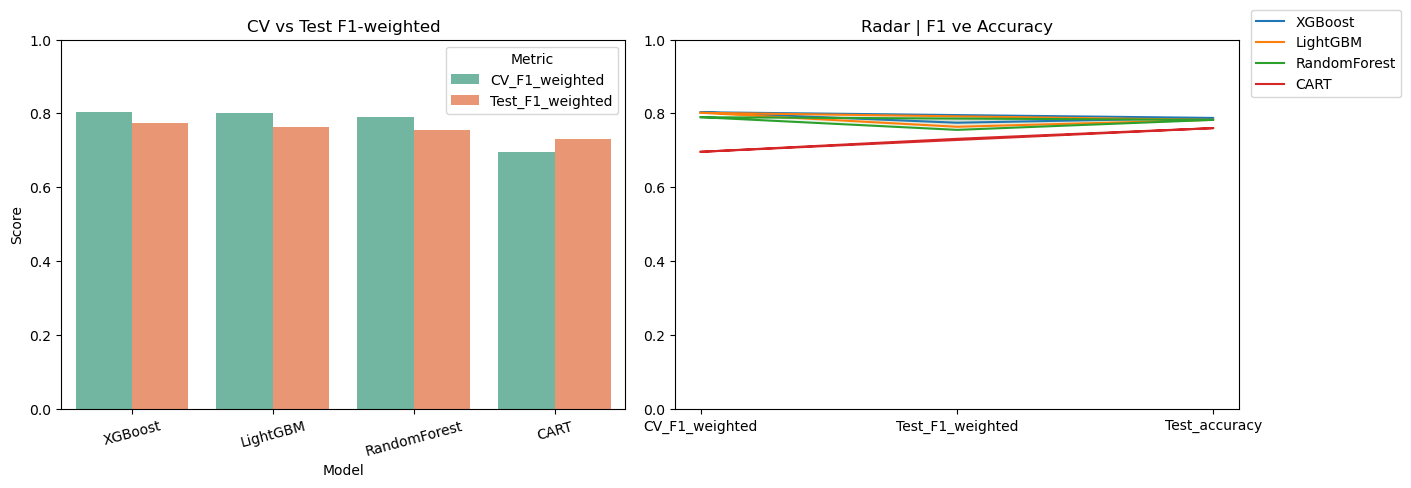

In [46]:
# === Multi-class HPO (Optuna + ROC/F1 görselleri) ===
import os
import optuna
from math import pi
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print("XGBoost import edilemedi; bu model Optuna aramasında atlanacak.")

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False
    print("LightGBM import edilemedi; bu model Optuna aramasında atlanacak.")

# --- 1) Multi-class hedef: Q2 & Q3 birleştirilmiş ---
CLASS_Q = np.linspace(0, 1, 6)
bin_edges = np.quantile(train[TARGET], CLASS_Q)
bin_edges = np.unique(bin_edges)
if len(bin_edges) - 1 < 3:
    bin_edges = np.linspace(train[TARGET].min(), train[TARGET].max(), 4)

bin_edges[0] -= 1e-6
bin_edges[-1] += 1e-6
labels = [f"Q{i+1}" for i in range(len(bin_edges) - 1)]

train_cls_raw = pd.cut(train[TARGET], bins=bin_edges, labels=labels, include_lowest=True).astype(str)
test_cls_raw = pd.cut(test[TARGET], bins=bin_edges, labels=labels, include_lowest=True).astype(str)

merge_map = {"Q2": "Q2_3", "Q3": "Q2_3"}
train_cls = train_cls_raw.replace(merge_map)
test_cls = test_cls_raw.replace(merge_map)

category_order = ["Q1", "Q2_3", "Q4", "Q5"]
train_cls = pd.Categorical(train_cls, categories=category_order, ordered=True)
test_cls = pd.Categorical(test_cls, categories=category_order, ordered=True)

mask_train = ~pd.isna(train_cls)
mask_test = ~pd.isna(test_cls)

X_train_cls = train.loc[mask_train, feat_cols].fillna(0.0).reset_index(drop=True)
X_test_cls = test.loc[mask_test, feat_cols].fillna(0.0).reset_index(drop=True)
y_train_cls = pd.Series(train_cls[mask_train]).reset_index(drop=True)
y_test_cls = pd.Series(test_cls[mask_test]).reset_index(drop=True)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_cls)
y_test_enc = le.transform(y_test_cls)
num_classes = len(le.classes_)

train_counts = y_train_cls.value_counts()
test_counts = y_test_cls.value_counts()
print("Multi-class dağılımları (train/test):")
print(train_counts.sort_index())
print(test_counts.sort_index())

def balanced_weight_map(counts, power=1.15):
    total = counts.sum()
    k = len(counts)
    weights = np.power(total / (k * counts), power)
    return weights.to_dict()

raw_class_weights = balanced_weight_map(train_counts, power=1.15)
cls_sample_weight = np.power(compute_sample_weight("balanced", y_train_enc), 1.15)

# --- 2) Model konfigürasyonları ---
CLASSIFIERS = {
    "CART": dict(
        make_estimator=lambda params: DecisionTreeClassifier(**params),
        param_space=lambda trial: dict(
            max_depth=trial.suggest_int("max_depth", 6, 10),
            min_samples_split=trial.suggest_int("min_samples_split", 8, 15),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 3, 7),
            class_weight="balanced",
            random_state=42,
        ),
        supports_sample_weight=True,
        n_trials=12,
    ),
    "RandomForest": dict(
        make_estimator=lambda params: RandomForestClassifier(**params),
        param_space=lambda trial: dict(
            n_estimators=trial.suggest_int("n_estimators", 320, 480),
            max_depth=trial.suggest_int("max_depth", 12, 18),
            min_samples_split=trial.suggest_int("min_samples_split", 3, 8),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 4),
            max_features=trial.suggest_float("max_features", 0.32, 0.5),
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
        ),
        supports_sample_weight=True,
        n_trials=10,
    ),
}

if HAS_XGB:
    CLASSIFIERS["XGBoost"] = dict(
        make_estimator=lambda params: XGBClassifier(**params),
        param_space=lambda trial: dict(
            n_estimators=trial.suggest_int("n_estimators", 360, 600),
            max_depth=trial.suggest_int("max_depth", 3, 5),
            learning_rate=trial.suggest_float("learning_rate", 0.045, 0.11),
            subsample=trial.suggest_float("subsample", 0.7, 0.92),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.62, 0.84),
            min_child_weight=trial.suggest_float("min_child_weight", 4.5, 11.5),
            reg_alpha=trial.suggest_float("reg_alpha", 1.0, 4.0),
            reg_lambda=trial.suggest_float("reg_lambda", 1.0, 4.0),
            objective="multi:softprob",
            eval_metric="mlogloss",
            num_class=num_classes,
            random_state=42,
            n_jobs=-1,
        ),
        supports_sample_weight=True,
        n_trials=12,
    )
else:
    print("XGBoost import edilemedi; Optuna XGBoost adımı atlanacak.")

if HAS_LGBM:
    def lgbm_param_space(trial):
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 320, 520),
            learning_rate=trial.suggest_float("learning_rate", 0.045, 0.11),
            max_depth=trial.suggest_int("max_depth", 7, 10),
            num_leaves=trial.suggest_int("num_leaves", 56, 90),
            min_child_samples=trial.suggest_int("min_child_samples", 40, 65),
            min_split_gain=trial.suggest_float("min_split_gain", 0.0, 0.005),
            subsample=trial.suggest_float("subsample", 0.72, 0.9),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 0.82),
            reg_alpha=trial.suggest_float("reg_alpha", 0.8, 2.0),
            reg_lambda=trial.suggest_float("reg_lambda", 1.0, 2.5),
            objective="multiclass",
            random_state=42,
            verbosity=-1,
            num_class=num_classes,
            force_col_wise=True,
        )
        raw_weights = balanced_weight_map(train_counts, power=1.15)
        params["class_weight"] = {
            int(le.transform([label])[0]): float(weight)
            for label, weight in raw_weights.items()
        }
        return params

    CLASSIFIERS["LightGBM"] = dict(
        make_estimator=lambda params: LGBMClassifier(**params),
        param_space=lgbm_param_space,
        supports_sample_weight=True,
        n_trials=12,
    )
else:
    print("LightGBM import edilemedi; Optuna LightGBM adımı atlanacak.")

# --- 3) Optuna optimizasyonu ---
splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []
best_models_cls = {}
cls_reports = {}

def cv_f1_weighted(estimator_factory, params, supports_sample_weight=True):
    scores = []
    for tr_idx, val_idx in splitter.split(X_train_cls, y_train_enc):
        Xtr, Xval = X_train_cls.iloc[tr_idx], X_train_cls.iloc[val_idx]
        ytr, yval = y_train_enc[tr_idx], y_train_enc[val_idx]
        wtr = cls_sample_weight[tr_idx]
        model = estimator_factory(params)
        if supports_sample_weight:
            model.fit(Xtr, ytr, sample_weight=wtr)
        else:
            model.fit(Xtr, ytr)
        yhat = model.predict(Xval)
        scores.append(f1_score(yval, yhat, average="weighted"))
    return float(np.mean(scores))

for name, spec in CLASSIFIERS.items():
    print(f"\n>>> {name} optimizasyonu başlıyor...")

    def objective(trial):
        params = spec["param_space"](trial)
        return cv_f1_weighted(spec["make_estimator"], params, spec["supports_sample_weight"])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=spec.get("n_trials", 12), show_progress_bar=False)
    best_params = study.best_params
    print(f"En iyi parametreler: {best_params}")
    print(f"CV (f1_weighted) en iyi değer: {study.best_value:.4f}")

    model = spec["make_estimator"](best_params)
    if spec["supports_sample_weight"]:
        model.fit(X_train_cls, y_train_enc, sample_weight=cls_sample_weight)
    else:
        model.fit(X_train_cls, y_train_enc)
    best_models_cls[name] = model

    y_pred = model.predict(X_test_cls)
    test_f1_weighted = f1_score(y_test_enc, y_pred, average="weighted")
    test_f1_macro = f1_score(y_test_enc, y_pred, average="macro")
    test_acc = accuracy_score(y_test_enc, y_pred)

    results.append({
        "Model": name,
        "CV_F1_weighted": study.best_value,
        "Test_F1_weighted": test_f1_weighted,
        "Test_F1_macro": test_f1_macro,
        "Test_accuracy": test_acc,
    })

    report = classification_report(y_test_enc, y_pred, target_names=le.classes_, digits=3)
    cls_reports[name] = report
    print("\nClassification report:\n", report)

results_df = (
    pd.DataFrame(results)
    .sort_values("Test_F1_weighted", ascending=False)
    .reset_index(drop=True)
)

if not results_df.empty:
    display(
        results_df.style.format({
            "CV_F1_weighted": "{:.3f}",
            "Test_F1_weighted": "{:.3f}",
            "Test_F1_macro": "{:.3f}",
            "Test_accuracy": "{:.3f}",
        }).background_gradient(subset=["Test_F1_weighted", "Test_accuracy"], cmap="YlGn")
    )
else:
    print("Hiçbir model eğitilemedi.")

# --- 4) Gruplanmış bar & radar ---
if not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(
        data=results_df.melt(
            id_vars="Model",
            value_vars=["CV_F1_weighted", "Test_F1_weighted"],
            var_name="Metric",
            value_name="Score",
        ),
        x="Model",
        y="Score",
        hue="Metric",
        palette="Set2",
        ax=axes[0],
    )
    axes[0].set_ylim(0, 1)
    axes[0].set_title("CV vs Test F1-weighted")
    axes[0].tick_params(axis="x", rotation=15)

    radar_metrics = ["CV_F1_weighted", "Test_F1_weighted", "Test_accuracy"]
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]
    for model_name in results_df["Model"]:
        values = results_df.loc[results_df["Model"] == model_name, radar_metrics].values.flatten().tolist()
        values += values[:1]
        axes[1].plot(angles, values, label=model_name)
        axes[1].fill(angles, values, alpha=0.1)
    axes[1].set_xticks(angles[:-1])
    axes[1].set_xticklabels(radar_metrics)
    axes[1].set_ylim(0, 1)
    axes[1].set_title("Radar | F1 ve Accuracy")
    axes[1].legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()

### Analiz: Çok Sınıflı Fiyat Kategorizasyonu ve Model Karşılaştırması

Bu analiz, fiyatların yalnızca "spike/normal" olarak değil, **farklı fiyat aralıklarına (kategorilere)** ayrıldığı bir çok sınıflı sınıflandırma problemine odaklanır. Amaç: **“Bir sonraki saatin fiyatı hangi aralıkta olacak?”** sorusunu en doğru şekilde yanıtlayan modeli bulmaktır.

### 1. Kodun Özeti: Fiyat Kategorilerini Tahmin Etme

#### 1.1 Çok Sınıflı Hedef
- Fiyatlar kantillere göre 5 gruba (Q1–Q5) ayrılır.  
- Orta seviyeler (Q2, Q3) birleştirilerek **4 sınıflı hedef** elde edilir:  
  **Q1 (çok düşük), Q2_3 (orta), Q4 (yüksek), Q5 (çok yüksek).**

#### 1.2 Veri Dengesizliği ile Başa Çıkma
- Sınıflar eşit sayıda değildir.  
- `class_weight="balanced"` ve `compute_sample_weight` kullanılarak, azınlık sınıflarındaki hataların daha çok “cezalandırılması” sağlanır.

#### 1.3 Model Karşılaştırma
- Modeller: **CART (DecisionTree), RandomForest, XGBoost, LightGBM**.  
- **Optuna** ile hiperparametre optimizasyonu yapılır.  
- Hedef metrik: **weighted F1-score** (dengesiz veri için accuracy’den daha güvenilir).

#### 1.4 Değerlendirme ve Raporlama
- En iyi hiperparametrelerle modeller test setinde değerlendirilir.  
- **Classification report**: her sınıf için Precision, Recall, F1.  
- Genel karşılaştırma: tablo + grafikler.

---

### 2. Sonuçlar

#### 2.1 Sınıf Dağılımları
- **Train seti**: Görece dengeli.  
- **Test seti**: Aşırı dengesiz; örneklerin büyük çoğunluğu (**1223 adet**) **Q5 (çok yüksek)** sınıfında.  
- **Sonuç:** Test dönemi genel olarak yüksek fiyatlıdır. Accuracy tek başına yanıltıcıdır; F1-score kritik öneme sahiptir.

#### 2.2 Model Performansları
- **XGBoost**, en yüksek weighted F1 (0.775) ve accuracy (0.788) ile öne çıkmıştır.  
- **LightGBM**, çok yakın ikinci sıradadır.  
- RF ve CART daha geridedir.  

#### 2.3 XGBoost’un Detaylı Raporu
- **Q1 (düşük fiyat)** → F1 = 0.881  
- **Q5 (çok yüksek fiyat)** → F1 = 0.895  
- **Q2_3 (orta)** → F1 = 0.463  
- **Q4 (yüksek)** → F1 = 0.246  

**Sonuç:**  
- Uç değerlerde (çok düşük/çok yüksek fiyat) başarılı.  
- Orta seviyelerde ayrım yapmakta zorlanıyor.  
- Tüm modellerde benzer eğilim görülüyor.

### 3. Grafikler

#### CV vs Test F1-weighted
- **XGBoost ve LightGBM**: CV ve test skorları arasında büyük fark yok, yani genelleme kabiliyetleri yüksek.  
- **RandomForest**: CV’de daha güçlü görünürken testte hafif düşüş yaşanıyor.  
- **CART**: CV’de en düşük, testte biraz toparlasa da diğer modellere göre geride kalıyor.  

#### Radar Grafiği
- **XGBoost, LightGBM ve RF**, benzer çizgiler izleyerek birbirine yakın performans gösteriyor.  
- **CART**, hem F1 hem accuracy açısından alt seviyede kalıyor.  
- Genel olarak, grafikler XGBoost ve LightGBM’in stabil ve önde olduğunu, CART’ın zayıf kaldığını görsel olarak doğruluyor.

---

### 4. Genel Sonuçlar
- **Pratik değer:** Enerji ticareti gibi alanlarda, fiyatın tam değerinden çok **“yüksek riskli/çok yüksek fiyat”** sınıfına girip girmeyeceğini bilmek kritik olabilir. XGBoost, **Q5 için %89.5 F1 skoru** ile bu ihtiyacı güçlü şekilde karşılıyor.  
- **Zayıflıklar:** Orta aralıklar (Q2_3, Q4) iyi yakalanamıyor. Gelecek çalışmalarda bu sınıfların tanımı veya özellik mühendisliği geliştirilmeli.  
- **En iyi model:** Bu problem için **XGBoost**, en dengeli ve başarılı modeldir. LightGBM yakın bir alternatif olarak düşünülebilir.

## 13) Özellik Önemi / Katsayılar

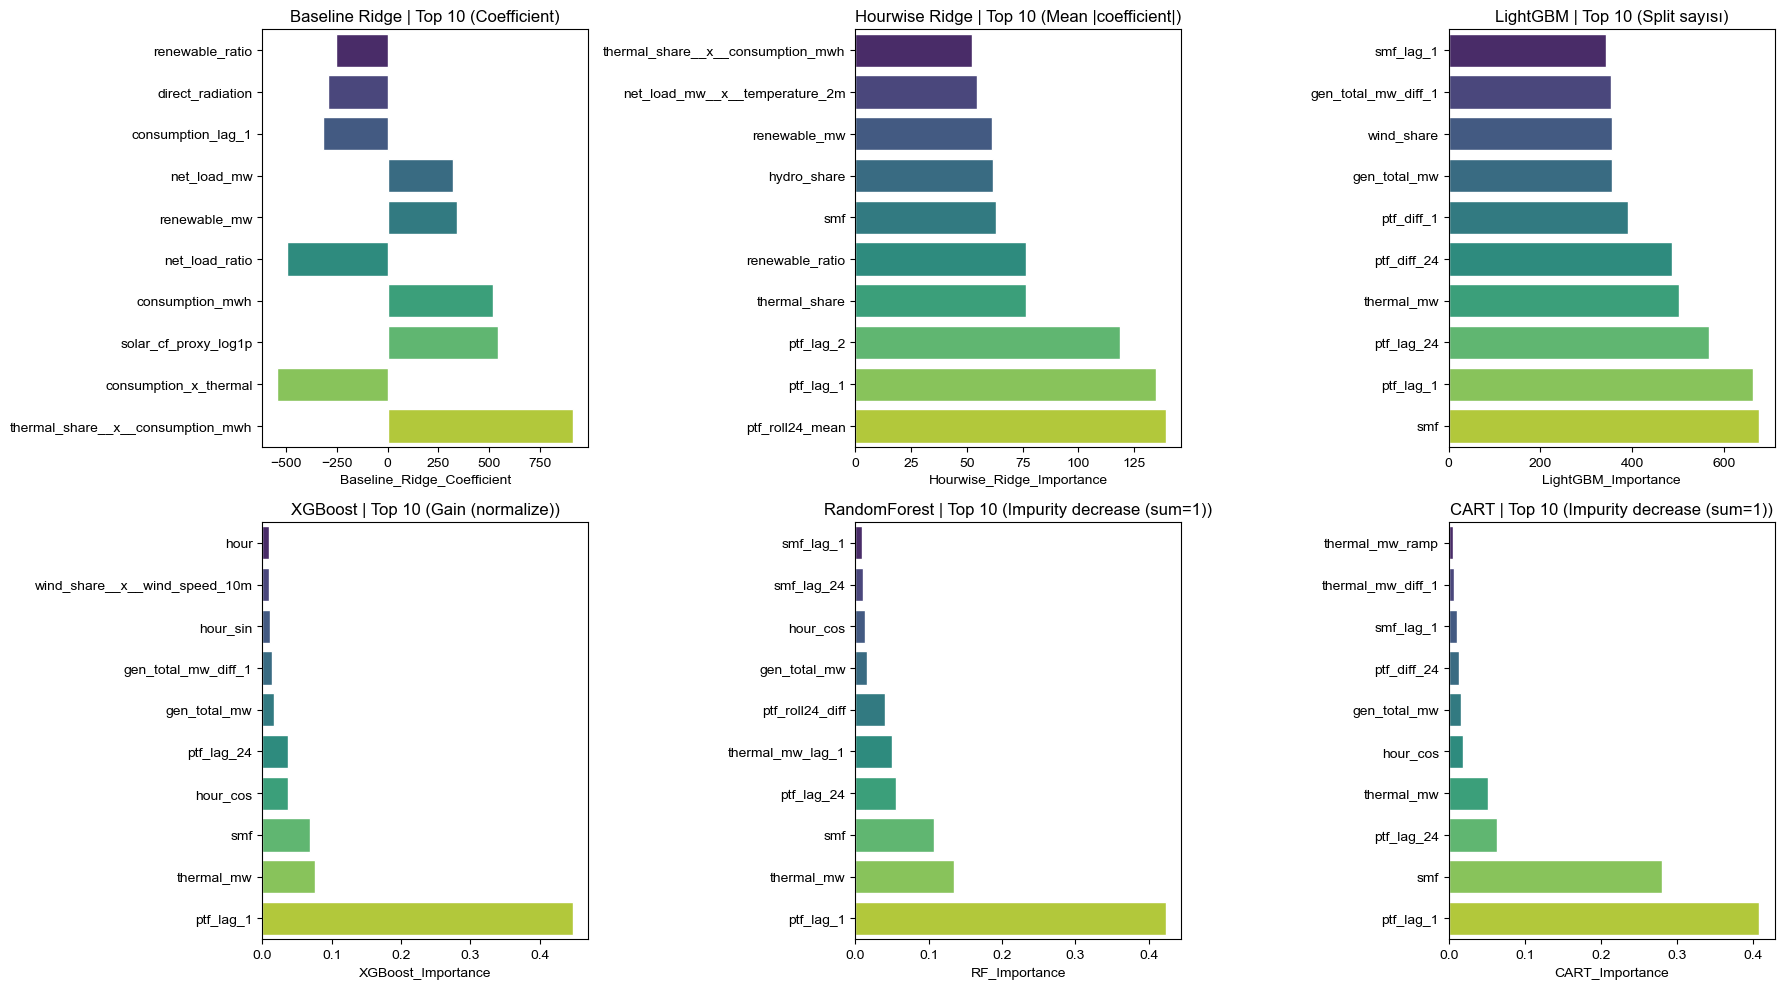

Feature  Baseline_Ridge_Coefficient  Hourwise_Ridge_Importance  LightGBM_Importance  XGBoost_Importance  RF_Importance  CART_Importance
0                   consumption_lag_1                 -320.865462                        NaN                  NaN                 NaN            NaN              NaN
1                     consumption_mwh                  520.243485                        NaN                  NaN                 NaN            NaN              NaN
2               consumption_x_thermal                 -545.561447                        NaN                  NaN                 NaN            NaN              NaN
3                    direct_radiation                 -296.515558                        NaN                  NaN                 NaN            NaN              NaN
4                        gen_total_mw                         NaN                        NaN                357.0            0.017099       0.016270         0.015618
5                 gen_total_mw_diff_1                         NaN                        NaN                355.0            0.014164            NaN              NaN
6                                hour                         NaN                        NaN                  NaN            0.009838            NaN              NaN
7                            hour_cos                         NaN                        NaN                  NaN            0.037221       0.012578         0.018950
8                            hour_sin                         NaN                        NaN                  NaN            0.011280            NaN              NaN
9                         hydro_share                         NaN                  61.718236                  NaN                 NaN            NaN              NaN
10                        net_load_mw                  321.416872                        NaN                  NaN                 NaN            NaN              NaN
11     net_load_mw__x__temperature_2m                         NaN                  54.486050                  NaN                 NaN            NaN              NaN
12                     net_load_ratio                 -495.017960                        NaN                  NaN                 NaN            NaN              NaN
13                         ptf_diff_1                         NaN                        NaN                392.0                 NaN            NaN              NaN
14                        ptf_diff_24                         NaN                        NaN                488.0                 NaN            NaN         0.013892
15                          ptf_lag_1                         NaN                 134.822230                664.0            0.447610       0.423584         0.407908
16                          ptf_lag_2                         NaN                 118.554722                  NaN                 NaN            NaN              NaN
17                         ptf_lag_24                         NaN                        NaN                567.0            0.036570       0.056025         0.063980
18                    ptf_roll24_diff                         NaN                        NaN                  NaN                 NaN       0.040401              NaN
19                    ptf_roll24_mean                         NaN                 139.208795                  NaN                 NaN            NaN              NaN
20                       renewable_mw                  341.493818                  61.457977                  NaN                 NaN            NaN              NaN
21                    renewable_ratio                 -253.944340                  76.420883                  NaN                 NaN            NaN              NaN
22                                smf                         NaN                  62.842598                677.0            0.069411       0.106878         0.279946
23                          smf_lag_1         

In [48]:
# === Model Bazlı Özellik Önemleri (Top 10) ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.set_style("whitegrid")

importance_tables = []
panel_spec = [
    ("Baseline Ridge", axes[0, 0], "Coefficient"),
    ("Hourwise Ridge", axes[0, 1], "Mean |coefficient|"),
    ("LightGBM", axes[0, 2], "Split sayısı"),
    ("XGBoost", axes[1, 0], "Gain (normalize)"),
    ("RandomForest", axes[1, 1], "Impurity decrease (sum=1)"),
    ("CART", axes[1, 2], "Impurity decrease (sum=1)"),
]

def top10_coeff(values, label):
    series = pd.Series(values, index=feat_cols)
    order = series.abs().sort_values(ascending=False).head(10).index
    return pd.DataFrame({"Feature": order, label: series.loc[order].values})

def top10_importance(model, label):
    if model is None or not hasattr(model, "feature_importances_"):
        return None
    imp = pd.Series(model.feature_importances_, index=feat_cols).sort_values(ascending=False)
    top = imp.head(10).reset_index()
    top.columns = ["Feature", label]
    return top

# 1) Baseline Ridge
baseline_top = top10_coeff(
    ridge_pipeline.named_steps["ridge"].coef_, "Baseline_Ridge_Coefficient"
) if "ridge_pipeline" in globals() else None

# 2) Hourwise Ridge
hourwise_top = None
if "best_alpha_by_hour" in globals() and best_alpha_by_hour:
    coef_rows = []
    for hour, alpha in best_alpha_by_hour.items():
        mask = train["timestamp"].dt.hour == hour
        if mask.sum() == 0:
            continue
        mdl = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("ridge", Ridge(alpha=float(alpha))),
        ])
        mdl.fit(train.loc[mask, feat_cols].fillna(0.0), train.loc[mask, TARGET].astype(float))
        coef_rows.append(pd.DataFrame({
            "Feature": feat_cols,
            "Hour": hour,
            "Coef": mdl.named_steps["ridge"].coef_,
        }))
    if coef_rows:
        hourwise_coef_df = pd.concat(coef_rows, ignore_index=True)
        hourwise_top = (
            hourwise_coef_df.assign(Abs=lambda df: df["Coef"].abs())
            .groupby("Feature")["Abs"].mean()
            .sort_values(ascending=False)
            .head(10)
            .reset_index()
            .rename(columns={"Abs": "Hourwise_Ridge_Importance"})
        )

# 3) LightGBM
lgbm_top = top10_importance(best_lgbm, "LightGBM_Importance") \
    if "best_lgbm" in globals() and best_lgbm is not None else None

# 4) XGBoost
best_xgb_model = globals().get("best_xgb")
if best_xgb_model is None and "best_models_cls" in globals():
    best_xgb_model = best_models_cls.get("XGBoost")
xgb_top = top10_importance(best_xgb_model, "XGBoost_Importance")

# 5) RandomForest
rf_model = None
for key in ("best_rf", "rf_model", "random_forest_model"):
    if key in globals() and hasattr(globals()[key], "feature_importances_"):
        rf_model = globals()[key]
        break
if rf_model is None and "best_models_cls" in globals():
    rf_model = best_models_cls.get("RandomForest")
rf_top = top10_importance(rf_model, "RF_Importance")

# 6) CART
cart_model = globals().get("best_cart")
if cart_model is None and "best_models_cls" in globals():
    cart_model = best_models_cls.get("CART")
cart_top = top10_importance(cart_model, "CART_Importance")

panel_map = {
    "Baseline Ridge": baseline_top,
    "Hourwise Ridge": hourwise_top,
    "LightGBM": lgbm_top,
    "XGBoost": xgb_top,
    "RandomForest": rf_top,
    "CART": cart_top,
}

for title, ax, unit in panel_spec:
    df = panel_map.get(title)
    if df is not None and not df.empty:
        sns.barplot(data=df.iloc[::-1], x=df.columns[1], y="Feature", palette="viridis", ax=ax)
        ax.set_title(f"{title} | Top 10 ({unit})")
        ax.set_xlabel(df.columns[1])
        ax.set_ylabel("")
        importance_tables.append(df)
    else:
        ax.axis("off")
        ax.text(0.5, 0.5, f"{title} verisi yok", ha="center", va="center")

plt.tight_layout()
plt.show()

if importance_tables:
    merged_imp = importance_tables[0]
    for tbl in importance_tables[1:]:
        merged_imp = merged_imp.merge(tbl, on="Feature", how="outer")
    display(merged_imp.sort_values("Feature").reset_index(drop=True))

### Model Bazlı Özellik Önemleri

### 1) Çıktının kısa okuması (grafikler + tablo)

#### 1.1 Ortak/kesişen güçlü sinyaller
- **ptf_lag_1** → *tüm ağaç modellerinde* 1 numaralı özellik (LGBM split=664; XGB gain=0.448; RF=0.424; CART=0.408).  
  ↳ **Son saat PTF gecikmesi** en kuvvetli öngörücü.
- **ptf_lag_24** → LGBM/RF/CART’ta öne çıkıyor (günlük mevsimsellik).  
- **smf** → LGBM/RF/CART’ta yüksek. (Kullanım anında **sızıntı (leakage)** olmamasına dikkat!)
- **thermal_mw** ve **gen_total_mw** → üretim düzeyi/mix sinyalleri önemli.
- **hour_cos (ve kısmen hour/sin)** → döngüsellik sinyali (gün içi saat etkisi).

#### 1.2 Ridge’lerde (lineer bakış) öne çıkanlar
- **thermal_share__x__consumption_mwh** *(≈ +916)* ve **consumption_mwh** *(≈ +520)*  
  → Talep ve **termal pay × tüketim etkileşimi** çok güçlü **pozitif** ilişki veriyor.  
- **consumption_x_thermal** *(≈ −546)*, **net_load_ratio** *(≈ −495)*, **direct_radiation** *(≈ −297)*  
  → Bazı etkileşimler ve ışınım/ratio göstergeleri **negatif** yönlü etki taşıyor.  
- **solar_cf_proxy_log1p** *(≈ +544)*  
  → Güneş kapasite faktörü proxysi pozitif etki sağlıyor.
- **Hourwise Ridge**: `ptf_roll24_mean`, `ptf_lag_1/2`, `thermal_share`, `renewable_ratio/mw`, `smf`, `hydro_share`,  
  `net_load_mw × temperature_2m` gibi saat-özgü etkiler **ortalama |coef|** bazında öne çıkıyor.  
  ↳ **Saatlere bağlı rejim farklarını** lineer model de yakalıyor.

#### 1.3 Ağaç modelleri (non-lineer bakış)
- **LightGBM (split sayısı)**: `smf`, `ptf_lag_1`, `ptf_lag_24`, `thermal_mw`, `ptf_diff_24`, `ptf_diff_1`, `gen_total_mw`, `wind_share`  
  → *Lag + fark + üretim mix* üçlüsü kritik.
- **XGBoost (gain)**: `ptf_lag_1` açık ara → sonra `thermal_mw`, `smf`, `hour_cos`, `ptf_lag_24`, `gen_total_mw_diff_1` …  
- **RandomForest/CART**: `ptf_lag_1` ve `smf` yine en üstte; `thermal_mw`, `ptf_lag_24`, `ptf_roll24_diff` da önemli.

> **Tablodaki NaN’ler**: O özelliğin **ilgili modelin Top-10’una girmediğini** (ya da o panelde veri olmadığını) gösterir; “özellik yok” anlamına gelmez.


### 2) Pratik Çıkarımlar

1. **Minimum çekirdek set**  
   - **ptf_lag_1**, **ptf_lag_24**, **smf**, **thermal_mw**, **gen_total_mw**, **hour_cos** → Her model ailesinde güçlü.  
   - Bu çekirdek set, *hem lineer hem ağaç* modeller için omurga niteliğinde.

2. **Rejim/karışım etkileri**  
   - `renewable_ratio`, `thermal_share`, `hydro_share` ve **talep (consumption/net_load)** etkileşimleri tahmini belirgin etkiliyor.  
   - Hourwise Ridge’in bu değişkenleri ortalama |coef| bazında taşıması, **saat-bazlı** modellemenin değerini destekliyor.

3. **Özellik mühendisliği fırsatları**  
   - **Farklar ve ramp’lar** (`*_diff_1`, `*_ramp`) bazı panellerde görünür; daha sistematik ramp/volatilite öznitelikleri eklenebilir.  
   - `net_load_mw × temperature_2m` gibi **etkileşimler** etkili; rüzgâr/güneş CF proxy’leriyle benzer etkileşimler denenebilir.

4. **Sızıntı (leakage) kontrolü**  
   - **smf** ve benzeri değişkenlerin, **tahmin çıktısı ile aynı anda öğrenilebilir** olmaması gerekir. Operasyonda mevcut değilse **çıkar** ya da gecikmeli/forecast versiyonunu kullan.

5. **Ölçek/yorum farkı**  
   - Ridge katsayıları **işaret & büyüklük** (lineer etki) sunar;  
   - Ağaç önemleri **bölünme / kazanç / safsızlık** ölçer. **Sayısal değerler arası kıyas** model türleri arasında **yapılmamalı**; sadece **sıra**/göreli önem okunmalı.

>  Ağaç ailelerinde `ptf_lag_1` **tartışmasız #1**. Lineerde ise **talep × termal pay etkileşimi** çok güçlü pozitif, bazı oran/radyasyon göstergeleri negatif etkili çıkıyor.

---

Kod doğru şekilde **model-özgü önem** panelleri üretip **tek tabloda birleştiriyor**. Çıktı, **lag-temelli sinyaller + üretim-mix + saatlik döngüsellik** üçlüsünün ana belirleyiciler olduğunu; lineer bakışın ise **etkileşimlerin işaret ve büyüklüğü** açısından ek sezgi sağladığını gösteriyor.

## 14) Değerlendirme ve Raporlama



In [51]:
# === Raporlama ve Görselleştirme ===
import os
import json
import base64
from io import BytesIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

REPORT_DIR = os.path.join(RUN_DIR, "report_artifacts")
os.makedirs(REPORT_DIR, exist_ok=True)

metrics_rf = (
    globals().get("metrics_rf")
    or globals().get("metrics_random_forest")
    or globals().get("metrics_random_forest_reg")
    or globals().get("metrics_rf_reg")
)
metrics_baseline = globals().get("metrics_baseline")
metrics_hourwise = globals().get("hourwise_metrics")

# ---- Model metrikleri tablosu ----
reports = []
for name, metrics in (
    ("Baseline Ridge", metrics_baseline),
    ("LightGBM", metrics_lgbm),
    ("XGBoost", metrics_xgb),
    ("RandomForest", metrics_rf),
    ("Stacking", metrics_stack),
    ("Voting", metrics_vote),
):
    if isinstance(metrics, dict) and metrics:
        reports.append({"Model": name, **metrics})

reports_df = pd.DataFrame(reports)
if not reports_df.empty:
    styled_metrics = (
        reports_df.style.background_gradient(subset=["RMSE", "MAE"], cmap="RdYlGn_r")
        .format({"RMSE": "{:.2f}", "MAE": "{:.2f}", "MAPE%": "{:.2f}", "sMAPE%": "{:.2f}", "R2": "{:.3f}"})
    )
    display(styled_metrics)
else:
    styled_metrics = None
    print("Model metrikleri üretilemedi; rapor tablosu boş.")

# ---- Tahmin tablosu ----
preds_export = preds.rename(columns={TARGET: "y_true"}).copy()

prediction_columns = {
    "Baseline Ridge": f"{TARGET}_pred",
    "LightGBM": f"{TARGET}_pred_lgbm",
    "XGBoost": f"{TARGET}_pred_xgb",
    "RandomForest": f"{TARGET}_pred_rf",
    "Stacking": f"{TARGET}_pred_stack",
    "Voting": f"{TARGET}_pred_vote",
    "Spike two-stage": f"{TARGET}_pred_two_stage",
}

primary_pred_col = None
if "model_comparison" in globals() and not model_comparison.empty:
    primary_pred_col = prediction_columns.get(model_comparison.iloc[0]["model"])
if not primary_pred_col or primary_pred_col not in preds_export.columns:
    for col in prediction_columns.values():
        if col in preds_export.columns:
            primary_pred_col = col
            break
if not primary_pred_col:
    raise RuntimeError("No prediction column available for reporting.")

preds_export = preds_export.sort_values("timestamp")
preds_export["hour"] = preds_export["timestamp"].dt.hour
preds_export["abs_err"] = (preds_export["y_true"] - preds_export[primary_pred_col]).abs()

for col in preds_export.columns:
    if pd.api.types.is_datetime64tz_dtype(preds_export[col]):
        preds_export[col] = preds_export[col].dt.tz_convert(None)

# ---- Çoklu sınıf ve önem tabloları ----
multiclass_df = globals().get("results_df") if isinstance(globals().get("results_df"), pd.DataFrame) else pd.DataFrame()
cls_reports = globals().get("cls_reports") if isinstance(globals().get("cls_reports"), dict) else {}
importance_df = globals().get("merged_imp") if isinstance(globals().get("merged_imp"), pd.DataFrame) else pd.DataFrame()

# ---- Excel ----
excel_path = None
excel_engine = "openpyxl"
try:
    import openpyxl  # type: ignore
except ImportError:
    try:
        import xlsxwriter  # type: ignore
        excel_engine = "xlsxwriter"
    except ImportError:
        excel_engine = None
        print("Excel engines not available; skipping Excel report.")

if excel_engine:
    excel_path = os.path.join(REPORT_DIR, "report.xlsx")
    with pd.ExcelWriter(excel_path, engine=excel_engine) as writer:
        if styled_metrics is not None:
            styled_metrics.to_excel(writer, sheet_name="Metrics", index=False)
        else:
            pd.DataFrame({"Info": ["Model metrics not available"]}).to_excel(writer, sheet_name="Metrics", index=False)
        preds_export.to_excel(writer, sheet_name="Predictions", index=False)
        if not multiclass_df.empty:
            multiclass_df.to_excel(writer, sheet_name="Multiclass", index=False)
        if not importance_df.empty:
            importance_df.to_excel(writer, sheet_name="FeatureImportances", index=False)
        if metrics_hourwise is not None and not getattr(metrics_hourwise, 'empty', True):
            metrics_hourwise.to_excel(writer, sheet_name="Hourwise_Ridge", index=False)
        if 'distribution_shift_df' in globals() and not distribution_shift_df.empty:
            distribution_shift_df.to_excel(writer, sheet_name="FeatureShift", index=False)
    print("Excel report written:", excel_path)

# ---- Sınıflandırma raporlarını kaydet ----
# ---- Sınıflandırma raporlarını kaydet ----
cls_report_paths = []
if cls_reports:
    reports_dir = os.path.join(REPORT_DIR, "classification_reports")
    os.makedirs(reports_dir, exist_ok=True)
    for model_name, text in cls_reports.items():
        path = os.path.join(reports_dir, f"{model_name}_classification_report.txt")
        with open(path, "w", encoding="utf-8") as f:
            f.write(text)
        cls_report_paths.append(os.path.relpath(path, RUN_DIR))

# ---- Görseller ----
def save_and_embed(fig, filename, width=700):
    filepath = os.path.join(REPORT_DIR, filename)
    fig.savefig(filepath, bbox_inches="tight")
    with open(filepath, "rb") as f:
        b64 = base64.b64encode(f.read()).decode()
    plt.close(fig)
    return filepath, f"<li><img src='data:image/png;base64,{b64}' width='{width}'></li>"

plot_df = preds_export.tail(7 * 24)

fig_ts, ax = plt.subplots(figsize=(10, 5))
ax.plot(plot_df["timestamp"], plot_df["y_true"], label="Actual", alpha=0.8)
ax.plot(plot_df["timestamp"], plot_df[primary_pred_col], label="Prediction", alpha=0.8)
ax.set_title("Actual vs Prediction (last 7 days)")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.legend()
ax.grid(alpha=0.2)
plot_path, plot_tag = save_and_embed(fig_ts, "prediction_vs_actual.png")

fig_hist, ax = plt.subplots(figsize=(6, 4))
residuals = preds_export["y_true"] - preds_export[primary_pred_col]
sns.histplot(residuals, bins=30, kde=True, color="orange", ax=ax)
ax.set_title("Residual distribution")
ax.set_xlabel("Actual - Prediction")
ax.set_ylabel("Frequency")
ax.grid(alpha=0.2)
error_plot_path, error_tag = save_and_embed(fig_hist, "error_distribution.png")

hourly_mae = preds_export.groupby("hour").apply(lambda d: mean_absolute_error(d["y_true"], d[primary_pred_col]))
fig_hourly, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=hourly_mae.index, y=hourly_mae.values, marker="o", ax=ax)
ax.set_title("Hourly MAE")
ax.set_xlabel("Hour")
ax.set_ylabel("MAE")
ax.grid(alpha=0.2)
hourly_plot_path, hourly_tag = save_and_embed(fig_hourly, "hourly_mae.png")

heatmap_tag = ""
hourly_day_mae = (
    preds_export.assign(day=preds_export["timestamp"].dt.date)
    .pivot_table(values="abs_err", index="day", columns="hour", aggfunc="mean")
    .sort_index()
)
if not hourly_day_mae.empty:
    fig_heat, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(hourly_day_mae, cmap="mako", ax=ax)
    ax.set_title("Daily x Hour MAE heatmap")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Day")
    heatmap_path, heatmap_tag = save_and_embed(fig_heat, "mae_heatmap.png")
else:
    heatmap_path = ""
    print("Saat-gün MAE ısı haritası için veri bulunamadı.")

# ---- HTML ----
extra_sections = []
if not multiclass_df.empty:
    extra_sections.append("<h3>Multiclass Results</h3>")
    extra_sections.append(multiclass_df.to_html(index=False))
if not importance_df.empty:
    extra_sections.append("<h3>Feature Importances</h3>")
    extra_sections.append(importance_df.to_html(index=False))
if cls_report_paths:
    extra_sections.append("<h3>Classification Reports</h3>")
    extra_sections.append("<ul>" + "".join(f"<li>{path}</li>" for path in cls_report_paths) + "</ul>")
if 'distribution_shift_df' in globals() and not distribution_shift_df.empty:
    extra_sections.append("<h3>Feature Shift (Train vs Test)</h3>")
    extra_sections.append(distribution_shift_df.head(20).to_html(index=False))

html_sections = [
    "<h2>Model comparison</h2>",
    reports_df.to_html(index=False) if not reports_df.empty else "<p>Model metrics not available.</p>",
    "<hr>",
    "<h3>Visuals</h3>",
    "<ul>",
    plot_tag,
    error_tag,
    hourly_tag,
    heatmap_tag,
    "</ul>",
    *extra_sections,
]
html_content = "\n".join(filter(None, html_sections))
html_path = os.path.join(REPORT_DIR, "report.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_content)
print("HTML report written:", html_path)

# ---- Manifest ----
manifest = {
    "TARGET": TARGET,
    "CUT": CUT,
    "RUN_ID": RUN_ID,
    "created": time.ctime(),
    "n_rows": len(df_fe),
    "n_features": len(feat_cols),
    "best_alpha": best_alpha,
    "best_model": model_comparison.iloc[0]["model"] if not model_comparison.empty else "Baseline Ridge",
    "primary_prediction_column": primary_pred_col,
    "report_html": os.path.relpath(html_path, RUN_DIR),
    "fig_prediction_vs_actual": os.path.relpath(plot_path, RUN_DIR),
    "fig_residual_distribution": os.path.relpath(error_plot_path, RUN_DIR),
    "fig_hourly_mae": os.path.relpath(hourly_plot_path, RUN_DIR),
}
if heatmap_tag:
    manifest["fig_mae_heatmap"] = os.path.relpath(heatmap_path, RUN_DIR)
if metrics_baseline:
    manifest["baseline_ridge_metrics"] = metrics_baseline
if metrics_lgbm:
    manifest["lightgbm_metrics"] = metrics_lgbm
if metrics_xgb:
    manifest["xgboost_metrics"] = metrics_xgb
if metrics_rf:
    manifest["random_forest_metrics"] = metrics_rf
if metrics_stack:
    manifest["stacking_metrics"] = metrics_stack
if metrics_vote:
    manifest["voting_metrics"] = metrics_vote
if metrics_two_stage is not None:
    manifest["two_stage_metrics"] = metrics_two_stage
if "selected_threshold" in globals():
    manifest["spike_threshold_opt"] = float(selected_threshold)
if "worst_hours" in globals():
    manifest["worst_hours"] = list(map(int, worst_hours))
if not multiclass_df.empty:
    manifest["multiclass_best_model"] = multiclass_df.iloc[0]["Model"]
    manifest["multiclass_metrics"] = multiclass_df.to_dict(orient="records")
if cls_report_paths:
    manifest["classification_report_files"] = cls_report_paths
if not importance_df.empty:
    manifest["feature_importance_columns"] = list(importance_df.columns)
if 'distribution_shift_df' in globals() and not distribution_shift_df.empty:
    manifest["feature_shift_top"] = distribution_shift_df.head(10).to_dict(orient="records")

with open(os.path.join(RUN_DIR, "manifest.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

with open(os.path.join(RUN_DIR, "features.txt"), "w", encoding="utf-8") as f:
    for col in feat_cols:
        f.write(col + "\n")

print("Artifacts saved under:", RUN_DIR)

Excel report written: runs\eda_ptf_pipeline_clean\report_artifacts\report.xlsx
HTML report written: runs\eda_ptf_pipeline_clean\report_artifacts\report.html
Artifacts saved under: runs\eda_ptf_pipeline_clean


Train/Test dağılım farkları (KS istatistiğine göre ilk 15 özellik):


Feature   KS_stat  KS_pvalue    Wasserstein     Train_mean      Test_mean      Train_std       Test_std      Mean_diff  Mean_diff_std
0                HDH_roll_24_log1p  0.743523        0.0       3.461142       3.474635       0.013493       2.248595       0.105087      -3.461142      -1.539246
1                      HDH_roll_24  0.743523        0.0     118.617963     118.639120       0.021157     117.133483       0.167775    -118.617963      -1.012673
2                      CDH_roll_24  0.730676        0.0     101.515483      30.872165     132.387648      50.523137      41.925755     101.515483       2.009287
3                CDH_roll_24_log1p  0.730676        0.0       3.220107       1.609690       4.829797       2.042150       0.385613       3.220107       1.576823
4                        month_sin  0.717690        0.0       0.923436       0.200404      -0.723032       0.678468       0.200871      -0.923436      -1.361060
5                  ptf_roll24_mean  0.716148        0.0     652.111050    2285.848839    2937.959889     421.710465     269.273859     652.111050       1.546348
6   net_load_mw__x__temperature_2m  0.707471        0.0  493904.255973  417748.687616  911652.943589  288625.948146  255447.718302  493904.255973       1.711226
7          consumption_roll24_mean  0.691944        0.0    7343.016804   38916.548529   46259.565332    4274.112648    3268.584418    7343.016804       1.718021
8      consumption_mwh_roll24_mean  0.691644        0.0    7096.921373   38920.613237   46017.534610    4246.949241    2958.908529    7096.921373       1.671063
9                            month  0.660491        0.0       3.004878       5.561236       7.689372       3.293479       0.683106       2.128135       0.646166
10                  temperature_2m  0.657064        0.0      11.775993      15.660308      27.436301       8.492305       4.392051      11.775993       1.386666
11                      smf_lag_24  0.635097        0.0     726.632927    2204.179777    2930.812704     922.373227     808.993152     726.632927       0.787786
12         net_load_mw_roll24_mean  0.631220        0.0    6920.542522   25793.226144   32713.768666    5019.249762    2608.720879    6920.542522       1.378800
13                             CDH  0.630774        0.0       4.171984       1.289744       5.461728       2.846788       4.078698       4.171984       1.465506
14                       CDH_log1p  0.630774        0.0       1.182214       0.407286       1.589500       0.775492       0.827911       1.182214       1.524470

Uyarı: dağılımı belirgin değişen özellikler (önceliğe göre sıralı):


Feature   KS_stat  KS_pvalue    Wasserstein     Train_mean      Test_mean      Train_std       Test_std      Mean_diff  Mean_diff_std
1                      HDH_roll_24  0.743523        0.0     118.617963     118.639120       0.021157     117.133483       0.167775    -118.617963      -1.012673
0                HDH_roll_24_log1p  0.743523        0.0       3.461142       3.474635       0.013493       2.248595       0.105087      -3.461142      -1.539246
2                      CDH_roll_24  0.730676        0.0     101.515483      30.872165     132.387648      50.523137      41.925755     101.515483       2.009287
3                CDH_roll_24_log1p  0.730676        0.0       3.220107       1.609690       4.829797       2.042150       0.385613       3.220107       1.576823
4                        month_sin  0.717690        0.0       0.923436       0.200404      -0.723032       0.678468       0.200871      -0.923436      -1.361060
5                  ptf_roll24_mean  0.716148        0.0     652.111050    2285.848839    2937.959889     421.710465     269.273859     652.111050       1.546348
6   net_load_mw__x__temperature_2m  0.707471        0.0  493904.255973  417748.687616  911652.943589  288625.948146  255447.718302  493904.255973       1.711226
7          consumption_roll24_mean  0.691944        0.0    7343.016804   38916.548529   46259.565332    4274.112648    3268.584418    7343.016804       1.718021
8      consumption_mwh_roll24_mean  0.691644        0.0    7096.921373   38920.613237   46017.534610    4246.949241    2958.908529    7096.921373       1.671063
9                            month  0.660491        0.0       3.004878       5.561236       7.689372       3.293479       0.683106       2.128135       0.646166
10                  temperature_2m  0.657064        0.0      11.775993      15.660308      27.436301       8.492305       4.392051      11.775993       1.386666
11                      smf_lag_24  0.635097        0.0     726.632927    2204.179777    2930.812704     922.373227     808.993152     726.632927       0.787786
12         net_load_mw_roll24_mean  0.631220        0.0    6920.542522   25793.226144   32713.768666    5019.249762    2608.720879    6920.542522       1.378800
14                       CDH_log1p  0.630774        0.0       1.182214       0.407286       1.589500       0.775492       0.827911       1.182214       1.524470
13                             CDH  0.630774        0.0       4.171984       1.289744       5.461728       2.846788       4.078698       4.171984       1.465506
15                       smf_lag_2  0.626464        0.0     714.691556    2206.326761    2921.018318     922.564444     809.163791     714.691556       0.774679
16                       smf_lag_1  0.625799        0.0     713.750975    2206.445851    2920.196826     922.618544     809.387221     713.750975       0.773614
17                             smf  0.625135        0.0     712.802706    2206.572629    2919.375335     922.669246     809.609756     712.802706       0.772544
19                             HDH  0.608497        0.0       4.934897       4.935737       0.000840       5.284450       0.026301      -4.934897      -0.933853
18                       HDH_log1p  0.608497        0.0       1.244132       1.244749       0.000618       1.114713       0.018876      -1.244132      -1.116101

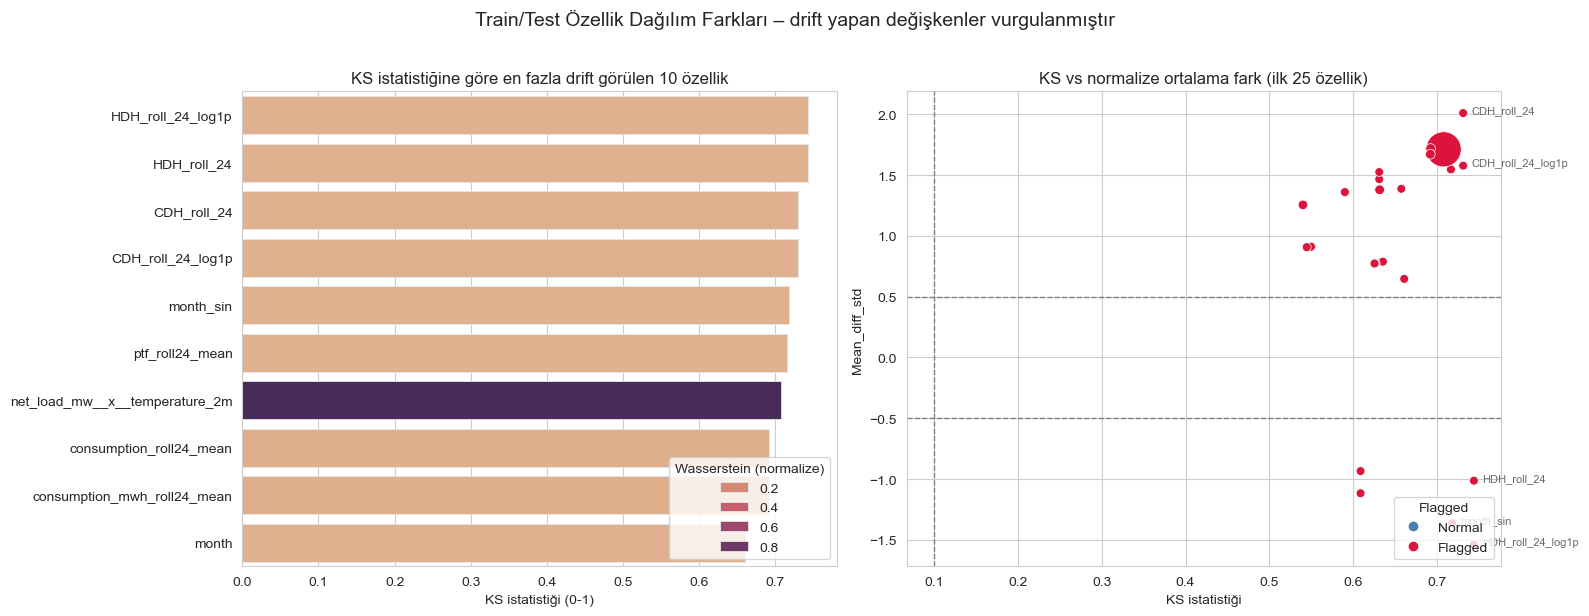

In [55]:
# === Train/Test Özellik Dağılım Karşılaştırması (KS & Wasserstein) ===
from scipy.stats import ks_2samp, wasserstein_distance
import matplotlib as mpl

if not {"train", "test", "feat_cols"} <= set(globals()):
    print("train/test/feat_cols değişkenleri bulunamadı; hücre atlandı.")
else:
    shift_rows = []
    for col in feat_cols:
        if col not in train.columns or col not in test.columns:
            continue

        tr = pd.to_numeric(train[col], errors="coerce").dropna()
        te = pd.to_numeric(test[col], errors="coerce").dropna()
        if len(tr) < 20 or len(te) < 20:
            continue

        ks_stat, ks_p = ks_2samp(tr, te)
        w_dist = wasserstein_distance(tr, te)

        tr_mean, te_mean = tr.mean(), te.mean()
        tr_std = tr.std(ddof=0)

        shift_rows.append({
            "Feature": col,
            "KS_stat": ks_stat,
            "KS_pvalue": ks_p,
            "Wasserstein": w_dist,
            "Train_mean": tr_mean,
            "Test_mean": te_mean,
            "Train_std": tr_std,
            "Test_std": te.std(ddof=0),
            "Mean_diff": te_mean - tr_mean,
            "Mean_diff_std": (te_mean - tr_mean) / (tr_std + 1e-9),
        })

    distribution_shift_df = (
        pd.DataFrame(shift_rows)
        .sort_values("KS_stat", ascending=False)
        .reset_index(drop=True)
    )

    if distribution_shift_df.empty:
        print("Dağılım karşılaştırması yapılacak yeterli sayısal özellik bulunamadı.")
    else:
        print("Train/Test dağılım farkları (KS istatistiğine göre ilk 15 özellik):")
        display(distribution_shift_df.head(15))

        ks_threshold = 0.10
        mean_shift_threshold = 0.5
        wass_threshold = distribution_shift_df["Train_std"].median() * 0.30

        shift_warning_df = distribution_shift_df[
            (distribution_shift_df["KS_stat"] >= ks_threshold)
            | (distribution_shift_df["Mean_diff_std"].abs() >= mean_shift_threshold)
            | (distribution_shift_df["Wasserstein"] >= wass_threshold)
        ]

        if shift_warning_df.empty:
            print(
                "Belirgin dağılım değişimi saptanmadı "
                f"(eşikler: KS ≥ {ks_threshold:.2f}, |Mean_diff_std| ≥ {mean_shift_threshold:.2f}, "
                f"Wasserstein ≥ {wass_threshold:.2f})."
            )
        else:
            print("Uyarı: dağılımı belirgin değişen özellikler (önceliğe göre sıralı):")
            display(
                shift_warning_df.sort_values(
                    ["KS_stat", "Mean_diff_std"], ascending=False
                ).head(20)
            )

        # --- Görsel özet ---
        top_bar = distribution_shift_df.head(10).copy()
        top_bar = top_bar.assign(
            Wasserstein_norm=lambda df: df["Wasserstein"] / (df["Wasserstein"].max() + 1e-9)
        )

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        sns.set_style("whitegrid")

        sns.barplot(
            data=top_bar,
            x="KS_stat",
            y="Feature",
            hue="Wasserstein_norm",
            palette="flare",
            dodge=False,
            edgecolor="0.9",
            linewidth=0.6,
            ax=axes[0],
        )
        axes[0].set_title("KS istatistiğine göre en fazla drift görülen 10 özellik")
        axes[0].set_xlabel("KS istatistiği (0-1)")
        axes[0].set_ylabel("")
        axes[0].legend(title="Wasserstein (normalize)", loc="lower right")

        scatter_df = distribution_shift_df.head(25).copy()
        scatter_df["Flagged"] = (
            (scatter_df["KS_stat"] >= ks_threshold)
            | (scatter_df["Mean_diff_std"].abs() >= mean_shift_threshold)
            | (scatter_df["Wasserstein"] >= wass_threshold)
        )

        sizes = (
            scatter_df["Wasserstein"]
            / (scatter_df["Wasserstein"].max() + 1e-9)
            * 600 + 40
        ).to_numpy()

        sns.scatterplot(
            data=scatter_df,
            x="KS_stat",
            y="Mean_diff_std",
            hue="Flagged",
            palette={False: "steelblue", True: "crimson"},
            s=sizes,
            legend=False,
            ax=axes[1],
        )

        axes[1].axvline(ks_threshold, color="grey", linestyle="--", linewidth=1)
        axes[1].axhline(mean_shift_threshold, color="grey", linestyle="--", linewidth=1)
        axes[1].axhline(-mean_shift_threshold, color="grey", linestyle="--", linewidth=1)

        axes[1].legend(handles=[
            mpl.lines.Line2D([], [], marker="o", color="steelblue", linestyle="", label="Normal"),
            mpl.lines.Line2D([], [], marker="o", color="crimson", linestyle="", label="Flagged"),
        ], loc="lower right", title="Flagged")

        for _, row in scatter_df.nlargest(5, "KS_stat").iterrows():
            axes[1].text(
                row["KS_stat"] + 0.01,
                row["Mean_diff_std"],
                row["Feature"],
                fontsize=8,
                color="dimgray",
            )

        axes[1].set_title("KS vs normalize ortalama fark (ilk 25 özellik)")
        axes[1].set_xlabel("KS istatistiği")
        axes[1].set_ylabel("Mean_diff_std")

        plt.suptitle(
            "Train/Test Özellik Dağılım Farkları – drift yapan değişkenler vurgulanmıştır",
            fontsize=14,
            y=1.02,
        )
        plt.tight_layout()
        plt.show()

### Veri Kayması (Data Drift) Analizi

Burada **eğitim (train)** ile **tahmin/test** dönemleri arasındaki **istatistiksel farkları** inceleyerek modelin **güvenilirliğini** değerlendirmeyi amaçlar. Soru:  
> “Model, eğitildiği dağılımdan farklı bir dağılıma maruz kaldığında ne olur?”

### 1) Eğitim/Test Farklarını Tespit

#### 1.1 Uygulanan İstatistiksel Testler
- **Kolmogorov–Smirnov (KS) Testi**
  - `KS_stat` → 0’a yakın: benzer dağılımlar, 1’e yakın: farklı dağılımlar  
  - `KS_pvalue < 0.05` → fark **istatistiksel olarak anlamlı**
- **Wasserstein Mesafesi**
  - İki dağılımı üst üste getirmek için gereken “iş” miktarı  
  - Küçük: benzer, büyük: farklı

#### 1.2 Özellik Bazında Ölçüm ve Sıralama
- Her **feature** için: `KS_stat`, `KS_pvalue`, `Wasserstein`, **ortalama** ve **std** hesaplanır.  
- Sonuçlar **KS_stat**’e göre **büyükten küçüğe** sıralanır → **en çok kaymış** özellikler üstte.

#### 1.3 Uyarı Sistemi (Eşikler)
- `KS_threshold`, `mean_shift_threshold` gibi eşiklere göre **“belirgin kayma”** işaretlenir.  
- Riskli alanlar ayrı bir **uyarı tablosunda** raporlanır.

---

### 2) Sonuçlar

#### 2.1 En Çok Değişen Özellikler
- **HDH_roll_24**, **CDH_roll_24**, **month_sin**, **ptf_roll24_mean**, **temperature_2m** en yüksek **KS** değerlerine sahip.  
- **Olası nedenler (zaman serisi bağlamı):**
  - Eğitim ve test dönemleri **farklı mevsimlere** denk gelmiş olabilir (kış ↔ yaz).  
  - **HDH/CDH**’deki büyük farklar, **ısıtma/soğutma ihtiyacı** rejiminin değiştiğini gösterir.  
  - **month_sin / month**’taki kayma bunu destekler.  
  - **ptf_roll24_mean**’deki fark, test döneminin **ortalama fiyat seviyesinin** farklı olduğuna işaret eder.

#### 2.2 Grafikler
- **Bar grafiği** → İlk 10 drift özelliği net biçimde sıralanır.  
- **Scatter grafiği** → Kırmızı noktaların çokluğu, **birçok özelliğin** güvenli bölge dışına çıktığını ve **belirgin kayma** olduğunu gösterir.

---

### 3) Model Açısından Anlamı

- **Performans Riski:** Model, gördüğü dağılımdan **farklı** bir dağıma uygulandığında **hata artışı** beklenir (model “bayatlar”).  
- **Garantisizlik:** Geçmişteki iyi performans, **gelecek dönem** için garanti değildir; testteki yüksek hataların **kaynaklarından biri** drift olabilir.

### Özet
- Analiz, **veri kaymasının gerçek ve anlamlı** olduğunu gösteriyor.  
- Kayma özellikle **mevsim/hava** ve **ortalama fiyat seviyesi** ile ilgili özelliklerde yoğun.  
- Üretimde **drift izlemesi + yeniden eğitim stratejisi + robust feature mühendisliği** uygulanmadıkça, model performansı **zamanla düşecektir**.

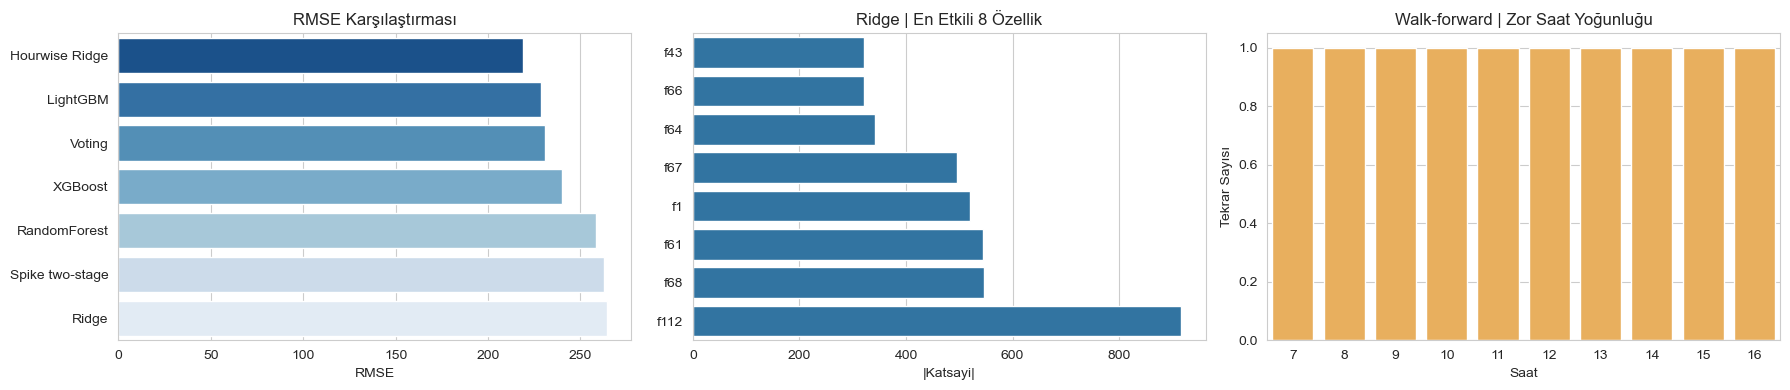

In [97]:
from IPython.display import HTML, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ------------------------------------------------------------------
# 1) Model metriklerini topla
# ------------------------------------------------------------------
METRIC_KEYS = ["RMSE", "MAE", "MAPE%", "sMAPE%", "R2"]
model_rows = []  # global koleksiyon

def _resolve_metrics(*names):
    for name in names:
        obj = globals().get(name)
        if obj is None:
            continue
        if isinstance(obj, dict):
            return {k: obj.get(k) for k in METRIC_KEYS if k in obj}
        if isinstance(obj, pd.Series):
            return {k: obj.get(k) for k in METRIC_KEYS if k in obj}
        if isinstance(obj, pd.DataFrame) and not obj.empty:
            cols = [c for c in obj.columns if c in METRIC_KEYS]
            if cols:
                summary = obj[cols].mean(numeric_only=True)
                return {c: float(summary[c]) for c in cols if pd.notnull(summary[c])}
            first = obj.iloc[0]
            return {k: first[k] for k in METRIC_KEYS if k in first}
    return {}

def _collect_metric(label, *names):
    """Metrikleri bulup model_rows'a ekler."""
    metrics = _resolve_metrics(*names)
    if metrics:
        entry = {"Model": label}
        entry.update(metrics)
        model_rows.append(entry)

# metrikleri topla
_collect_metric("Ridge", "metrics_ridge")
_collect_metric("Hourwise Ridge", "metrics_hourwise", "metrics_hourly")
_collect_metric("LightGBM", "metrics_lgbm")
_collect_metric("XGBoost", "metrics_xgb")
_collect_metric("RandomForest", "metrics_rf", "metrics_random_forest")
_collect_metric("Stacking", "metrics_stack")
_collect_metric("Voting", "metrics_vote")
_collect_metric("Spike two-stage", "metrics_two_stage")

# model_df ve best_model'i güvenle üret
model_df = pd.DataFrame(model_rows)
if not model_df.empty:
    # RMSE varsa ona göre sırala; yoksa ilk satırı en iyi say
    if "RMSE" in model_df.columns:
        model_df = model_df.sort_values("RMSE", na_position="last").reset_index(drop=True)
    best_model = str(model_df.iloc[0]["Model"])
else:
    best_model = "n/a"

# ------------------------------------------------------------------
# 2) Veri ve zaman özet kartları
# ------------------------------------------------------------------
cards = [
    {"title": "Temiz veri", "value": f"{len(df_clean):,} satir", "subtitle": f"{len(df_clean.columns)} kolon"},
    {"title": "FE veri", "value": f"{len(df_fe):,} satir", "subtitle": f"{len(feat_cols)} ozellik"},
    {"title": "Train/Test", "value": f"{train.shape[0]:,} / {test.shape[0]:,}", "subtitle": f"Target: {TARGET.upper()}"},
]

if "timestamp" in df_clean.columns:
    ts_min = pd.to_datetime(df_clean["timestamp"]).min()
    ts_max = pd.to_datetime(df_clean["timestamp"]).max()
    cards.append({"title": "Zaman Aralığı", "value": f"{ts_min:%Y-%m-%d}", "subtitle": f"-> {ts_max:%Y-%m-%d}"})

if "timestamp" in train.columns and not train.empty:
    cards.append({"title": "Train Aralığı", "value": f"{train['timestamp'].min():%Y-%m-%d}", "subtitle": f"-> {train['timestamp'].max():%Y-%m-%d}"})
if "timestamp" in test.columns and not test.empty:
    cards.append({"title": "Test Aralığı", "value": f"{test['timestamp'].min():%Y-%m-%d}", "subtitle": f"-> {test['timestamp'].max():%Y-%m-%d}"})

card_html = "".join(
    f"""
    <div style="flex:1 1 210px; min-width:210px; background:#f4f6fb; border-radius:12px;
                padding:14px 18px; box-shadow:0 1px 3px rgba(13,35,67,0.12);">
        <div style="font-size:11px; letter-spacing:0.08em; text-transform:uppercase; color:#5f7088;">
            {card['title']}
        </div>
        <div style="font-size:22px; font-weight:700; color:#1f2a44; margin:6px 0 2px;">
            {card['value']}
        </div>
        <div style="font-size:12px; color:#4b5c6d;">
            {card['subtitle']}
        </div>
    </div>
    """
    for card in cards
)

display(HTML(f"""
<div style="display:flex; flex-wrap:wrap; gap:16px; margin-bottom:18px;">
    {card_html}
</div>
"""))

# ------------------------------------------------------------------
# 3) Model performans tablosu
# ------------------------------------------------------------------
if not model_df.empty:
    styled_models = (
        model_df.style
        .format({"RMSE": "{:.2f}", "MAE": "{:.2f}", "MAPE%": "{:.2f}", "sMAPE%": "{:.2f}", "R2": "{:.3f}"})
        .highlight_min(subset=["RMSE"], color="#d4f4dd") if "RMSE" in model_df.columns else model_df.style
    )
    # R2 varsa highlight ekle
    if "R2" in model_df.columns:
        styled_models = styled_models.highlight_max(subset=["R2"], color="#d4f4dd")
    styled_models = styled_models.set_table_styles([
        {"selector": "th", "props": "text-align:left; background-color:#1f2a44; color:white;"},
        {"selector": "td", "props": "text-align:left;"},
    ])
    display(HTML("<h4 style='margin:8px 0 6px;'>Model Performans Özet Tablosu</h4>"))
    display(styled_models)
else:
    display(HTML("<h4>Model Performans Özet Tablosu</h4><p>Henuz hesaplanan model metrikleri bulunmuyor.</p>"))

# ------------------------------------------------------------------
# 4) Train/Test drift tablosu (KS, Wasserstein vb)
# ------------------------------------------------------------------
drift_df = None
drift_source = None
candidates = [
    "train_test_shift_df", "feature_shift_df", "ks_results_df", "ks_summary",
    "drift_summary_df", "ks_wasserstein_results", "dist_summary", "drift_table"
]

for name in candidates:
    obj = globals().get(name)
    if isinstance(obj, pd.DataFrame) and not obj.empty:
        cols_lower = [col.lower() for col in obj.columns]
        if any(term in col for col in cols_lower for term in ["ks", "wasser", "drift", "distance"]):
            drift_df = obj.copy()
            drift_source = name
            break

if drift_df is None:
    for name, obj in list(globals().items()):  # <<< değişen tek satır
        if isinstance(obj, pd.DataFrame) and not obj.empty:
            cols_lower = [str(col).lower() for col in obj.columns]  # küçük ek güvenlik
            if any(term in col for col in cols_lower for term in ["ks", "wasser", "drift", "distance"]):
                drift_df = obj.copy()
                drift_source = name
                break

if drift_df is not None:
    display(HTML(
        f"<h4 style='margin-top:18px;'>Train/Test Dağılım Farkları "
        f"<span style=\"font-size:10px; color:#6c7a89;\">(kaynak: {drift_source})</span></h4>"
    ))
    metric_cols = [col for col in drift_df.columns if col.lower().startswith("feature") is False]
    styled_drift = (
        drift_df.head(15)
        .style
        .format({col: "{:.4f}" for col in metric_cols if pd.api.types.is_numeric_dtype(drift_df[col])})
        .background_gradient(cmap="Reds", subset=[col for col in metric_cols if pd.api.types.is_numeric_dtype(drift_df[col])])
        .set_properties(**{"text-align": "left"})
    )
    display(styled_drift)

# Ridge katsayılarından feat_df üret (yoksa)
if "feat_df" not in globals() or not isinstance(globals().get("feat_df"), pd.DataFrame) or globals()["feat_df"].empty:
    try:
        ridge_est = ridge_pipeline.named_steps["ridge"]
        coef = np.asarray(ridge_est.coef_).ravel()

        # Özellik isimleri: X_train DataFrame ise kolonları kullan
        if hasattr(X_train, "columns"):
            feature_names = np.array(X_train.columns, dtype=str)
        else:
            feature_names = np.array([f"f{i}" for i in range(len(coef))], dtype=str)

        feat_df = pd.DataFrame({
            "Feature": feature_names,
            "Ridge_Coefficient": coef
        })
    except Exception as e:
        feat_df = pd.DataFrame()  # güvenli fallback


# ------------------------------------------------------------------
# 5) Grafikler: modeller, onemli ozellikler, zor saatler
# ------------------------------------------------------------------
plots = []
if not model_df.empty:
    plots.append("models")

feat_plot_df = None
if isinstance(globals().get("feat_df"), pd.DataFrame) \
        and not globals()["feat_df"].empty \
        and "Ridge_Coefficient" in globals()["feat_df"].columns:
    feat_plot_df = (
        globals()["feat_df"]
        .assign(abs_coef=lambda d: d["Ridge_Coefficient"].abs())
        .sort_values("abs_coef", ascending=False)
        .head(8)
    )
    plots.append("features")


worst_hours_series = None
if "worst_hours" in globals() and globals()["worst_hours"]:
    worst_hours_series = pd.Series(globals()["worst_hours"]).value_counts().sort_index()
    plots.append("worst_hours")

if plots:
    fig, axes = plt.subplots(1, len(plots), figsize=(6 * len(plots), 4))
    if len(plots) == 1:
        axes = [axes]

    for ax, plot_kind in zip(axes, plots):
        if plot_kind == "models":
            # model_df beklenen kolonlara sahipse çubuk grafiği çiz
            plot_cols = [c for c in ["RMSE", "Model"] if c in model_df.columns]
            if set(plot_cols) == {"RMSE", "Model"}:
                sns.barplot(data=model_df, x="RMSE", y="Model", ax=ax, palette="Blues_r")
                ax.set_title("RMSE Karşılaştırması")
                ax.set_xlabel("RMSE")
                ax.set_ylabel("")
            else:
                ax.set_visible(False)
        elif plot_kind == "features" and feat_plot_df is not None:
            order = feat_plot_df.sort_values("abs_coef", ascending=True)["Feature"]
            sns.barplot(data=feat_plot_df, x="abs_coef", y="Feature", ax=ax, order=order)
            ax.set_title("Ridge | En Etkili 8 Özellik")
            ax.set_xlabel("|Katsayi|")
            ax.set_ylabel("")

        elif plot_kind == "worst_hours" and worst_hours_series is not None:
            sns.barplot(x=worst_hours_series.index, y=worst_hours_series.values, ax=ax, color="#ffb347")
            ax.set_title("Walk-forward | Zor Saat Yoğunluğu")
            ax.set_xlabel("Saat")
            ax.set_ylabel("Tekrar Sayısı")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 6) Metinsel notlar
# ------------------------------------------------------------------
notes = []
if best_model != "n/a":
    notes.append(f"En düşük RMSE: <strong>{best_model}</strong>")
if worst_hours_series is not None:
    notes.append("Zorlu Saatler: " + ", ".join(map(str, worst_hours_series.index.tolist())))
if feat_plot_df is not None:
    notes.append("On plana cikan ozellikler: " + ", ".join(feat_plot_df["Feature"].tolist()))

if notes:
    display(HTML(
        "<div style='margin-top:12px; font-size:13px; color:#2f3a4c;'>"
        "<strong>Ön Plana Çıkan Notlar:</strong> " + " · ".join(notes) + "</div>"
    ))